In [ ]:
#Enable the interactive widget backend
%matplotlib widget

# Core data processing libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
import matplotlib.lines as mlines
import matplotlib.patches as patches
import seaborn as sns
from itertools import cycle

# Utility imports
import re, io, warnings, os, copy, base64, gc, traceback, time
from io import BytesIO
from functools import partial
from itertools import combinations
from pathlib import Path

# Jupyter-specific imports
from traitlets import HasTraits, Instance, observe
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import (
    interact, interactive, fixed, interact_manual,
    GridspecLayout, VBox, HBox, Layout, Output
)
#from ipydatagrid import DataGrid

# Initialize settings
import _settings as settings
from utils.uniprot_client import UniProtClient
warnings.simplefilter(action='ignore', category=FutureWarning)

# Declare global variables
global spec_translate_list, valid_discrete_cmaps, valid_gradient_cmaps
global default_hm_color, default_lp_color, default_avglp_color
global hm_selected_color, cmap, lp_selected_color
global avglp_selected_color, avg_cmap, port_hm_settings
global chuck_size, plot_heatmap, plot_zero, legend_title
global data_transformer, HeatmapPlotHandler

def initialize_global_variables():
    """Initialize all global variables used in the notebook."""
    global spec_translate_list, valid_discrete_cmaps, valid_gradient_cmaps
    global default_hm_color, default_lp_color, default_avglp_color
    global hm_selected_color, cmap, lp_selected_color
    global avglp_selected_color, avg_cmap, port_hm_settings
    global chuck_size, plot_heatmap, plot_zero, legend_title
    global data_transformer, HeatmapPlotHandler
    
    # Global variables from settings
    spec_translate_list = settings.SPEC_TRANSLATE_LIST
    valid_discrete_cmaps = settings.valid_discrete_cmaps
    valid_gradient_cmaps = settings.all_gradient_cmaps
    
    # Define default values for the color maps
    default_hm_color = 'RdYlGn_r'
    #default_hm_color = 'Purples'
    
    default_lp_color = 'Set3'
    default_avglp_color = 'Dark2'
    
    # Define the color map for the heatmap
    hm_selected_color = default_hm_color
    cmap = plt.get_cmap(hm_selected_color)
    
    # Define the color map for the individual line plots
    lp_selected_color = default_lp_color
    
    # Define the color for the averaged line plots
    avglp_selected_color = default_avglp_color
    avg_cmap = plt.get_cmap(avglp_selected_color)
    
    # Define settings for different numbers of variables
    port_hm_settings = {
        #num_var: (lineplot_height, scale_factor)
        1: (35, 0.075),
        2: (20, 0.125),
        3: (20, 0.15),
        4: (20, 0.175),
        5: (20, 0.225),
        6: (20, 0.25),
        7: (20, 0.275),
        8: (20, 0.3),
        9: (20, 0.325),
        10: (20, 0.36),
        11: (20, 0.38),
        12: (20, 0.41)
    }
    
    chuck_size = 78
    plot_heatmap, plot_zero = 'yes', 'no'
    legend_title = ['Sample Type:','Peptide Counts:','Bioactivity Function:','Peptide Interval:', 'Average Abundance:']
    
    data_transformer = HeatmapPlotHandler = None

# Call the function to initialize all global variables
initialize_global_variables()


In [ ]:
# Define functions outside of class
def update_filenames(input_filename_port, input_filename_land):
    # Append directory and .png only when necessary
    #updated_filename_port = f'{images_folder_name}/{input_filename_port}.png' if input_filename_port else None
    #updated_filename_land = f'{images_folder_name}/{input_filename_land}.png' if input_filename_land else None
    updated_filename_port = f'{input_filename_port}' if input_filename_port else None
    updated_filename_land = f'{input_filename_land}' if input_filename_land else None

    return updated_filename_land, updated_filename_port

def proceed_with_label_specific_options(selected_bio_or_pep, bio_or_pep):
    # Initialize selected_peptides and selected_functions to ensure they are always defined
    selected_peptides = []
    selected_functions = []

    # Check and handle different cases based on bio_or_pep value
    if bio_or_pep == '1':  # Assuming '1' indicates selection of peptides
        selected_peptides = list(selected_bio_or_pep) if isinstance(selected_bio_or_pep, (list, tuple)) else [
            selected_bio_or_pep]
    elif bio_or_pep == '2':  # Assuming '2' indicates selection of functions
        selected_functions = list(selected_bio_or_pep) if isinstance(selected_bio_or_pep, (list, tuple)) else [
            selected_bio_or_pep]
    # Optional: handle unexpected bio_or_pep values
    else:
        error_message = f"Unexpected value for bio_or_pep: {bio_or_pep}"
        display(HTML(f"<div style='display: inline-block; margin: 10px 0;'><b style='color: red'>{error_message}</b></div>"))
    #print(f" DEBUG: selected_peptides: {selected_peptides}")
    return selected_peptides, selected_functions

def get_interval_start(peptide_label):
    """
    Extract numeric start from labels like '193-207' or '193-207 (Oxidation)'.
    """
    base = peptide_label.split()[0]  # take '193-207' from '193-207 (Oxidation)'
    return int(base.split('-')[0])

"""-----------------Export_Function---------------------------------""" 

def calculate_centralized_y_limits(available_data_variables_dict, selected_peptides, selected_functions, 
                                   ms_average_choice, bio_or_pep, filter_type, log_transform, 
                                   manual_y_axis=False, y_min_manual=None, y_max_manual=None):
    """
    Centralized function to calculate y_min and y_max from all data sources (individual peptides and averaged data)
    Supports manual y-axis scaling override
    Returns: (y_min, y_max, all_min_values, all_max_values)
    """
    all_min_values = []
    all_max_values = []
    
    for var in available_data_variables_dict:
        # Get MS average data if needed
        if ms_average_choice in ['yes', 'only']:
            var_ms_data = available_data_variables_dict[var]['ms_data_list']
            if isinstance(var_ms_data, (pd.DataFrame, pd.Series)):
                ms_values = var_ms_data.values
            else:
                ms_values = var_ms_data
            
            # Remove NaN and zero values
            ms_values = [val for val in ms_values if not pd.isna(val) and val > 0]
            if ms_values:
                all_min_values.extend(ms_values)
                all_max_values.extend(ms_values)
        
        # Get individual peptide data if needed
        if bio_or_pep != 'no' and ms_average_choice != 'only':
            bp_abs = available_data_variables_dict[var]['bioactive_peptide_abs_df']
            bp_func = available_data_variables_dict[var]['bioactive_peptide_func_df']
            var_name = available_data_variables_dict[var]['label']
            

            # Filter data based on selection
            try:
                filtered_bp_abs, filtered_bp_func, _ = filter_data_by_selection(
                    bp_abs, bp_func, selected_peptides, selected_functions, 
                    bio_or_pep, filter_type, ms_average_choice, var_name,
                    )
                
                # Extract values from filtered data
                for col in filtered_bp_abs.columns:
                    if col != 'average':
                        y_values = pd.to_numeric(filtered_bp_abs[col], errors='coerce')
                        y_values = y_values[y_values > 0].dropna()
                        if not y_values.empty:
                            all_min_values.extend(y_values.tolist())
                            all_max_values.extend(y_values.tolist())
                            
            except Exception as e:
                # If filtering fails, continue without this data
                continue
    
    # Override min/max values with manual settings if enabled (same logic as original process_available_data)
    if manual_y_axis:
        min_values = [y_min_manual]
        max_values = [y_max_manual]
    else:
        min_values = all_min_values
        max_values = all_max_values
    
    # Calculate final y_min and y_max
    if min_values and max_values:
        y_min = min(min_values)
        y_max = max(max_values) * 1.1  # Add 10% padding
        
        # Handle log transform constraints
        if log_transform:
            y_min = max(y_min, 0.1)
    else:
        # Fallback defaults
        y_min = 0.1 if log_transform else 0
        y_max = 1.0
    
    return y_min, y_max, min_values, max_values

# Function to calculate y-ticks based on the min and max values of datasets
def calculate_y_ticks(min_values, max_values, log_transform):
    """
    Calculate y-ticks with proper handling of zero/negative values
    """
    # Check for empty lists or all zeros
    if not min_values or not max_values:
        return [0, 1, 10]  # Default scale if no data
        
    # Filter out zeros and negative values, keep valid positives
    valid_mins = [x for x in min_values if x > 0]
    valid_maxs = [x for x in max_values if x > 0]
    
    # If no valid values after filtering
    if not valid_mins or not valid_maxs:
        return [0, 1, 10]
    
    try:
        overall_min = np.nanmin(valid_mins)
        overall_max = np.nanmax(valid_maxs)
        
        # If min or max are zero or negative after nanmin/nanmax

        
        if log_transform:
            if overall_min <= 0 or overall_max <= 0:
                return [0, 1, 10]
            # Apply log transformation for log scale
            min_power = 10 ** np.floor(np.log10(overall_min))
            max_power = 10 ** np.ceil(np.log10(overall_max))
            
            # Calculate midpoint in log space
            mid_point = np.sqrt(min_power * max_power)
            mid_point_rounded = 10 ** np.round(np.log10(mid_point))
            
            return [min_power, mid_point_rounded, max_power]
        else:
            # For linear scale, return min, mid, max rounded to 2 sigfigs
            mid_point = (overall_min + overall_max) / 2
            def round_sig(x, sig=2):
                if x == 0:
                    return 0
                exponent = int(np.floor(np.log10(abs(x))))
                factor = 10**(exponent - sig + 1)
                return round(x / factor) * factor
            def round_sig_ceil(x, sig=2):
                if x == 0:
                    return 0
                exponent = int(np.floor(np.log10(abs(x))))
                factor = 10**(exponent - sig + 1)
                return np.ceil(x / factor) * factor

            def round_sig_floor(x, sig=2):
                if x == 0:
                    return 0
                exponent = int(np.floor(np.log10(abs(x))))
                factor = 10**(exponent - sig + 1)
                return np.floor(x / factor) * factor
            overall_min_rounded = round_sig_floor(overall_min, 2)
            overall_max_rounded = round_sig(overall_max, 2)
            mid_point_rounded = round_sig_floor(mid_point, 2)
            return [overall_min_rounded, mid_point_rounded, overall_max_rounded]
        
    except (ValueError, RuntimeWarning):
        return [0, 1, 10]  # Fallback for any calculation errors

def calculate_abundance(protein_sequence, peptide_dataframe, grouping_variable):
    protein_sequence_length = len(protein_sequence)
    data = []
    Avg_column = f'Avg_{grouping_variable}'

    for idx, row in peptide_dataframe.iterrows():
        try:
            start_idx = int(row['start']) - 1
            stop_idx = int(row['end'])
            abundance_value = row[Avg_column]

            values = [0] * protein_sequence_length
            if abundance_value > 0:
                values[start_idx:stop_idx] = [abundance_value] * (stop_idx - start_idx)
            data.append(values)

        except (KeyError, ValueError) as e:
            error_message = f'{type(e).__name__}: {e} - Skipping this row'
            display(HTML(f"<div style='display: inline-block; margin: 10px 0;'><b style='color: red'>{error_message}</b></div>"))
            continue

    if not data:
        display(HTML(f"<div style='display: inline-block; margin: 10px 0;'><b style='color: orange'>No valid data to process. Returning empty DataFrame.</b></div>"))
        return pd.DataFrame()

    # Create the initial DataFrame
    abundance_df = pd.DataFrame(data).T
    abundance_df.columns = [
        f"{int(row['start'])}-{int(row['end'])}" + (f" {row['Unique Peptide ID']}" if 'Unique Peptide ID' in row and not pd.isnull(row['Unique Peptide ID']) else "")
        for _, row in peptide_dataframe.iterrows()
    ]

    
    # Initialize count list
    count_list = []
    
    # Check if abundance_df is empty or has no non-zero values
    if abundance_df.empty or abundance_df.eq(0).all().all():
        # Create all zeros for counts and averages
        count_list = [0] * len(protein_sequence)
        abundance_df['average'] = 0
    else:
        # Calculate counts and averages normally
        count_list = abundance_df.gt(0).sum(axis=1)
        abundance_df['average'] = abundance_df.replace(0, np.nan).mean(axis=1)
    
    # Assign the counts and amino acids
    abundance_df['count'] = count_list
    abundance_df['AA'] = list(protein_sequence)
    return abundance_df

def calculate_function(protein_sequence, peptide_dataframe, grouping_variable):
    protein_sequence_length = len(protein_sequence)
    data = []

    for _, row in peptide_dataframe.iterrows():
        start_idx = int(row['start'] - 1)
        stop_idx = int(row['end'])
        if stop_idx > protein_sequence_length:
            stop_idx -= 1
            
        function_value = row['function'] if 'function' in peptide_dataframe.columns else np.nan
        
        values = [None] * protein_sequence_length
        for i in range(start_idx, stop_idx):
            values[i] = function_value

        data.append(values)

    function_df = pd.DataFrame(data).T
    function_df.columns = [
        f"{int(row['start'])}-{int(row['end'])}" + (f" {row['Unique Peptide ID']}" if 'Unique Peptide ID' in row and not pd.isnull(row['Unique Peptide ID']) else "")
        for _, row in peptide_dataframe.iterrows()
    ]
    return function_df

def export_heatmap_data_to_dict(protein_id, group_key, group_info, protein_sequence, 
                               protein_species, protein_name, protein_df, is_all_null):
    """
    Exports the heatmap data to a dictionary based on filter type.
    """
    grouping_var = group_info['grouping_variable']
    relevant_columns = group_info['abundance_columns']
    
    # Check if required columns exist, if not create default DataFrame
    required_columns = ['function', 'start', 'end']
    if not all(col in protein_df.columns for col in required_columns):
        filtered_df = pd.DataFrame({
            'start': [0],
            'end': [1],
            'function': ['0']
        })
        filtered_protein_df = filtered_df.copy()
    else:
        filtered_protein_df = protein_df.dropna(subset=['function', 'start', 'end'])
        if 'Unique Peptide ID' in filtered_protein_df.columns:
            filtered_df = filtered_protein_df[['start', 'end', 'function', 'Unique Peptide ID']]
        else:
            filtered_df = filtered_protein_df[['start', 'end', 'function']]

    # Calculate the heatmap data
    func_heatmap_df = calculate_function(protein_sequence, filtered_df, grouping_var)
    heatmap_df = calculate_abundance(protein_sequence, protein_df, grouping_var)
    filtered_heatmap_df = calculate_abundance(protein_sequence, filtered_protein_df, grouping_var)

    # Create the dictionary to store the results
    heatmap_data = {
        'protein_id': protein_id,
        'protein_sequence': protein_sequence,
        'protein_name': protein_name,
        'protein_species': protein_species,
        'func_heatmap_df': func_heatmap_df,
        'heatmap_df': heatmap_df,
        'filtered_heatmap_df': filtered_heatmap_df
    }
    
    return heatmap_data

def chunk_dataframe(df, chunk_size, exclude_columns=3):
    # Select all rows and all but the last 'exclude_columns' columns
    df_subset = df.iloc[:, :-exclude_columns] if exclude_columns else df
    
    # Check if df_subset is empty or all zeros
    if df_subset.empty or (df_subset == 0).all().all():
        # Return a single chunk with the default structure
        default_chunk = pd.DataFrame(
            np.zeros((chunk_size, df_subset.shape[1])), 
            columns=df_subset.columns
        )
        return [default_chunk]
    
    # Calculate the number of rows needed to make the last chunk exactly 'chunk_size'
    total_rows = df_subset.shape[0]
    remainder = total_rows % chunk_size
    
    if remainder != 0:
        # Rows needed to complete the last chunk
        rows_to_add = chunk_size - remainder
        # Create a DataFrame with zero values for the missing rows
        additional_rows = pd.DataFrame(
            np.zeros((rows_to_add, df_subset.shape[1])), 
            columns=df_subset.columns
        )
        # Append these rows to df_subset
        df_subset = pd.concat(
            [df_subset, additional_rows], 
            ignore_index=True, 
            copy=False,
            verify_integrity=True
        )
    
    # Create chunks of the DataFrame
    max_index = df_subset.index.max() + 1
    return [df_subset.iloc[i:i + chunk_size] for i in range(0, max_index, chunk_size)]
    
def process_available_data(available_data_variables_dict, filter_type, selected_functions, selected_peptides, bio_or_pep, log_transform, manual_y_axis=False, y_min_manual=None, y_max_manual=None):
    """
    Process data for visualization when update_plot is called
    Returns: dict with data and 'errors' key containing list of error messages
    """
    errors = []
    if not available_data_variables_dict:
        return {'errors': ["No data available for processing"]} 

    count_list = []
    min_values = []
    max_values = []
    seq_len_list = []
    chunk_size = 78
    
    # Process each variable's data for visualization
    for var in available_data_variables_dict:
        if filter_type == 'all-peptides':
            df = available_data_variables_dict[var]['heatmap_df']
        elif filter_type == 'bioactive-only':
            df = available_data_variables_dict[var]['filtered_heatmap_df']
        elif filter_type == 'functional-only':
            if not selected_functions and bio_or_pep == '2':
                errors.append(f'Invalid menu selection or there are no results available to display for {var}. Please select "Bioactive Functions" for "Plot Specific Peptides", with at least one function containing data from the "Specific Options" dropdown menu selected.')
            if not selected_peptides and bio_or_pep == '1':
                errors.append(f'Invalid menu selection or there are no results available to display for {var}. Please select "Peptide Intervals" for "Plot Specific Peptides", with at least one peptide interval containing data from the "Specific Options" dropdown menu selected.')    
            
            # Filter both functional and Abundance data for specific functions
            func_df = available_data_variables_dict[var]['function_heatmap_df']
            if func_df is not None and not func_df.empty:
                # Get list of columns that contain any of the selected functions
                functional_positions = []
                for col in func_df.columns:
                    # Check if any selected function appears in any cell of this column
                    if any(any(func in str(cell) for func in selected_functions) for cell in func_df[col]):
                        functional_positions.append(col)
                              
                # Get Abundance data for these positions
                abs_df = available_data_variables_dict[var]['filtered_heatmap_df']
                if abs_df is not None and not abs_df.empty and functional_positions:
                    # Only keep columns that exist in abs_df
                    valid_columns = [col for col in functional_positions if col in abs_df.columns]
                    if valid_columns:
                        # Get the filtered Abundance data for selected columns
                        selected_abs_df = abs_df[valid_columns]
                        
                        # Create DataFrame with sequence and selected columns
                        df = pd.DataFrame({
                            'AA': abs_df['AA'],
                        })
                        
                        # Add the selected columns
                        df = pd.concat([df, selected_abs_df], axis=1)
                        
                        # Now calculate count and average from all data
                        non_zero_mask = df.drop('AA', axis=1) > 0
                        df['count'] = non_zero_mask.sum(axis=1)
                        df['average'] = df.drop('AA', axis=1).where(non_zero_mask).mean(axis=1)
                    else:
                        df = None
                else:
                    df = None
            else:
                df = None

        # Get counts and MS data
        if df is None or df.empty or 'count' not in df.columns or 'average' not in df.columns:
            # Create default DataFrame with zero values
            protein_length = len(available_data_variables_dict[var]['protein_sequence'])
            df = pd.DataFrame({
                'count': [0] * protein_length,
                'average': [0] * protein_length,
                'AA': list(available_data_variables_dict[var]['protein_sequence'])
            })

        # Get counts and MS data
        peptide_counts = df['count']
        ms_data = df['average']
        count_list.append(peptide_counts)
  
        # Calculate min/max MS values
        min_ms = ms_data[ms_data > 0].min()
        max_ms = ms_data.max()
        min_values.append(min_ms)
        max_values.append(max_ms)
        
        # Add computed properties to the variable data
        available_data_variables_dict[var].update({
            'peptide_counts': peptide_counts,
            'ms_data': ms_data,
            'ms_data_list': list(ms_data),
            'AA_list': df['AA'].tolist(),
            'max_peptide_counts': peptide_counts.max(),
            'min_peptide_counts': peptide_counts.min(),
            'max_ms_data': max_ms,
            'min_ms_data': min_ms,
            
            # Generate chunks
            'amino_acids_chunks': [
                available_data_variables_dict[var]['protein_sequence'][i:i + chunk_size]
                for i in range(0, len(available_data_variables_dict[var]['protein_sequence']), chunk_size)
            ],
            'peptide_counts_chunks': [
                peptide_counts[i:i + chunk_size]
                for i in range(0, len(peptide_counts), chunk_size)
            ],
            'ms_data_chunks': [
                ms_data[i:i + chunk_size]
                for i in range(0, len(ms_data), chunk_size)
            ]
        })
        
        # Process bioactive peptide data
        columns_to_include = df.columns.difference(['AA', 'count'])
        df_filtered = df[columns_to_include]
        
        available_data_variables_dict[var].update({
            'bioactive_peptide_abs_df': df_filtered,
            #'bioactive_peptide_chunks': chunk_dataframe(df_filtered, chunk_size),
            #'bioactive_function_chunks': chunk_dataframe(available_data_variables_dict[var]['function_heatmap_df'], chunk_size),
            'bioactive_peptide_func_df': available_data_variables_dict[var]['function_heatmap_df']
        })
        
        seq_len_list.append(len(available_data_variables_dict[var]['amino_acids_chunks'][0]))

    # Calculate global values
    global axis_number, total_plots, y_ticks
    max_sequence_length = max(seq_len_list)
    axis_number = len(available_data_variables_dict) + 2
    num_sets = len(next(iter(available_data_variables_dict.values()))['amino_acids_chunks'])
    total_plots = num_sets * axis_number
    style_map = assign_line_styles(available_data_variables_dict)
    
    # Process counts
    if len(set([item for sublist in count_list for item in sublist])) >= 1:
        flat_list = [item for sublist in count_list for item in sublist]
        # Check if there are any non-zero values before filtering
        non_zero_values = [item for item in flat_list if item != 0]
        if non_zero_values:  # If there are non-zero values
            list_of_counts = set(non_zero_values)
            max_count = max(non_zero_values)
            num_unique_count = len(set(non_zero_values))
        else:  # If all values are zero
            list_of_counts = {0}
            max_count = 0
            num_unique_count = 1
    else:
        max_count = 0
        num_unique_count = 0
        list_of_counts = set()
    # Calculate number of colors
    num_colors = 6 if num_unique_count >= 6 else num_unique_count

    # Override min/max values with manual settings if enabled
    if manual_y_axis:
        min_values = [y_min_manual]
        max_values = [y_max_manual]
    # Calculate global values
    if min_values and max_values:
        y_ticks = calculate_y_ticks(min_values, max_values, log_transform)
        y_ticks_str = ', '.join(f'{tick:.2e}' for tick in y_ticks)
        y_ticks_html = f'<b>Max/Min of MS data (y-ticks):</b> {y_ticks_str}'
    else:
        y_ticks = [0.1, 1, 10]  # Default log scale values
        y_ticks_html = '<span style="color:red;">Insufficient data to calculate MS data y-ticks.</span>'
        y_ticks_html += f'<b>Protein Sequence Length:</b> {max_sequence_length}'


    return {
        'list_of_counts': list_of_counts,
        'min_values': min_values,
        'max_values': max_values,
        'seq_len_list': seq_len_list,
        'max_sequence_length': max_sequence_length,
        'y_ticks': y_ticks,
        'max_count': max_count,
        'num_unique_count': num_unique_count,
        'num_colors': num_colors,
        'total_plots': total_plots,
        'style_map': style_map,
        'errors': errors

    }

# Update plot function
def update_plot(available_data_variables_dict, ms_average_choice, bio_or_pep, selected_peptides, selected_functions,
                hm_selected_color, lp_selected_color, avglp_selected_color,
                xaxis_label, yaxis_label, yaxis_position, legend_title_input_1, legend_title_input_2,
                legend_title_input_3, plot_land, plot_port, filter_type, log_transform,
                manual_y_axis, y_min_manual, y_max_manual):
    all_errors = []
    
    if not available_data_variables_dict:  # Check if data is available
        all_errors.append('No data is available for plotting.')
        return (None, None, all_errors, [])  # Return tuple with errors
    
    result = process_available_data(available_data_variables_dict, filter_type, selected_functions,  selected_peptides, bio_or_pep, log_transform, manual_y_axis, y_min_manual, y_max_manual)
    # Initialize fig_port and fig_land to None
    fig_port_return = None
    fig_land_return = None

    # Unpack the dictionary into individual global variables
    import _settings as settings
    if result:
        # Check for processing errors
        if 'errors' in result and result['errors']:
            all_errors.extend(result['errors'])
        
        # Unpack the dictionary into individual global variables
        global list_of_counts, min_values, max_values, seq_len_list, max_sequence_length
        global max_count, num_unique_count, num_colors, total_plots, style_map, y_ticks
        
        lineplot_height, scale_factor = port_hm_settings.get(len(available_data_variables_dict), (20, 0.1))
        list_of_counts = result['list_of_counts']
        min_values = result['min_values']
        max_values = result['max_values']
        seq_len_list = result['seq_len_list']
        max_sequence_length = result['max_sequence_length']
        y_ticks = result['y_ticks']
        max_count = result['max_count']
        num_unique_count = result['num_unique_count']
        num_colors = result['num_colors']
        total_plots = result['total_plots']
        style_map = result['style_map']

        yaxis_position_land = yaxis_position_port = 0.0 - 0.01 * yaxis_position
        if log_transform or (y_ticks[1] - y_ticks[0] > 9999):
            yaxis_position_land = -0.01 - 0.01 * yaxis_position
        selected_legend_title = [legend_title_input_1, legend_title_input_2, legend_title_input_3, legend_title[4]]

        # Your plotting code here, using the widget values as inputs

        cmap = plt.get_cmap(hm_selected_color)
        avg_cmap = plt.get_cmap(avglp_selected_color)

        # Comprehensive validation of plotting configuration
        config_errors = []
        
        # Scenario 1: No averaged data + no specific peptides selected
        if ms_average_choice == 'no' and (not bio_or_pep or bio_or_pep == 'no'):
            config_errors.append('Invalid configuration: "Plot Averaged Data" is set to "No" and "Plot Specific Peptides" is not selected. Please enable at least one data source for plotting.')
        
        # Scenario 2: Peptide intervals selected but no actual intervals provided  
        elif bio_or_pep == '1' and (not selected_peptides or len(selected_peptides) == 0):
            config_errors.append('Invalid configuration: "Plot Specific Peptides" is set to "Peptide Intervals" but no peptide intervals are selected. Please select peptide intervals from the "Specific Options" dropdown or change the plotting configuration.')
        
        # Scenario 3: Bioactive functions selected but no actual functions provided
        elif bio_or_pep == '2' and (not selected_functions or len(selected_functions) == 0):
            config_errors.append('Invalid configuration: "Plot Specific Peptides" is set to "Bioactive Functions" but no bioactive functions are selected. Please select bioactive functions from the "Specific Options" dropdown or change the plotting configuration.')
        
        # Scenario 4: Only averaged data but filter is set to selected peptides/functions
        elif ms_average_choice == 'only' and filter_type in ['peptide-only', 'functional-only']:
            if filter_type == 'peptide-only':
                config_errors.append('Invalid configuration: "Plot Averaged Data" is set to "Only" but "Plot Filter" is set to "Selected Peptides Only". When plotting only averaged data, use "All Peptides" or "All Functional Peptides" filter.')
            else:
                config_errors.append('Invalid configuration: "Plot Averaged Data" is set to "Only" but "Plot Filter" is set to "Selected Functions Only". When plotting only averaged data, use "All Peptides" or "All Functional Peptides" filter.')
        
        # Scenario 5: Additional edge case - no data will be available for plotting
        elif ms_average_choice == 'no' and bio_or_pep != 'no' and filter_type in ['peptide-only', 'functional-only']:
            if bio_or_pep == '1' and filter_type == 'functional-only':
                config_errors.append('Invalid configuration: "Plot Specific Peptides" is set to "Peptide Intervals" but "Plot Filter" is set to "Selected Functions Only". These settings are incompatible. Either change to "Selected Peptides Only" filter or switch to "Bioactive Functions" for specific peptides.')
            elif bio_or_pep == '2' and filter_type == 'peptide-only':
                config_errors.append('Invalid configuration: "Plot Specific Peptides" is set to "Bioactive Functions" but "Plot Filter" is set to "Selected Peptides Only". These settings are incompatible. Either change to "Selected Functions Only" filter or switch to "Peptide Intervals" for specific peptides.')
        
        # Scenario 6: All Functional Peptides filter with Peptide Intervals selection
        elif bio_or_pep == '1' and filter_type == 'all-functional':
            config_errors.append('Invalid configuration: "Plot Specific Peptides" is set to "Peptide Intervals" but "Plot Filter" is set to "All Functional Peptides". These settings are incompatible. Either change to "All Peptides" filter or switch to "Bioactive Functions" for specific peptides.')
        
        # Scenario 7: All Peptides filter with Bioactive Functions selection (opposite case)
        #elif bio_or_pep == '2' and filter_type == 'all-peptides':
        #    config_errors.append('Invalid configuration: "Plot Specific Peptides" is set to "Bioactive Functions" but "Plot Filter" is set to "All Peptides". These settings are incompatible. Either change to "All Functional Peptides" filter or switch to "Peptide Intervals" for specific peptides.')
        
        if config_errors:
            all_errors.extend(config_errors)
            return None, None, all_errors, []

        else:
            """ #                                       Function Call to Generate Plot
            #---------------------------------------------------------------------------------------------------------------------------------------------
            """

            if plot_port and bio_or_pep:
                # Temporarily suppress specific warning
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', UserWarning)
                    if ms_average_choice in ['yes', 'only']:
                        fig_port = visualize_sequence_heatmap_portrait(
                            available_data_variables_dict,
                            0.001,  
                            lineplot_height,  
                            1,  
                            xaxis_label,  
                            yaxis_label,  
                            selected_legend_title,  
                            yaxis_position_port,  
                            cmap,
                            avg_cmap,
                            lp_selected_color,
                            avglp_selected_color,
                            selected_functions,
                            ms_average_choice,
                            bio_or_pep,
                            log_transform,
                            y_ticks,
                            78)  # removed chunk_size= to make it a positional argument
                    else:
                        all_errors.append('No was selected earlier regarding the plotting of averaged Abundances, preventing the plotting of the averaged plot.')
                    if max_count <= 1:
                        # Check if this is due to missing function data
                        if bio_or_pep == '2' and selected_functions:
                            missing_functions = []
                            for func in selected_functions:
                                func_found = False
                                for var in available_data_variables_dict:
                                    bp_func = available_data_variables_dict[var]['bioactive_peptide_func_df']
                                    # Check if this function exists in any data
                                    for col in bp_func.columns:
                                        func_values = bp_func[col].dropna()
                                        if not func_values.empty:
                                            for val in func_values:
                                                sub_vals = [s.strip() for s in str(val).split(';')]
                                                if any(func.lower().replace(" ", "") == sub_val.lower().replace(" ", "") for sub_val in sub_vals):
                                                    func_found = True
                                                    break
                                        if func_found:
                                            break
                                    if func_found:
                                        break
                                if not func_found:
                                    missing_functions.append(func)
                            
                            if missing_functions:
                                if len(missing_functions) == 1:
                                    all_errors.append(f'No data available for the selected function "{missing_functions[0]}". Please select a different function or check your data.')
                                else:
                                    all_errors.append(f'No data available for the selected functions: {", ".join(missing_functions)}. Please select different functions or check your data.')
                            else:
                                all_errors.append('You have too few peptides for proper heatmapping.')
                        # Check if this is due to missing peptide data
                        elif bio_or_pep == '1' and selected_peptides:
                            missing_peptides = []
                            for peptide in selected_peptides:
                                peptide_found = False
                                for var in available_data_variables_dict:
                                    bp_abs = available_data_variables_dict[var]['bioactive_peptide_abs_df']
                                    # Check if this peptide interval exists as a column
                                    if peptide in bp_abs.columns:
                                        # Check if the column has any non-zero, non-NaN data
                                        peptide_data = pd.to_numeric(bp_abs[peptide], errors='coerce')
                                        if not peptide_data.dropna().empty and (peptide_data > 0).any():
                                            peptide_found = True
                                            break
                                if not peptide_found:
                                    missing_peptides.append(peptide)
                            
                            if missing_peptides:
                                if len(missing_peptides) == 1:
                                    all_errors.append(f'No data available for the selected peptide interval "{missing_peptides[0]}". Please select a different peptide interval or check your data.')
                                else:
                                    all_errors.append(f'No data available for the selected peptide intervals: {", ".join(missing_peptides)}. Please select different peptide intervals or check your data.')
                            else:
                                all_errors.append('You have too few peptides for proper heatmapping.')
                        else:
                            all_errors.append('You have too few peptides for proper heatmapping.')
            else:
                fig_port = None
            """_____________________________________________________EXECUTING CODE TO PLOT W/ UPDATES_________________________________________________________________"""
            
            # Plotting code
            if plot_land:
                amino_acid_height = 0.25 + 0.1 * (
                    len(available_data_variables_dict) // 4 if len(available_data_variables_dict) >= 8 else 0)
                indices_height = amino_acid_height + 0.08
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', UserWarning)
                    fig_land, land_errors = visualize_sequence_heatmap_lanscape(
                        available_data_variables_dict,
                        amino_acid_height,
                        7.5,
                        indices_height,
                        xaxis_label,
                        yaxis_label,
                        selected_legend_title,
                        yaxis_position_land,
                        cmap,
                        avg_cmap,
                        lp_selected_color,
                        avglp_selected_color,
                        selected_peptides,
                        selected_functions,
                        ms_average_choice,
                        bio_or_pep,
                        log_transform,
                        y_ticks,
                        filter_type,
                        manual_y_axis,
                        y_min_manual,
                        y_max_manual)
                
                # Collect landscape plotting errors
                all_errors.extend(land_errors)

                if max_count <= 1:
                    # Check if this is due to missing function data
                    if bio_or_pep == '2' and selected_functions:
                        missing_functions = []
                        for func in selected_functions:
                            func_found = False
                            for var in available_data_variables_dict:
                                bp_func = available_data_variables_dict[var]['bioactive_peptide_func_df']
                                # Check if this function exists in any data
                                for col in bp_func.columns:
                                    func_values = bp_func[col].dropna()
                                    if not func_values.empty:
                                        for val in func_values:
                                            sub_vals = [s.strip() for s in str(val).split(';')]
                                            if any(func.lower().replace(" ", "") == sub_val.lower().replace(" ", "") for sub_val in sub_vals):
                                                func_found = True
                                                break
                                    if func_found:
                                        break
                                if func_found:
                                    break
                            if not func_found:
                                missing_functions.append(func)
                        
                        if missing_functions:
                            if len(missing_functions) == 1:
                                all_errors.append(f'No data available for the selected function "{missing_functions[0]}". Please select a different function or check your data.')
                            else:
                                all_errors.append(f'No data available for the selected functions: {", ".join(missing_functions)}. Please select different functions or check your data.')
                        else:
                            all_errors.append('You have too few peptides for proper heatmapping.')
                    # Check if this is due to missing peptide data
                    elif bio_or_pep == '1' and selected_peptides:
                        missing_peptides = []
                        for peptide in selected_peptides:
                            peptide_found = False
                            for var in available_data_variables_dict:
                                bp_abs = available_data_variables_dict[var]['bioactive_peptide_abs_df']
                                # Check if this peptide interval exists as a column
                                if peptide in bp_abs.columns:
                                    # Check if the column has any non-zero, non-NaN data
                                    peptide_data = pd.to_numeric(bp_abs[peptide], errors='coerce')
                                    if not peptide_data.dropna().empty and (peptide_data > 0).any():
                                        peptide_found = True
                                        break
                            if not peptide_found:
                                missing_peptides.append(peptide)
                        
                        if missing_peptides:
                            if len(missing_peptides) == 1:
                                all_errors.append(f'No data available for the selected peptide interval "{missing_peptides[0]}". Please select a different peptide interval or check your data.')
                            else:
                                all_errors.append(f'No data available for the selected peptide intervals: {", ".join(missing_peptides)}. Please select different peptide intervals or check your data.')
                        else:
                            all_errors.append('You have too few peptides for proper heatmapping.')
                    else:
                        all_errors.append('You have too few peptides for proper heatmapping.')
            else:
                fig_land = None
        # Fixed return statement logic to check if the variables exist and have valid axes
        if plot_port:
            if bio_or_pep != 'no':
                all_errors.append('The portrait plot only supports plotting averaged Abundance of peptides which is not formatted to be combined with specified peptide intervals or functions.')
                fig_port_return = None 
            else:
                # Check if fig_port is defined and has axes
                if fig_port is not None and hasattr(fig_port, 'axes') and len(fig_port.axes) > 0:
                    fig_port_return = fig_port
        
        if plot_land:
            # Check if fig_land is defined and has axes
            if fig_land is not None and hasattr(fig_land, 'axes') and len(fig_land.axes) > 0:
                fig_land_return = fig_land

        if not plot_port and not plot_land:
            all_errors.append("One or both of the create plot checkbox must be selected to generate a plot.")

        # Collect missing data notifications for user feedback
        missing_data_notifications = collect_missing_data_notifications(
            available_data_variables_dict, selected_peptides, selected_functions, bio_or_pep
        )
        
        return fig_port_return, fig_land_return, all_errors, missing_data_notifications  # Return the figures with errors and notifications
    else:
        all_errors.append('Reselect "Variable Options", no data is available for plotting.')
        return None, None, all_errors, []  # Return None values with errors if no result
"""_________________________________________Data Visualization Functions_________________________________"""
# Function to plot rows of amino acids with backgrounds colored
def plot_row_color(ax, amino_acids, colors):
    ax.axis('off')
    ax.set_xlim(0, max_sequence_length)
    ax.set_xlabel('')
    for j, (aa, color) in enumerate(zip(amino_acids, colors)):
        ax.text(j + 0.5, 0.5, aa, color='black', ha='center', va='center', fontsize=14,
                backgroundcolor=mcolors.rgb2hex(color))

# Assigns line type for landscape plot if plotting individual peptides
def assign_line_styles(data_variables):
    # Define a set of line styles you find visually distinct
    line_styles = cycle(['-', '--', ':', '-.'])
    #line_styles = cycle(['-'])

    # Extract unique labels from your data variables
    unique_labels = set(data['label'] for data in data_variables.values())

    # Map each unique label to a line style
    style_map = {label: next(line_styles) for label in unique_labels}

    # Map each unique label to a line style
    #style_map = {'Gastric IVT': '--',
    #             'Intestinal IVT': ':',
    #             'J1H': '-', 'J2H': '-', 'J3H': '-', 'J4H': '-',}
    return style_map

# Function to plot rows of amino acids with NO backgrounds colored
def plot_row(ax, amino_acids):
    ax.axis('off')
    ax.set_xlim(0, max_sequence_length)
    ax.set_xlabel('')
    for j, (aa) in enumerate(amino_acids):
        ax.text(j + 0.5, 0.5, aa, color='black', ha='center', va='center', fontsize=8)  # backgroundcolor='white')

def sci_notation(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / 10**exponent
    return r"${:.1f}\times10^{{{}}}$".format(coeff, exponent)

def plot_average_ms_data(ax, ms_data, label, var_index, y_ticks, i, chunk_size, avg_cmap, log_transform, line_style, sci_threshold=9999):
    start_limit = i * chunk_size
    end_limit = (i + 1) * chunk_size - 1
    ax.set_xlim(start_limit, end_limit)

    if isinstance(ms_data, (pd.DataFrame, pd.Series)):
        x_values = ms_data.index.tolist()
        y_values = ms_data.values.tolist() if hasattr(ms_data.values, 'tolist') else list(ms_data.values)
    else:
        x_values = list(range(len(ms_data)))
        y_values = list(ms_data) if not isinstance(ms_data, list) else ms_data

    num_colors = avg_cmap.N
    color = avg_cmap(var_index % num_colors)
    
    try:
        line, = ax.plot(x_values, y_values, label=label, color=color, linestyle=line_style)
    except Exception as e:
        # If plotting fails, create a dummy line and log the error
        print(f"Error in plot_average_ms_data for {label}: {str(e)}")
        print(f"x_values type: {type(x_values)}, length: {len(x_values) if hasattr(x_values, '__len__') else 'N/A'}")
        print(f"y_values type: {type(y_values)}, length: {len(y_values) if hasattr(y_values, '__len__') else 'N/A'}")
        # Create a dummy line to prevent further errors
        line, = ax.plot([], [], label=label, color=color, linestyle=line_style)

    if log_transform:
        ax.set_yscale('log')
        # Force matplotlib to use only our custom y_ticks for log scale
        if y_ticks:
            ax.yaxis.set_major_locator(mticker.FixedLocator(y_ticks))
            ax.yaxis.set_minor_locator(mticker.NullLocator())  # Remove minor ticks
            ax.yaxis.set_major_formatter(mticker.FuncFormatter(sci_notation))
    else:
        ax.set_yscale('linear')
        if y_ticks:
            y_range = max(y_ticks) - min(y_ticks)
            if y_range >= sci_threshold:
                formatter = mticker.FuncFormatter(sci_notation)
            else:
                formatter = mticker.StrMethodFormatter("{x:.2f}")
            ax.yaxis.set_major_formatter(formatter)

    # Set y-ticks and y-axis limits (restored original formatting)
    if y_ticks:
        ax.set_yticks(y_ticks)
        ax.set_ylim(min(y_ticks), max(y_ticks))
    
    #ax.tick_params(axis='y', labelsize=12)
    ax.yaxis.tick_left()
    ax.set_xticks([])
    ax.set_xticklabels([])

    # Return y_values for centralized y-axis limit calculation
    return line, label, var_index, y_values

# Function to extract non-zero, non-NaN values
def extract_non_zero_non_nan_values(df):
    unique_functions = set()
    # Iterate over each value in the DataFrame
    for value in df.stack().values:  # df.stack() stacks the DataFrame into a Series
        if value != 0 and not pd.isna(value):  # Check if value is non-zero and not NaN
            if isinstance(value, str):
                # If the value is a string, it could contain multiple delimited entries
                entries = value.split('; ')
                unique_functions.update(entries)
            else:
                unique_functions.add(value)
    return unique_functions

    # This function is used in plotting to filter the data to only plot selected peptides or bioactive peptides, independent of averaged data

def filter_data_by_selection(bp_abs, bp_func, selected_peptides, selected_functions, bio_or_pep, filter_type, ms_average_choice, var_name):
    """
    Final simplified version that uses a completely different approach to avoid Series truth value issues.
    Returns: (filtered_bp_abs, filtered_bp_func, errors)
    """
    errors = []
    # ---------- Helper functions ----------
    def safe_str(value):
        """Safely convert any value to string, handling None, NaN, and Series objects"""
        try:
            if value is None:
                return ""
            
            # For Series objects, just return empty string to avoid truth value errors
            if hasattr(value, 'iloc'):
                return ""
                
            # Convert to string
            return str(value)
        except:
            return ""
    
    # ---------- Handle peptide intervals selection (bio_or_pep = '1') ----------
    if bio_or_pep == '1' and selected_peptides:
        # Find our selected peptide columns that exist in the DataFrame
        if bp_abs is None or not isinstance(bp_abs, pd.DataFrame) or bp_abs.empty:
            errors.append(f"Abundance DataFrame is empty for variable: {var_name}")
            return pd.DataFrame(), pd.DataFrame(), errors
            
        peptide_columns = [col for col in selected_peptides if col in bp_abs.columns]
        non_matching_peptides = [col for col in selected_peptides if col not in bp_abs.columns]
        
        if peptide_columns:
            # Add metadata columns if they exist
            meta_columns = ['AA', 'count', 'average']
            keep_columns = [col for col in meta_columns if col in bp_abs.columns]
            all_columns = keep_columns + peptide_columns

            # Create new DataFrames with only the columns we want
            filtered_bp_abs = bp_abs[all_columns].copy()
            filtered_bp_func = pd.DataFrame()
            
            # Add warning for non-matching peptides if any
            if non_matching_peptides:
                errors.append(f'Some peptide columns not found in data for variable: {var_name}. Missing: {non_matching_peptides}')
            
            return filtered_bp_abs, filtered_bp_func, errors
        else:
            errors.append(f'No matching peptide columns found in data for variable: {var_name}. Non-matching peptides: {non_matching_peptides}')
            return pd.DataFrame(), pd.DataFrame(), errors
    
    # ---------- Handle bioactive functions selection (bio_or_pep = '2') ----------
    elif bio_or_pep == '2' and selected_functions: 
        if bp_func is None or not isinstance(bp_func, pd.DataFrame) or bp_func.empty:
            errors.append(f"Function DataFrame is empty for variable: {var_name}")
            return pd.DataFrame(), pd.DataFrame(), errors
        try:
            # Simple string-based approach that completely avoids pandas operations
            # This manually scans the DataFrame for columns containing the selected functions
            columns_with_functions = []
            functions_found = set()
            
            # Get list of column names first
            all_columns = list(bp_func.columns)
            
            # Iterate through the function DataFrame columns
            for col_name in all_columns:
                # Process a column at a time - get non-NA function values
                func_values = bp_func[col_name].dropna()
                
                if func_values.empty:
                    continue
                
                # Track matched functions for this column
                matched_functions = set()
                
                # Check for matches with selected functions, splitting on ';' like in process_chunk_data
                for val in func_values:
                    # Convert to string (safely)
                    try:
                        value_str = str(val)
                    except:
                        continue
                    
                    # Skip empty strings or 'nan'
                    if not value_str or value_str == 'nan':
                        continue
                    
                    # Split the value on ';' and strip whitespace
                    sub_vals = [s.strip() for s in value_str.split(';')]
                    
                    for sub_val in sub_vals:
                        # Only match if sub_val matches exactly one of the selected_functions (case-insensitive, ignoring whitespace)
                        for func in selected_functions:
                            if func.lower().replace(" ", "") == sub_val.lower().replace(" ", ""):
                                matched_functions.add(func)
                
                # If we found any matches in this column, add it to the list
                if matched_functions:
                    columns_with_functions.append(col_name)
                
                # Add matched functions to the global set
                functions_found.update(matched_functions)
            
            # Remove any duplicates
            columns_with_functions = list(set(columns_with_functions))
            
            # Identify non-matching functions
            non_matching_functions = [func for func in selected_functions if func not in functions_found]
            
            if columns_with_functions:
                # Only include columns that are in both DataFrames  
                valid_cols_abs = [col for col in columns_with_functions if col in bp_abs.columns]
                valid_cols_func = [col for col in columns_with_functions if col in bp_func.columns]
                
                # Create filtered DataFrames
                if valid_cols_abs:
                    filtered_bp_abs = bp_abs[valid_cols_abs].copy()
                else:
                    filtered_bp_abs = pd.DataFrame()
                    
                if valid_cols_func:
                    filtered_bp_func = bp_func[valid_cols_func].copy()
                else:
                    filtered_bp_func = pd.DataFrame()
                
                # Add warning for non-matching functions if any
                if non_matching_functions:
                    errors.append(f'Some selected functions not found in data for variable: {var_name}. Missing: {non_matching_functions}')
                
                return filtered_bp_abs, filtered_bp_func, errors
            else:
                errors.append(f'No columns found containing any of the selected functions for variable: {var_name}. Non-matching functions: {non_matching_functions}')
                return pd.DataFrame(), pd.DataFrame(), errors
                
        except Exception as e:
            errors.append(f"Error in function filtering for variable: {var_name}: {str(e)}")
            return pd.DataFrame(), pd.DataFrame(), errors
    
    else:
        return bp_abs, bp_func, errors

def process_chunk_data(ax2, chunk_abs, chunk_func, chunk_size, i, y_ticks, handles, labels, 
                      sample_list, var_name_list, line_style, var_name, var_ms_data, 
                      selected_peptides, selected_functions, lp_selected_color, ms_average_choice, log_transform, bio_or_pep):
    
    footnote_list = []
    errors = []
    min_values = []
    max_values = []
    
    # Track peptides already processed to avoid duplicates
    processed_peptides = {}

    start_limit = i * chunk_size
    end_limit = (i + 1) * chunk_size - 1
    ax2.set_xlim(start_limit, end_limit)

    # Set up colormap
    common_columns = []
    colormap = plt.get_cmap(lp_selected_color)
    
    # Create a dictionary to map functions to colors
    if bio_or_pep == '1':
        num_colors = max(len(selected_peptides), 1)
        items_to_color = selected_peptides
    elif bio_or_pep == '2':
        num_colors = max(len(selected_functions), 1)
        items_to_color = selected_functions
    else:
        num_colors = 1
        items_to_color = []
    
    # Generate evenly spaced colors
    colors = colormap(np.linspace(0, 1, num_colors))
    
    # Create a dictionary mapping each function to a specific color
    function_colors = {item: colors[i % len(colors)] for i, item in enumerate(items_to_color)}
    function_colors['Multiple'] = 'black'  # Keep 'Multiple' as black
    
    # Track which functions we've already plotted
    plotted_functions = set()
    
    # Process each column in the abundance data
    columns_processed = 0

    for col in chunk_abs.columns:
        if col != 'average':
            try:
                # Force y_values to be numeric and drop NaN/zeros
                y_values = pd.to_numeric(chunk_abs[col], errors='coerce')
                y_values = y_values[y_values > 0]
                
                if not y_values.empty:
                    columns_processed += 1
                    # Ensure x_values and y_values are proper arrays for matplotlib
                    x_values = list(y_values.index)
                    y_values_list = list(y_values.values)
                    
                    # Additional validation
                    if len(x_values) != len(y_values_list):
                        errors.append(f"Mismatch in data lengths for column {col}: x_values={len(x_values)}, y_values_list={len(y_values_list)}")
                        continue
                    
                    if len(x_values) == 0:
                        errors.append(f"Empty data for column {col}")
                        continue
                    
                    # Get a default label
                    label_value = col

                    # Get function label if available
                    #print(f"[DEBUG] bio_or_pep: {bio_or_pep}")
                    #print(f"[DEBUG] col: {col}")
                    #print(f"[DEBUG] chunk_func.columns: {chunk_func.columns}")
                    #print(f"[DEBUG] selected_functions: {selected_functions}")

                    if bio_or_pep == '2' and col in chunk_func.columns:
                        # Get non-NA function values
                        func_values = chunk_func[col].dropna()
                        if not func_values.empty:
                            # Check for matches with selected functions, splitting on ';'
                            #print(f"[DEBUG] selected_functions: {selected_functions}")
                            found_functions = set()
                            for val in func_values:
                                # Split the value on ';' and strip whitespace
                                sub_vals = [s.strip() for s in str(val).split(';')]
                                for sub_val in sub_vals:
                                    # Only match if sub_val matches exactly one of the selected_functions (case-insensitive, ignoring whitespace)
                                    for func in selected_functions:
                                        if func.lower().replace(" ", "") == sub_val.lower().replace(" ", ""):
                                            found_functions.add(func)
                            if found_functions:
                                if len(found_functions) > 1:
                                    label_value = 'Multiple'
                                    # Check if this peptide was already processed to avoid duplicates
                                    if col not in processed_peptides:
                                        processed_peptides[col] = set()
                                    
                                    # Add functions to the existing set for this peptide
                                    processed_peptides[col].update(found_functions)
                                else:
                                    label_value = list(found_functions)[0]
                            else:
                                break
                            #print(f"[DEBUG] label_value: {label_value}")
                            #print(f"[DEBUG] found_functions: {found_functions}")
                        elif bio_or_pep == '1' and col in selected_peptides:
                            label_value = col


                    # Get appropriate color
                    if label_value in function_colors:
                        color = function_colors[label_value]
                    else:
                        color = 'grey'
                    
                    # Use solid lines for better visibility
                    current_line_style = '-'
                    
                    # Plot with increased line width for visibility
                    try:
                        lines = ax2.plot(x_values, y_values_list, 
                                    label=label_value,
                                    linestyle=line_style, 
                                    color=color)
                    except Exception as e:
                        error_msg = f"Error plotting line for column {col} in variable {var_name}: {str(e)}"
                        error_msg += f" | x_values type: {type(x_values)}, length: {len(x_values) if hasattr(x_values, '__len__') else 'N/A'}"
                        error_msg += f" | y_values_list type: {type(y_values_list)}, length: {len(y_values_list) if hasattr(y_values_list, '__len__') else 'N/A'}"
                        errors.append(error_msg)
                        continue
                    
                    line = lines[0]
                    
                    # Only add to legend if we haven't seen this function before
                    if label_value not in plotted_functions or bio_or_pep == '1':
                        handles.append(line)
                        labels.append(label_value)
                        sample_list.append(current_line_style)
                        var_name_list.append(var_name)
                        plotted_functions.add(label_value)
                        # Update min and max values logic to ignore NaNs and handle empty y_values
                        if len(y_values_list) > 0:
                            y_min_val = np.nanmin(y_values_list)
                            y_max_val = np.nanmax(y_values_list)
                            if not np.isnan(y_min_val):
                                min_values.append(y_min_val)
                            if not np.isnan(y_max_val):
                                max_values.append(y_max_val)

                #else:
                    
            except Exception as e:
                errors.append(f"Error plotting line for column {col} in variable {var_name}: {str(e)}")
                continue
    
    #print(f"Debug: Total columns processed with data: {columns_processed}")
        
    # Set up axis properties with original y-axis formatting restored
    if log_transform:
        ax2.set_yscale('log')
        # Force matplotlib to use only our custom y_ticks for log scale
        if y_ticks:
            ax2.yaxis.set_major_locator(mticker.FixedLocator(y_ticks))
            ax2.yaxis.set_minor_locator(mticker.NullLocator())  # Remove minor ticks
            ax2.yaxis.set_major_formatter(mticker.FuncFormatter(sci_notation))
    else:
        ax2.set_yscale('linear')
        formatter = mticker.FuncFormatter(sci_notation)
        ax2.yaxis.set_major_formatter(formatter)
    
    # Force y-axis limits to ensure data is visible (restored original logic)
    if y_ticks:
        ax2.set_yticks(y_ticks)
        ax2.set_ylim(min(y_ticks), max(y_ticks))
    
    ax2.tick_params(axis='y', labelsize=16)
    ax2.yaxis.tick_left()
    ax2.set_xticks([])
    ax2.set_xticklabels([])
    
    # Convert processed_peptides to the format expected by footnote generation
    for peptide_col, functions in processed_peptides.items():
        if len(functions) > 1:  # Only include peptides with multiple functions
            peptide_info = {
                'peptide_column': peptide_col,
                'functions': sorted(list(functions))
            }
            footnote_list.append(peptide_info)
    
    return footnote_list, errors, min_values, max_values

def get_grouped_colors(counts, max_count, num_groups, plot_zero, cmap):
    # Initialize colors list with None to maintain length
    colors = [None] * len(counts)

    # Set the start point based on the user's input
    start_point = 0 if plot_zero == 'yes' else 1

    # Group counts into fewer categories if necessary, excluding zeros
    group_bounds = np.linspace(start_point, max_count, num_groups + 1)
    group_labels = np.digitize(counts, bins=group_bounds, right=True)  # Find group labels for counts
    ##print("DEBUG: group_labels", group_labels)
    norm = Normalize(vmin=start_point, vmax=num_groups)  # Normalize based on the number of groups

    # Map each count to a color
    #for i, count in enumerate(counts):
    for i, (count, label) in enumerate(zip(counts, group_labels)):
        if plot_zero == 'no' and count == 0:
            colors[i] = 'white'
        else:
            # Find which group the count belongs to
            group_idx = np.digitize(count, group_bounds) - 1
            
            if max_count > 20:
                # For large ranges, use continuous color mapping
                colors[i] = cmap(count / max_count)
            else:
                # For smaller ranges, use discrete color groups
                #colors[i] = cmap(norm(group_bounds[min(group_idx, len(group_bounds)-1)]))
                colors[i] = cmap(norm(label))

    #print("DEBUG: label",label)
    return colors

# Function to create legend for heatmap
def create_heatmap_legend_handles(cmap, num_colors, max_count, plot_zero):
    """
    Create color-coded legend handles for the heatmap with proper handling of zero values
    and error cases
    """
    try:
        # Handle case where all values are zero
        if max_count == 0:
           norm = Normalize(vmin=0, vmax=1)
           color = cmap(norm(0))
           return [patches.Patch(color=color, label='0')], ['0']
                 
        # Set the start point based on plot_zero
        start_point = 0 if plot_zero == 'yes' else 1
        
        # Create group boundaries to match get_grouped_colors
        count_ranges = np.linspace(start_point, max_count, num_colors + 1)
        
        # Determine interval type based on count vs intervals
        if max_count > num_colors:
           plt_interval = max_count
        else:
           plt_interval = num_colors
           
        legend_handles = []
        heatmap_labels = []
        norm = Normalize(vmin=start_point, vmax=max_count)

        # For small ranges, start from index 1 to skip the duplicate 1
        start_idx = 1 if plt_interval <= 6 else 0
        for i in range(start_idx, len(count_ranges)):
            color = cmap(norm(count_ranges[i]))
            if plt_interval <= 6 and plot_zero == 'no':
                label = f'{int(count_ranges[i])}'
            elif plt_interval <= 6 and plot_zero == 'yes':
                label = f'{int(count_ranges[i])}'
            elif i + 1 >= len(count_ranges):
                label = f'{int(count_ranges[i])} - {max(count_ranges)}'
                break
            else:
                # Create label showing range
                start_val = int(count_ranges[i])
                end_val = int(count_ranges[i + 1])
                label = f'{start_val} - {end_val}'
                
            #if i = len(count_ranges):
            #    color = cmap(norm(count_ranges[i]))
 
            #print("DEBUG: i:",i,"label:",label)
            #legend_handles.append(patches.Patch(color=color, label=label))
            legend_handles.append(patches.Patch(color=color, label=label))
            heatmap_labels.append(label)
        return legend_handles, heatmap_labels
       
    except Exception as e:
       # Fallback for error cases
       color = cmap(0)
       handle = patches.Patch(color=color, label='0')
       return [handle], ['0']

def create_custom_legends(
    fig, labels, handles, var_name_list, legend_titles, heatmap_legend_handles,
    heatmap_legend_labels, ms_average_choice, bio_or_pep, plot_type, plot_heatmap='yes'):
    import copy


    handles_dict = {}
    sample_handles_dict = {}

    # --- 1. Build handle maps ---
    for label, handle, sample_name in zip(labels, handles, var_name_list):
        handles_dict[label] = handle
        if sample_name not in sample_handles_dict:
            sample_handles_dict[sample_name] = handle

    # --- 2. Clone handles for modification ---
    new_handles_func = [copy.copy(h) for h in handles_dict.values()]
    new_labels_func = list(handles_dict.keys())

    averaged_handles, averaged_labels = [], []
    other_handles, other_labels = [], []

    for h, lbl in zip(new_handles_func, new_labels_func):
        if "Averaged" in lbl:
            averaged_handles.append(h)
            averaged_labels.append(lbl.replace("Averaged ", ""))
        else:
            h.set_linestyle('-')
            other_handles.append(h)
            other_labels.append(lbl)

    new_handles_samples = []
    if not averaged_handles:
        for h in sample_handles_dict.values():
            new_h = copy.copy(h)
            new_h.set_color("black")
            new_handles_samples.append(new_h)

    # --- 3. Dummy subtitle handles ---
    line_type = mlines.Line2D([], [], color='none', label='Line Type')
    average_color = mlines.Line2D([], [], color='none', label='Average Abundance')
    line_color = mlines.Line2D([], [], color='none', label='Line Color')
    pep_count_placeholder = mlines.Line2D([], [], color='none', label='Peptide Count')

    # --- 4. Assign titles ---
    line_type_title = legend_titles[0]
    avgline_color_title = legend_titles[2] if bio_or_pep == 'no' else legend_titles[3]
    color_title = legend_titles[2]

    # --- 5. Build combined handles and labels ---
    if ms_average_choice == 'yes':
        if bio_or_pep != 'no':
            combined_handles = [line_color] + other_handles + [average_color] + averaged_handles
            combined_labels = [color_title] + other_labels + [avgline_color_title] + averaged_labels
        else:
            combined_handles = [average_color] + averaged_handles
            combined_labels = [avgline_color_title] + averaged_labels

    elif ms_average_choice == 'only':
        combined_handles = [average_color] + averaged_handles
        combined_labels = [avgline_color_title] + averaged_labels

    elif ms_average_choice == 'no' and bio_or_pep != 'no':
        combined_handles = [line_color] + other_handles + [line_type] + new_handles_samples
        combined_labels = [color_title] + other_labels + [line_type_title] + list(sample_handles_dict.keys())

    else:
        combined_handles, combined_labels = other_handles, other_labels

    # --- 6. Create legends ---
    legend_peptide_count = None

    if plot_type == "land":
        if plot_heatmap == 'yes':
            legend_peptide_count = fig.legend(
                handles=heatmap_legend_handles,
                labels=heatmap_legend_labels,
                loc='center',
                fontsize=13,
                title=legend_titles[1],
                title_fontsize=13,
                bbox_to_anchor=(0.5, -0.15),
                ncol=len(heatmap_legend_handles),
                frameon=False
            )

        combined_legend = fig.legend(
            handles=combined_handles,
            labels=combined_labels,
            loc='upper left',
            bbox_to_anchor=(1.02, 1.0),
            fontsize=13,
            handlelength=2.5,
            frameon=False
        )

        # Adjust layout AFTER creating legends
        fig.subplots_adjust(right=0.8, bottom=0.2, top=1.05)
        plt.tight_layout(rect=[0, 0, 0.85, 0.95])

    elif plot_type == "port":
        combined_handles = [line_color] + other_handles + [pep_count_placeholder] + heatmap_legend_handles
        combined_labels = [avgline_color_title] + other_labels + [legend_titles[1]] + heatmap_legend_labels

        combined_legend = fig.legend(
            handles=combined_handles,
            labels=combined_labels,
            loc='upper left',
            bbox_to_anchor=(0.92, 0.95),
            fontsize=13,
            frameon=False
        )

        fig.subplots_adjust(right=0.85, top=1.1, bottom=0.15)
        plt.tight_layout(rect=[0, 0, 0.85, 0.92])

    # --- 7. Enable interactive toggling ---
    try:
        label_to_handle = {lbl: h for lbl, h in handles_dict.items()}

        def _enable_pick(legend):
            if legend is None:
                return
            for artist in list(legend.get_lines()) + list(legend.get_patches()):
                try:
                    artist.set_picker(True)
                except Exception:
                    pass

        _enable_pick(combined_legend)

        def _on_pick(event):
            try:
                artist = event.artist
                lbl = getattr(artist, "get_label", lambda: None)()
                if not lbl or lbl not in label_to_handle:
                    return
                series = label_to_handle[lbl]
                series.set_visible(not series.get_visible())
                artist.set_alpha(1.0 if series.get_visible() else 0.3)
                fig.canvas.draw_idle()
            except Exception:
                pass

        cid = fig.canvas.mpl_connect("pick_event", _on_pick)
        if not hasattr(fig, "_legend_pick_cids"):
            fig._legend_pick_cids = []
        fig._legend_pick_cids.append(cid)
    except Exception:
        pass

    return combined_legend, legend_peptide_count

def collect_missing_data_notifications(available_data_variables_dict, selected_peptides, selected_functions, bio_or_pep):
    """
    Collect notifications about missing data for specific variables during plotting.
    Returns a list of notification messages for user display.
    """
    notifications = []
    
    if bio_or_pep == '1' and selected_peptides:  # Peptide intervals selected
        # Track which peptides are missing from which variables
        missing_by_variable = {}
        
        for var_name, var_data in available_data_variables_dict.items():
            missing_peptides = []
            if 'heatmap_df' in var_data:
                available_columns = var_data['heatmap_df'].columns.tolist()
                for peptide in selected_peptides:
                    if peptide not in available_columns:
                        missing_peptides.append(peptide)
            
            if missing_peptides:
                missing_by_variable[var_name] = missing_peptides
        
        # Create notification messages
        for var_name, missing_peptides in missing_by_variable.items():
            if len(missing_peptides) == 1:
                notifications.append(f"⚠️ Variable '{var_name}': Peptide interval '{missing_peptides[0]}' is not available in this dataset.")
            else:
                peptide_list = "', '".join(missing_peptides)
                notifications.append(f"⚠️ Variable '{var_name}': Peptide intervals '{peptide_list}' are not available in this dataset.")
    
    elif bio_or_pep == '2' and selected_functions:  # Bioactive functions selected
        # Track which functions are missing from which variables
        missing_by_variable = {}
        
        for var_name, var_data in available_data_variables_dict.items():
            missing_functions = []
            if 'function_heatmap_df' in var_data:
                func_df = var_data['function_heatmap_df']
                if func_df is not None and not func_df.empty:
                    # Extract all functions present in this variable
                    present_functions = set()
                    for col in func_df.columns:
                        for cell in func_df[col]:
                            if pd.notna(cell) and str(cell) != '0':
                                cell_str = str(cell)
                                if ';' in cell_str:
                                    present_functions.update(cell_str.split(';'))
                                else:
                                    present_functions.add(cell_str)
                    
                    # Check which selected functions are missing
                    for function in selected_functions:
                        if function not in present_functions:
                            missing_functions.append(function)
            else:
                # If no function data at all, all selected functions are missing
                missing_functions = selected_functions.copy()
            
            if missing_functions:
                missing_by_variable[var_name] = missing_functions
        
        # Create notification messages
        for var_name, missing_functions in missing_by_variable.items():
            if len(missing_functions) == 1:
                notifications.append(f"⚠️ Variable '{var_name}': Bioactive function '{missing_functions[0]}' is not available in this dataset.")
            else:
                function_list = "', '".join(missing_functions)
                notifications.append(f"⚠️ Variable '{var_name}': Bioactive functions '{function_list}' are not available in this dataset.")
    
    return notifications


"""_________________________________________Landscape Plot________________________________________"""
### def visualize_sequence_heatmap_individual_lines(available_data_variables_dict, amino_acid_height, lineplot_height, indices_height, filename, xaxis_label, yaxis_label, legend_title, yaxis_position):
def visualize_sequence_heatmap_lanscape(available_data_variables_dict,
                                                         amino_acid_height,
                                                         lineplot_height,
                                                         indices_height,
                                                         xaxis_label,
                                                         yaxis_label,
                                                         legend_title,
                                                         yaxis_position,
                                                         cmap,
                                                         avg_cmap,
                                                         lp_selected_color,
                                                         avglp_selected_color,
                                                         selected_peptides,
                                                         selected_functions,
                                                         ms_average_choice,
                                                         bio_or_pep, log_transform, y_ticks, filter_type,
                                                         manual_y_axis=False, y_min_manual=None, y_max_manual=None):
    all_errors = []
    # Use a list comprehension to find the maximum length of 'AA_list' across all variables
    max_sequence_length = max([len(available_data_variables_dict[var]['AA_list']) for var in available_data_variables_dict])

    # Check if there are multiple distinct protein IDs in available_data_variables_dict
    multiple_proteins = len(set([available_data_variables_dict[var]['protein_id'] for var in available_data_variables_dict])) > 1

    chunk_size = max_sequence_length
    # Create legend handles for the heatmap
    heatmap_legend_handles, heatmap_legend_labels = create_heatmap_legend_handles(cmap, num_colors, max_count, plot_zero)  # You can change the number 5 to have more or fewer color intervals

    # Function to plot rows of amino acids with backgrounds colored
    # Function to plot rows of amino acids with backgrounds colored
    def plot_row_color_landscape(ax, amino_acids, colors):
        ax.axis('off')
        ax.set_xlim(0, max_sequence_length)
        ax.set_xlabel('')
        # Height and width for each cell
        cell_width = 1  # Each amino acid is spaced evenly by 1 unit on the x-axis
        cell_height = 1  # Set height of the row

        for j, (aa, color) in enumerate(zip(amino_acids, colors)):
            # Create a rectangle (cell) with the background color
            rect = patches.Rectangle((j, 0), cell_width, cell_height, color=mcolors.rgb2hex(color))
            ax.add_patch(rect)  # Add the colored rectangle to the plot

    # Function to plot rows of amino acids with backgrounds colored
    def plot_row_landscape(ax, amino_acids):
        ax3.axis('off')
        ax3.set_xlim(0, max_sequence_length)
        ax3.set_xlabel('')
        aa_font_size = 10
        if max_sequence_length > 200:
            aa_font_size -= 0.5
        if max_sequence_length > 250:
            aa_font_size -= 1
        if max_sequence_length > 300:
            return
        for j, (aa) in enumerate(amino_acids):
                ax3.text(j + 0.5, 0.5, aa, color='black', ha='center', va='center',
                         fontsize=aa_font_size)

    axis_number = 3  # Total number of plots per set of data
    if plot_heatmap == 'yes':
        # Define height ratios for each subplot in a set
        height_ratios = (
                    [lineplot_height] + [indices_height] + [amino_acid_height] * len(available_data_variables_dict) + [amino_acid_height])
        axis_number = len(available_data_variables_dict) + 3

    elif plot_heatmap == 'no':
        height_ratios = ([lineplot_height] +[indices_height] + [amino_acid_height] )
        axis_number = 3

    fig, axes = plt.subplots(axis_number, 1, figsize=(25, (lineplot_height + indices_height + amino_acid_height)),
                            gridspec_kw={'height_ratios': height_ratios, 'hspace': 0})

    # Calculate centralized y-axis limits before plotting  
    y_min_central, y_max_central, all_min_vals, all_max_vals = calculate_centralized_y_limits(
        available_data_variables_dict, selected_peptides, selected_functions, 
        ms_average_choice, bio_or_pep, filter_type, log_transform,
        manual_y_axis, y_min_manual, y_max_manual
    )
    
    # Use centralized values to calculate proper y_ticks that will be consistently applied
    if all_min_vals and all_max_vals:
        y_ticks = calculate_y_ticks(all_min_vals, all_max_vals, log_transform)

    # Initialize for legend handling
    handles, labels, sample_list, var_name_list = [], [], [], []
    total_count = 0

    # Loop through each set of data and create plots
    for var_index, var in enumerate(available_data_variables_dict):
        ax1 = axes[0]
        ax1.axis('off')
        ax1 = ax1.twinx()  # Create a twin y-axis
        ax1.yaxis.set_minor_locator(plt.NullLocator())

        var_amino_acids = available_data_variables_dict[var]['AA_list']
        var_counts = available_data_variables_dict[var]['peptide_counts']
        var_ms_data = available_data_variables_dict[var]['ms_data_list']
        var_name = available_data_variables_dict[var]['label']
        var_colors = get_grouped_colors(var_counts, max_count, num_colors, plot_zero, cmap)
        bp_abs = available_data_variables_dict[var]['bioactive_peptide_abs_df']
        bp_func = available_data_variables_dict[var]['bioactive_peptide_func_df']
        # Default line style
        line_style = '-'  # Default style if other conditions don't apply

        #if ms_average_choice == 'yes' and bio_or_pep == 'no':
        #   line_style = '-'  # This can stay '-' or change as per your requirement
        #else:
        line_style = style_map[var_name]  # Get assigned line style from the style map

        if bio_or_pep != 'no' and ms_average_choice != 'only':
            filtered_bp_abs, filtered_bp_fun, filter_errors = filter_data_by_selection(bp_abs, bp_func, selected_peptides,
                                                                        selected_functions, bio_or_pep, filter_type, ms_average_choice, var_name)
      
            footnote_list, process_errors, min_vals, max_vals = process_chunk_data(ax1, filtered_bp_abs, filtered_bp_fun, chunk_size, 0, y_ticks, handles,
                                            labels, sample_list, var_name_list, line_style, var_name, var_ms_data,
                                            selected_peptides, selected_functions, lp_selected_color, ms_average_choice,
                                            log_transform, bio_or_pep)
            # Collect all errors
            all_errors.extend(filter_errors)
            all_errors.extend(process_errors)

        if ms_average_choice in ['yes', 'only']:
            # Ensure that line_style is defined before this point or provide a default value
            line, label, _, avg_y_values = plot_average_ms_data(ax1, var_ms_data, f'Averaged {var_name}', var_index, y_ticks, 0,
                                                  chunk_size, avg_cmap, log_transform, line_style)
            handles.append(line)
            labels.append(f'{label}')
            sample_list.append(line_style)
            var_name_list.append(var_name)
            ax1.tick_params(axis='y', labelsize=14)
        # Plot indices below the MS line plot
        ax2 = axes[1]
        ax2.axis('off')
        ax2.set_xlim(0, max_sequence_length)
        indices = [0]
        if var_index == 0:
            # Add indices at increments of 20, starting from 20 up to the length of the array, but not including the last index if it's less than 20 away
            indices.extend(range(20, max_sequence_length - 5, 20))
            # Always add the last index of the array
            indices.append(max_sequence_length - 1)
            for idx in indices:
                ax2.text(idx + 0.5, 0.5, str(total_count + idx + 1), ha='center', va='center', fontsize=16)
            total_count += max_sequence_length

            # Amino acid plots
            ax3 = axes[2]

            # Check if there's only one distinct protein
            if not multiple_proteins:
                plot_row_landscape(ax3, var_amino_acids)  # Call plot_row_landscape if only 1 protein
            else:
                ax3.axis('off')  # Plot a blank line by turning off the axis

        if plot_heatmap == 'yes':
            # Amino acid plots
            ax = axes[var_index + 3]
            plot_row_color_landscape(ax, var_amino_acids, var_colors)
            ax.text(0, 0.5, var_name, ha='right', va='center', fontsize=14)
            
#            Interactive hover: show Position, AA, Peptide Count on heatmap
            try:
                annot = ax.annotate('', xy=(0,0), xytext=(20,20), textcoords='offset points',
                                    bbox=dict(boxstyle='round,pad=0.7', fc='#f8f9fa', ec='#34495e', 
                                             alpha=0.95, lw=2),
                                    fontsize=10, fontfamily='monospace', zorder=1000)
                annot.set_visible(False)
                
                def _on_move(evt, aa_list=var_amino_acids, counts=var_counts, sample_name=var_name, _annot=annot, _ax=ax):
                    if evt.inaxes != _ax or evt.xdata is None:
                        if _annot.get_visible():
                            _annot.set_visible(False)
                            try:
                                _ax.figure.canvas.draw_idle()
                            except Exception:
                                pass
                        return
                    try:
                        idx = int(round(evt.xdata))
                    except Exception:
                        idx = 0
                    if idx < 0:
                        idx = 0
                    if idx >= len(aa_list):
                        idx = len(aa_list) - 1
                    pos = idx + 1
                    aa = aa_list[idx] if idx < len(aa_list) else '?'
                    cnt = counts[idx] if idx < len(counts) else 0
                    try:
                        cnt = int(cnt)
                    except Exception:
                        pass
                    
                    # Professional formatted tooltip
                    tooltip_text = f"{sample_name}\n{'─' * len(sample_name)}\nPosition: {pos}\nAmino Acid: {aa}\nPeptide Count: {cnt}"
                    _annot.xy = (evt.xdata, evt.ydata)
                    _annot.set_text(tooltip_text)
                    _annot.set_visible(True)
                    try:
                        _ax.figure.canvas.draw_idle()
                    except Exception:
                        pass
                
                # Connect event - store connection ID to prevent garbage collection
                cid = ax.figure.canvas.mpl_connect('motion_notify_event', _on_move)
                # Store the connection ID on the figure to keep it alive
                if not hasattr(fig, '_hover_connections'):
                    fig._hover_connections = []
                fig._hover_connections.append(cid)
                
            except Exception as e:
                print(f"DEBUG: Error setting up hover: {e}")
    # Create the legend after the plotting loop, using the handles and labels without duplicates
    # This will create a dictionary only with entries where the label is not '0'abs
    create_custom_legends(fig, labels, handles, var_name_list, legend_title, heatmap_legend_handles,
                          heatmap_legend_labels, ms_average_choice, bio_or_pep, plot_type="land")
        

    if bio_or_pep == '2' and ms_average_choice != 'only':
        # Process the footnote_list which now contains deduplicated peptide info
        if footnote_list:
            # Create header for the detailed table
            footnote_lines = [
                "For peptides with multiple bioactive functions, the label has been changed to 'Multiple'.",
                "The following table shows the affected peptides and their associated functions:",
                "",
                "Peptide Interval/Name → Bioactive Functions:"
            ]
            
            # Sort footnote_list by peptide column for consistent ordering
            sorted_footnotes = sorted(footnote_list, key=lambda x: x['peptide_column'])
            
            # Format each peptide entry (already deduplicated during collection)
            for i, item in enumerate(sorted_footnotes, 1):
                peptide_col = item['peptide_column']
                functions = item['functions']
                
                # Parse peptide column to separate interval from Unique Peptide ID
                if ' ' in peptide_col:
                    interval, unique_id = peptide_col.split(' ', 1)
                    peptide_display = f"{interval} ({unique_id})"
                else:
                    peptide_display = peptide_col
                
                functions_str = ", ".join(functions)  # Already sorted during collection
                footnote_lines.append(f"     {i}. {peptide_display} → {functions_str}")
            
            # Join all lines
            footnote = '\n'.join(footnote_lines)
        else:
            footnote = ""


    if ms_average_choice == 'only' and bio_or_pep == '1':
        all_errors.append('The selection of Plot Averaged Data option "only" and Plot Specific Peptides option "Peptide Intervals" is invalid. Only the average Abundance will be plotted.')

    if bio_or_pep == '2' and ms_average_choice != 'only':
        if footnote_list and footnote:  # Only display if there's actual footnote content
            #print(footnote)
            display(HTML(f"<div style='display: inline-block; margin: 10px 0; padding: 10px; background-color: #f0f8ff; border-left: 4px solid #0066cc;'><b style='color: #0066cc'>{footnote.replace(chr(10), '<br>')}</b></div>"))
                    
    # --- Set global figure text ---
    fig.text(0.02, 0.5, yaxis_label, va='center', rotation='vertical', fontsize=16)
    fig.text(0.5, 0.02, xaxis_label, ha='center', va='center', fontsize=16)
   
    # --- Adjust layout for breathing room ---
    plt.tight_layout(rect=[0.08, 0.15, 0.80, 0.95])

    # --- Optional: remove default "Figure 1" window title ---
    try:
        fig.canvas.manager.set_window_title("")
    except Exception:
        pass

    # Always return a tuple: (figure, list_of_errors)
    return fig, all_errors


"""_______________________________Portrait Plot______________________________________________"""
def visualize_sequence_heatmap_portrait(available_data_variables_dict,
                                             amino_acid_height,
                                             lineplot_height,
                                             indices_height,
                                             xaxis_label,
                                             yaxis_label,
                                             legend_title,
                                             yaxis_position,
                                             cmap,
                                             avg_cmap,
                                             lp_selected_color,
                                             avglp_selected_color,
                                             selected_functions,
                                             ms_average_choice,
                                             bio_or_pep,
                                             log_transform,
                                             y_ticks,
                                             chunk_size):


    lineplot_height, scale_factor = port_hm_settings.get(
        len(available_data_variables_dict), (20, 0.1))
    plot_zero == 'no'
    handles, labels, sample_list, var_name_list = [], [], [], []

    for var in available_data_variables_dict:
        num_sets = len(available_data_variables_dict[var]['amino_acids_chunks'])
    # Create legend handles for the heatmap
    heatmap_legend_handles, heatmap_legend_labels = create_heatmap_legend_handles(cmap, num_colors, max_count,
                                                                                  plot_zero)  # You can change the number 5 to have more or fewer color intervals

    # Define height ratios for each subplot in a set
    height_ratios = ([lineplot_height] + [indices_height] + [amino_acid_height] * len(available_data_variables_dict)) * num_sets

    # Create a figure and set of subplots
    fig = plt.figure()

    fig, axes = plt.subplots(total_plots, 1, figsize=(20, num_sets * (
            lineplot_height + indices_height + amino_acid_height * len(available_data_variables_dict)) * scale_factor),
                             gridspec_kw={'height_ratios': height_ratios, 'hspace': 1})

    # Initialize for legend handling
    handles, labels = [], []
    total_count = 0



    # Loop through each set of data and create plots
    for i in range(num_sets):

        # Determine the max_var_amino_acids for the current i across all variables
        max_var_amino_acids = max(
            len(available_data_variables_dict[var]['amino_acids_chunks'][i])
            for var in available_data_variables_dict
        )

        for var_index, var in enumerate(available_data_variables_dict):
            ax1 = axes[axis_number * i]
            ax1.axis('off')
            ax2 = ax1.twinx()  # Create a twin y-axis

            # Get data chunks for the current variable
            var_amino_acids = available_data_variables_dict[var]['amino_acids_chunks'][i]
            var_counts = available_data_variables_dict[var]['peptide_counts_chunks'][i]
            var_ms_data = available_data_variables_dict[var]['ms_data_chunks'][i]
            var_name = available_data_variables_dict[var]['label']
            var_colors = get_grouped_colors(var_counts, max_count, num_colors, plot_zero, cmap)          
            line_style = '-'

            # Plot MS data using plot_average_ms_data and handle the returned line object
            line, label, _, average_y_values = plot_average_ms_data(ax2, var_ms_data, var_name, var_index, y_ticks, i, chunk_size,
                                                  avg_cmap, log_transform, line_style='-')
            ax1.tick_params(axis='y', labelsize=10)
            handles.append(line)
            labels.append(label)
            var_name_list.append(var_name)

            # Plot indices below the MS line plot
            ax = axes[axis_number * i + 1]
            ax.axis('off')
            ax.set_xlim(0, max_sequence_length)
            indices = [0]
            if var_index == 0:
                # Add indices at increments of 20, starting from 20 up to the length of the array, but not including the last index if it's less than 20 away
                indices.extend(range(20, max_var_amino_acids - 5, 20))
                # Always add the last index of the array
                indices.append(max_var_amino_acids - 1)
                for idx in indices:
                    ax.text(idx + 0.5, 0.5, str(total_count + idx + 1), ha='center', va='center', fontsize=16)
                total_count += max_var_amino_acids

            # Amino acid plots
            ax = axes[axis_number * i + var_index + 2]
            plot_row_color(ax, var_amino_acids, var_colors)
            ax.text(0, 0.5, f'{var_name}  ', ha='right', va='center', fontsize=14)

    # Create the legend after the plotting loop, using the handles and labels without duplicates
    # Create legend handles for the heatmap
    # Initialize for legend handling
    total_count = 0

    # Create the legend after the plotting loop, using the handles and labels without duplicates
    # This will create a dictionary only with entries where the label is not '0'abs
    create_custom_legends(fig, labels, handles, var_name_list, legend_title, heatmap_legend_handles,
                          heatmap_legend_labels, ms_average_choice, bio_or_pep, plot_type="port")

    """
    handles_dict = dict(zip(labels, handles))
    legend_samples = fig.legend(handles_dict.values(), handles_dict.keys(), loc='center left',
                                bbox_to_anchor=(.905, top_legend_pos), fontsize=16, title=legend_title[0], title_fontsize=18)
    legend_peptide_count = fig.legend(handles=heatmap_legend_handles, loc='center left',
                                      bbox_to_anchor=(.905, bot_legend_pos), fontsize=16, title=legend_title[1], title_fontsize=18)
    """
    # Adjust layout and save the figure
    plt.tight_layout()
    #plt.subplots_adjust(left=0.15)  # Create space on the left for the y-label
    fig.text(yaxis_position, 0.5, yaxis_label, va='center', rotation='vertical', fontsize=16)
    fig.text(0.5, 0.05, xaxis_label, ha='center', va='center', fontsize=16)

    # Display the plot inline
    #display(fig)
    #plt.close(fig)  # Close the figure to avoid duplicate display in some environments
    return fig

In [73]:
class DataTransformation(HasTraits):
    def __init__(self):
        super().__init__()
        self.merged_df = pd.DataFrame()
        self.protein_dict = {}
        self.group_data_dict = {}
        self.output_area = None
        self.merged_uploader = None
        self.fasta_uploader = None
        self.uniprot_client = None
        self.col_order = []
        self.uniprot_client = UniProtClient()  # Add this line
        self.fasta_file_uploaded_placeholder = False
        #self.merged_df = Instance(pd.DataFrame, allow_none=True)
        #self.group_data_dict = Instance(dict, allow_none=True)
        
    def create_download_link(self, file_path, label):
        """Create a download link for a file."""
        if os.path.exists(file_path):
            # Read file content and encode it as base64
            with open(file_path, 'rb') as f:
                content = f.read()
            b64_content = base64.b64encode(content).decode('utf-8')

            # Generate the download link HTML
            return widgets.HTML(f"""
                <a download="{os.path.basename(file_path)}" 
                    href="data:application/octet-stream;base64,{b64_content}" 
                    style="color: #0366d6; text-decoration: none; margin-left: 20px; font-size: 14px;">
                    {label}
                </a>
            """)
        else:
            # Show an error message if the file does not exist
            return widgets.HTML(f"""
                <span style="color: red; margin-left: 20px; font-size: 14px;">
                    File "{file_path}" not found!
                </span>
                """)

    def setup_data_loading_ui(self):
        """Initialize and display the data loading UI."""
        # Create file upload widgets
        self.merged_uploader = widgets.FileUpload(
            accept='.csv,.txt,.tsv,.xlsx',
            multiple=False,
            description='Upload Merged Data File',
            layout=widgets.Layout(width='300px'),
            style={'description_width': 'initial'}
        )

        self.fasta_uploader = widgets.FileUpload(
            accept='.fasta',
            multiple=True,
            disabled=True,
            description='Upload FASTA Files',
            layout=widgets.Layout(width='300px'),
            style={'description_width': 'initial'}
        )
        
        self.uniprot_search = widgets.Checkbox(
            value=True,
            description='Query UniProt for missing protein information',
            layout=widgets.Layout(width='325px'),
            disabled=True,
            style={'description_width': 'initial'}
        )

        self.output_area = widgets.Output()

        # Create individual upload boxes with example links
        merged_box = widgets.HBox([
            self.merged_uploader,
            self.create_download_link("examples/example_merged_dataframe.csv", "Example")
        ], layout=widgets.Layout(align_items='center'))

        fasta_box = widgets.HBox([
            self.fasta_uploader,
            self.create_download_link("examples/example_fasta.fasta", "Example")
        ], layout=widgets.Layout(align_items='center'))
        
        uniprot_box = widgets.VBox([
            widgets.HTML("<h4><u>Option 2: Import from UniProt:</u></h4>"),
            self.uniprot_search
        ])

        combined_box = widgets.HBox([
            widgets.VBox([
            widgets.HTML("<h4><u>Option 1: Upload Protein FASTA Files:</u></h4>"),
            fasta_box]),
            widgets.HTML("<div style='margin: 0 20px; line-height: 100px;'><b>OR</b></div>"),
            uniprot_box
            ], layout=widgets.Layout(
                width='850px',
                margin='0 0 0 0px'
            ))

        # Create left column with upload widgets
        self.upload_widgets  = widgets.VBox([
            widgets.HTML("<h4><u>Upload Peptidomic Data File:</u></h4>"),
            merged_box,
            combined_box,
            self.output_area
        ], layout=widgets.Layout(
            width='800px',
            margin='0 20px 0 0',
            overflow='hidden'
        ))

        # Register observers
        self.merged_uploader.observe(self._on_merged_upload_change, names='value')
        self.fasta_uploader.observe(self._on_fasta_upload_change, names='value')
        self.uniprot_search.observe(self._on_uniprot_search_change, names='value')

    def _clear_error_messages(self):
        """Clear error messages from all associated handlers when checkbox state changes"""
        # Clear main output area
        if hasattr(self, 'output_area'):
            with self.output_area:
                clear_output()
        
        # Clear message output from any associated handlers
        # This is a bit of a hack since we need to find handlers that might have error messages
        # We look for any attributes that might be handlers with message output areas
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if hasattr(attr, 'message_output_label'):
                try:
                    with attr.message_output_label:
                        attr.message_output_label.clear_output(wait=True)
                    # Re-enable buttons that might have been disabled
                    if hasattr(attr, 'update_label_button'):
                        attr.update_label_button.disabled = False
                    if hasattr(attr, 'update_order_button'):
                        attr.update_order_button.disabled = False
                except:
                    pass  # Ignore errors if output areas don't exist or are not accessible

    def _on_uniprot_search_change(self, change):
        """Handle UniProt search checkbox toggle - simplified version"""
        
        # Only process 'value' changes
        if change['type'] != 'change' or change['name'] != 'value':
            return
        
        # Clear any existing error messages when checkbox state changes
        self._clear_error_messages()
        
        if change['new']:  # When checkbox is checked
            # Initialize UniProt client if needed
            if self.uniprot_client is None:
                try:
                    self.uniprot_client = UniProtClient()
                    with self.output_area:
                        clear_output()
                        display(HTML('<b style="color:green;">UniProt client initialized successfully.</b>'))
                except ImportError as e:
                    with self.output_area:
                        clear_output()
                        display(HTML(f'<b style="color:red;">Error importing UniProt client: {str(e)}</b>'))
                    self.uniprot_search.value = False
                    return
            
            # Only fetch if we have merged data and missing proteins
            if (hasattr(self, 'merged_df') and self.merged_df is not None and 
                not self.merged_df.empty and 'Protein' in self.merged_df.columns):
                
                unique_protein_ids = set(self.merged_df['Protein'].dropna().unique())
                missing_proteins = unique_protein_ids - set(self.protein_dict.keys())
                
                if missing_proteins:
                    with self.output_area:
                        clear_output()
                        success_count = 0
                        for protein_id in missing_proteins:
                            try:
                                name, species, sequence = self.uniprot_client.fetch_protein_info_with_sequence(protein_id)
                                if sequence:
                                    self.protein_dict[protein_id] = {
                                        "name": name if name else protein_id,
                                        "sequence": sequence,
                                        "species": species if species else "Unknown"
                                    }
                                    success_count += 1
                                    display(HTML(f'<span style="color:green;">✓ {protein_id}: {name or "Unknown"} ({species or "Unknown"})</span>'))
                                else:
                                    display(HTML(f'<span style="color:orange;">✗ No sequence found for {protein_id}</span>'))
                            except Exception as e:
                                display(HTML(f'<span style="color:orange;">✗ Error fetching {protein_id}: {str(e)}</span>'))
                        
                        if success_count > 0:
                            display(HTML(f'<b style="color:green;">Successfully fetched {success_count} out of {len(missing_proteins)} missing proteins.</b>'))

    def check_missing_proteins_in_merged_data(self):
        """Check for proteins in merged data that are missing from protein_dict and prompt to fetch from UniProt"""
        if not hasattr(self, 'merged_df') or self.merged_df is None or self.merged_df.empty:
            return
            
        if 'Protein' not in self.merged_df.columns:
            return
            
        # Get unique protein IDs from merged data
        unique_protein_ids = set(self.merged_df['Protein'].dropna().unique())
        
        # Find missing proteins
        missing_proteins = unique_protein_ids - set(self.protein_dict.keys())
        
        if not missing_proteins:
            return
            
        # Initialize UniProt client if needed
        if self.uniprot_search.value and self.uniprot_client is None:
            try:
                self.uniprot_client = UniProtClient()
            except ImportError:
                with self.output_area:
                    display(HTML('<b style="color:red;">Error initializing UniProt client.</b>'))
                return
                
        if self.uniprot_search.value and self.uniprot_client:
            with self.output_area:
                display(HTML(f'<b>Found {len(missing_proteins)} proteins missing sequence information.</b><br>' +
                            f'<b>Attempting to fetch from UniProt...</b>'))
                
                success_count = 0
                for protein_id in missing_proteins:
                    try:
                        name, species, sequence = self.uniprot_client.fetch_protein_info_with_sequence(protein_id)
                        
                        if sequence:
                            self.protein_dict[protein_id] = {
                                "name": name if name else protein_id,
                                "sequence": sequence,
                                "species": species if species else "Unknown"
                            }
                            success_count += 1
                        else:
                            display(HTML(f'<span style="color:orange;">No sequence found for {protein_id}</span>'))
                    except Exception as e:
                        display(HTML(f'<span style="color:orange;">Error fetching {protein_id}: {str(e)}</span>'))
                        
                display(HTML(f'<b style="color:green;">Successfully fetched {success_count} out of {len(missing_proteins)} missing proteins.</b>'))
        else:
            with self.output_area:
                missing_list = ", ".join(list(missing_proteins)[:10])
                if len(missing_proteins) > 10:
                    missing_list += f" and {len(missing_proteins) - 10} more"
                    
                display(HTML(
                    f'<b style="color:orange;">Warning: {len(missing_proteins)} proteins in your data are missing sequences.</b><br>' +
                    f'Missing proteins: {missing_list}<br>' +
                    f'<b>To automatically fetch these proteins, check "Query UniProt for missing protein information" above.</b>'
                ))         
        
    def _on_merged_upload_change(self, change):
        """Simplified merged file upload handler"""
        
        if change['type'] != 'change' or change['name'] != 'value':
            return
        
        with self.output_area:
            self.output_area.clear_output()
            if change['new'] and len(change['new']) > 0:
                file_data = change['new'][0]
                
                # Check if this is the same file
                current_file_name = getattr(self, 'current_merged_file_name', None)
                new_file_name = getattr(file_data, 'name', None)
                
                if current_file_name == new_file_name:
                    display(HTML(f'<b style="color:blue;">File "{new_file_name}" is already loaded.</b>'))
                    return
                
                self.current_merged_file_name = new_file_name
                
                self.merged_df, merged_status = self._load_data(
                    file_data,
                    required_columns=['Protein'],
                    file_type='Merged'
                )

                # Only process protein info if data loading was successful
                if merged_status == 'yes' and self.merged_df is not None:
                    self.process_protein_info(self.merged_df)
                elif merged_status == 'no':
                    display(HTML('<b style="color:red;">Data processing stopped due to validation errors. Please fix the data issues and try again.</b>'))
                    return

                if merged_status == 'yes' and self.merged_df is not None:
                    avg_columns = [col for col in self.merged_df.columns if col.startswith('Avg_')]
                    self.col_order = [col.replace('Avg_', '') for col in avg_columns]

                    if avg_columns:
                        self.group_data_dict = {}
                        for i, col in enumerate(avg_columns, 1):
                            group_name = col[4:]
                            self.group_data_dict[str(i)] = {
                                "grouping_variable": group_name,
                                "abundance_columns": [col]
                            }
                        
                        # Only check for missing proteins if not already handled
                        self.check_missing_proteins_in_merged_data()
                    else:
                        # Handle case where no Avg_ columns exist
                        numerical_cols = list(self.merged_df.select_dtypes(include=['number']).columns)
                        if numerical_cols:
                            # Show column selector (your existing code)
                            pass
            
            # Enable other widgets now that we have merged data
            self.check_missing_proteins_in_merged_data()
            self.fasta_uploader.disabled = False
            self.uniprot_search.disabled = False

    def _on_fasta_upload_change(self, change):
        if change['type'] == 'change' and change['name'] == 'value':
            with self.output_area:
                self.output_area.clear_output()
                if change['new'] and len(change['new']) > 0:
                    for file_data in change['new']:
                        try:
                            if file_data.name.endswith('.fasta'):
                                self.fasta_filename = file_data.name

                                # Validate FASTA format before parsing
                                if not self._validate_fasta_format(file_data):
                                    display(HTML(f"<b style='color:red'>Error: Invalid FASTA format in {file_data.name}</b>"))
                                    self.fasta_file_uploaded_placeholder = False

                                    continue
                                else:
                                    display(HTML(f'<b style="color:green;">Successfully imported {file_data.name}</b>'))
                                    self.fasta_file_uploaded_placeholder = True

                                new_proteins = self._parse_uploaded_fasta(file_data)

                                if self.merged_df is not None:
                                    protein_ids = set(self.merged_df['Protein'].dropna().unique())
                                    match_count = 0

                                    for protein_id, protein_data in new_proteins.items():
                                        if protein_id in protein_ids:
                                            self.protein_dict[protein_id] = protein_data
                                            match_count += 1

                                    display(HTML(
                                        f'<b style="color:green;">Successfully imported FASTA file: {self.fasta_filename} '
                                        f'({len(new_proteins)} proteins, {match_count} matched to dataset)</b>'
                                    ))

                                else:
                                    self.protein_dict.update(new_proteins)
                                    display(HTML(f'<b style="color:green;">Successfully imported Entire FASTA file: {self.fasta_filename} ({len(new_proteins)} proteins)</b>'))
                            else:
                                display(HTML(f'<b style="color:red;">Invalid file format. Please upload FASTA files only.</b>'))
                            self.uniprot_search.value = False
                        except Exception as e:
                            display(HTML(f'<b style="color:red;">Error processing FASTA file: {str(e)}</b>'))

    def _validate_fasta_format(self, file_data):
        """
        Validate that the uploaded file follows proper FASTA format.
        Returns True if valid, False otherwise.
        """
        try:
            # Read file content
            content = file_data.content.tobytes().decode('utf-8')
            lines = content.strip().split('\n')
            
            if not lines:
                return False

            # Check that at least one line starts with '>'
            if not any(line.strip().startswith('>') for line in lines):
                display(HTML("<b style='color:red'>Improper FASTA header: At least one line must start with '>'</b>"))
                return False
            
            # Check basic FASTA format requirements
            has_header = False
            has_sequence = False
            current_sequence_length = 0
            
            for i, line in enumerate(lines):
                line = line.strip()
                
                # Skip empty lines
                if not line:
                    continue
                    
                if line.startswith('>'):
                    # This is a header line
                    if len(line) <= 1:  # Header with no identifier
                        return False
                    has_header = True
                    
                    # If we were reading a sequence, check it had content
                    if i > 0 and current_sequence_length == 0:
                        return False
                    current_sequence_length = 0
                    
                else:
                    # This should be sequence data
                    if not has_header:  # Sequence without preceding header
                        return False
                    
                    # Check for valid sequence characters (amino acids or nucleotides)
                    valid_chars = set('ACDEFGHIKLMNPQRSTVWYXBZJOU*-')  # Extended amino acid alphabet
                    if not all(c.upper() in valid_chars for c in line):
                        # If not amino acids, check if it could be nucleotides
                        nucleotide_chars = set('ATCGRYSWKMBDHVN-')
                        if not all(c.upper() in nucleotide_chars for c in line):
                            return False
                    
                    has_sequence = True
                    current_sequence_length += len(line)
            
            # Must have at least one header and one sequence
            return has_header and has_sequence
            
        except Exception as e:
            display(HTML(f"<b style='color:red'>Validation error: {str(e)}</b>"))
            return False

    def validate_and_standardize_columns(self, df: pd.DataFrame):
        try:
            SOFTWARE_START_STOP_COLUMNS = {
                'Start position': 'start',
                'End position': 'end',
                'Peptide start': 'start',
                'Peptide end': 'end',
                'pep_res_before': 'start',
                'pep_res_after': 'end',
                'Start': 'start',
                'End': 'end',
                'protein_start': 'start',
                'protein_end': 'end',
                'start': 'start',
                'end': 'end',
                'StartPosition': 'start',
                'EndPosition': 'end',
                'Startposition': 'start',
                'Endposition': 'end',
                'Peptide Start': 'start',
                'Peptide End': 'end',
                'Peptide Start Position': 'start',
                'Peptide End Position': 'end',
                'Peptide start position': 'start',
                'Peptide end position': 'end',
            }

            SOFTWARE_PROTEIN_ID_COLUMNS = [
                'Protein', 'Leading proteins', 'Protein Name',
                'Protein Accession', 'Accession Number', 'ProteinGroupId',
                'Protein ID', 'Accession', 'protein_accession', 'Protein'
            ]

            # If 'start' and 'end' columns already exist, skip renaming/mapping
            if 'start' not in df.columns or 'end' not in df.columns:
                # Rename start/stop columns
                for col in df.columns:
                    if col in SOFTWARE_START_STOP_COLUMNS:
                        mapping = SOFTWARE_START_STOP_COLUMNS[col]
                        if isinstance(mapping, tuple):
                            start_col, stop_col = col, col
                        else:
                            if SOFTWARE_START_STOP_COLUMNS[col] == 'start':
                                df.rename(columns={col: 'start'}, inplace=True)
                            elif SOFTWARE_START_STOP_COLUMNS[col] == 'end':
                                df.rename(columns={col: 'end'}, inplace=True)

            # Validate start/stop columns
            if 'start' not in df.columns or 'end' not in df.columns:
                raise ValueError("Missing required columns 'start' or 'end'.")

            # If 'start' or 'end' columns are duplicated, flatten them by keeping only one
            # (e.g., if df['start'] is a DataFrame with duplicate columns, reduce to Series)
            if isinstance(df['start'], pd.DataFrame):
                # If there are multiple 'start' columns, keep the first
                df['start'] = df['start'].iloc[:, 0]
            if isinstance(df['end'], pd.DataFrame):
                df['end'] = df['end'].iloc[:, 0]

            # Check if all values in 'start' and 'end' are NaN
            if df['start'].isna().all() and df['end'].isna().all():
                print("DEBUG: All values in 'start' and 'end' are NaN")
                raise ValueError("All values in 'start' and 'end' columns are NaN. Please provide valid start and end positions.")

            # Warn if any missing values in start or end (but not all)
            if df['start'].isna().any() or df['end'].isna().any():
                print("DEBUG: Some values in 'start' or 'end' are NaN")
                display(HTML(
                    "<b style='color:orange;'>Warning: Some rows have missing values in 'start' or 'end' position columns. "
                    "These peptides will not be plotted properly. Please check your data.</b>"
                ))

            # First check if 'Protein' is already in df
            if 'Protein' not in df.columns:
                # Rename Protein ID column
                for col in SOFTWARE_PROTEIN_ID_COLUMNS:
                    if col in df.columns:
                        df.rename(columns={col: 'Protein'}, inplace=True)
                        break

            if 'Protein' not in df.columns:
                raise ValueError("Missing required column 'Protein'.")

            # Fix: Avoid ambiguous Series truth value error
            # The error can occur if df['Protein'] is not of string type or contains non-string values
            # Ensure 'Protein' is string type before using .str.contains
            df['Protein'] = df['Protein'].astype(str)
            multi_id_rows = df[df['Protein'].str.contains(';', na=False)]

            if not multi_id_rows.empty:
                display(HTML('<b style="color:red;">Rows with multiple protein IDs detected:</b>'))
                display(multi_id_rows)
                raise ValueError(
                    "Multiple protein IDs detected for one or more peptides; either exclude these rows or use another strategy to handle them."
                )
            # Extract UniProt ID from FASTA header
            def extract_uniprot(x):
                if isinstance(x, str) and '|' in x:
                    m = re.search(r'\|([A-Z0-9]+)\|', x)
                    if m:
                        return m.group(1)
                return x
            df['Protein'] = df['Protein'].apply(extract_uniprot)

            return df

        except Exception as e:
            import sys
            tb_str = traceback.format_exc()
            display(HTML(f"<b style='color:red;'>Validation/Standardization error: {str(e)}</b><br><pre>{tb_str}</pre>"))
            raise

    def _load_data(self, file_obj, required_columns, file_type):
        try:
            content = file_obj.content
            self.pd_filename = file_obj.name
            extension = self.pd_filename.split('.')[-1].lower()
            file_stream = io.BytesIO(content)

            if extension == 'csv':
                df = pd.read_csv(file_stream)
            elif extension in ['txt', 'tsv']:
                df = pd.read_csv(file_stream, delimiter='\t')
            elif extension == 'xlsx':
                df = pd.read_excel(file_stream)
            else:
                raise ValueError("Unsupported file format.")

            df.columns = df.columns.str.strip()

            # Standardize columns
            try:
                df = self.validate_and_standardize_columns(df)
            except ValueError as e:
                display(HTML(f'<b style="color:red;">{file_type} File Error: {e}</b>'))
                return None, 'no'

            # Check again for required columns
            if not set(required_columns).issubset(df.columns):
                missing = set(required_columns) - set(df.columns)
                display(HTML(
                    f'<b style="color:red;">{file_type} File Error: Missing required columns after standardization: {", ".join(missing)}</b>'
                ))
                return None, 'no'

            return df, 'yes'
        except Exception as e:
            display(HTML(f'<b style="color:red;">{file_type} File Error: {str(e)}</b>'))
            return None, 'no'
    
    def process_protein_info(self, df):
        # Check if df is None (data loading failed)
        if df is None:
            display(HTML('<b style="color:red;">Error: Cannot process protein info - data loading failed. Please check your data format and fix any errors before proceeding.</b>'))
            return 0
            
        # Check if we need to fetch any data from UniProt
        has_protein_info = all(col in df.columns for col in ['protein_name', 'protein_species'])
        if has_protein_info:
            # Check if we have valid data for all entries
            all_data_present = (
                df['protein_name'].notna().all() and 
                df['protein_species'].notna().all() and
                (df['protein_name'] != '').all() and
                (df['protein_species'] != '').all()
            )
            if all_data_present:
                # If we have all data, just process it silently
                protein_info = df.groupby('Protein').agg({
                    'protein_name': 'first',
                    'protein_species': 'first'
                }).reset_index()
                
                for _, row in protein_info.iterrows():
                    protein_id = row['Protein']
                    self.protein_dict[protein_id] = {
                        "name": row['protein_name'],
                        "species": row['protein_species'],
                        "sequence":''
                    }
                return len(self.protein_dict)

    def _find_species(self, header):
        """Find species in FASTA header"""

        header_lower = header.lower()
        for spec_group in spec_translate_list:
            for term in spec_group[1:]:
                if term.lower() in header_lower:
                    return spec_group[0]
        return "unknown"

    def _parse_uploaded_fasta(self, file_data):
        """Parse uploaded FASTA file content"""
        fasta_dict = {}
        fasta_text = bytes(file_data.content).decode('utf-8')
        lines = fasta_text.split('\n')
        
        protein_id = ""
        protein_name = ""
        sequence = ""
        species = ""
        
        for line in lines:
            line = line.strip()
            if line.startswith('>'):
                if protein_id:
                    fasta_dict[protein_id] = {
                        "name": protein_name,
                        "sequence": sequence,
                        "species": species
                    }
                sequence = ""
                header_parts = line[1:].split('|')
                if len(header_parts) > 2:
                    protein_id = header_parts[1]
                    protein_name_full = re.split(r' OS=', header_parts[2])[0]
                    protein_name = protein_name_full if ' ' in protein_name_full else protein_name_full
                    species = self._find_species(line)
            else:
                sequence += line
                
        if protein_id:
            fasta_dict[protein_id] = {
                "name": protein_name,
                "sequence": sequence,
                "species": species
            }
        
        return fasta_dict

In [74]:
class HeatmapDataHandler():
    def __init__(self, data_transformer):    
        # Add filter_type to the existing initialization
        self.data_transformer = data_transformer
        self.filter_type = 'all-peptides'  # Set default value
        self.protein_name_short = ''
        # Initialize UI widgets
        self.protein_selector = widgets.SelectMultiple(description='Protein:')
        self.var_key_dropdown = widgets.SelectMultiple(description='Variable Key:')
        self.button_box = HBox([widgets.Button(description='Submit')])
        
        # Initialize data structures
        self.available_data_variables_dict = {}
        self.label_widgets = {}
        self.data_variables = {}
        
        # Extract protein information
        self.protein_mapping = {
            key.split('_')[0]: value['protein_name']
            for key, value in self.data_variables.items()
        } if self.data_variables else {}
        
        self.available_proteins = set([key.split('_')[0] for key in self.data_variables.keys()]) if self.data_variables else set()
        
        # Get available grouping variables from data transformer
        if self.data_transformer.group_data_dict:
            self.available_grouping_vars = [group['grouping_variable'] for group in self.data_transformer.group_data_dict.values()]
        else:
            self.available_grouping_vars = []
            
        self.selected_var_keys_list = set()
        if self.data_transformer.col_order:
            self.col_order = self.data_transformer.col_order
            
        # Initialize filtered variables
        self.filtered_data_variables = {}
        self.available_data_variables_dict = {}
        self.label_widgets = {}
        self.order_widgets = {}
        self.default_label_values = {}
        self.default_order_values = {}

        # Create widgets
        self.create_widgets()
        
        # Initialize variables for plotting (just the defaults, actual widgets created by PlotHandler)
        self.bio_or_pep = None  # Default: None
        self.ms_average_choice = 'yes'  # Default: Plot averaged data
        self.filter_type = 'all-peptides'  # Default: Show all peptides
        self.selected_peptides = []
        self.selected_functions = []
       
        self.initialize_empty_label_order_widgets()
    
    def _notify_data_change(self):
        """Notify plot handler when available_data_variables_dict changes"""
        if hasattr(self, '_on_data_changed_callback') and self._on_data_changed_callback:
            try:
                self._on_data_changed_callback()
            except Exception as e:
                # Silently handle callback errors
                # print(f"Data change callback error: {e}")  # Uncomment for debugging
                pass

    def add_group_with_notification(self):
        """Enhanced add_group that notifies observers of data changes"""
        # Call the original add_group logic
        self.add_group()
        # Notify observers that data has changed
        self._notify_data_change()

    def initialize_empty_label_order_widgets(self):
        """Create and display the label/order widgets"""
        # Create buttons if they don't already exist
        if not hasattr(self, 'update_label_button'):
            self.update_label_button = widgets.Button(
                description="Update Labels",
                button_style='success',
                disabled = True,
                layout=widgets.Layout(width='125px', height='30px', min_height='30px')
            )
            self.update_order_button = widgets.Button(
                description="Update Order",
                button_style='success',
                disabled= True,
                layout=widgets.Layout(width='125px', height='30px')
            )


            # Attach click event handlers
            self.update_label_button.on_click(self.on_update_label_click)
            self.update_order_button.on_click(self.on_update_order_click)

            # Display buttons
            self.label_order_button_box = widgets.HBox([self.update_order_button], 
                                      layout=widgets.Layout(width='500px', justify_content='flex-start'))
           
            
        # Create container for label widgets if it doesn't exist
        if not hasattr(self, 'label_widgets_container'):
            self.label_widgets_container = widgets.VBox([
                widgets.HTML("<p>Labels will appear here when protein and variable selection is made.</p>")
            ], layout=widgets.Layout( width='620px',
                                      height='340px',
                                      overflow='hidden',
                                      margin='0px'  # Remove any margins
                                      ))
        
        # Create text area for order input if it doesn't exist
        if not hasattr(self, 'new_order_input'):
            self.new_order_input = widgets.Textarea(
                value="",
                placeholder="Sample labels will appear here protein and variable selection is made.",
                disabled=True,
                layout=widgets.Layout(width='90%', height='75px')
            )
        
        # Create message output area if it doesn't exist
        if not hasattr(self, 'message_output_order'):
            self.message_output_order = widgets.Output()
        if not hasattr(self, 'message_output_label'):
            self.message_output_label = widgets.Output()
        
        # Create the complete layout
        self.update_order_initial_layout = widgets.VBox([

            widgets.HTML("<u>Re-order Samples (optional):</u>"),
            self.new_order_input,
            self.label_order_button_box,
            self.message_output_order
        ],layout=widgets.Layout(width='800px'))

    def update_label_order_widgets(self):
        """Update existing label/order widgets with current data in a grid layout"""
        # Only proceed if we have data
        if not hasattr(self, 'available_data_variables_dict') or not self.available_data_variables_dict:
            return
        
        # Initialize label_widgets dictionary if it doesn't exist
        if not hasattr(self, 'label_widgets'):
            self.label_widgets = {}
        
        # Create new list of widget rows
        widgets_list = []
        
        # Populate rows - each available_data_variables_dict becomes a row
        for i, (var, info) in enumerate(self.available_data_variables_dict.items(), 1):
            # Create editable text field with current label
            label_text_widget = widgets.Text(
                value=info['label'],
                layout=widgets.Layout(width='150px')
            )
            
            # Store the text widget in label_widgets dictionary
            self.label_widgets[var] = label_text_widget
            
            # Create row with HTML text for all except the input field
            # Set fixed widths and use ellipsis for overflow
            row_widgets = [
                # Number - smaller width
                widgets.HTML(f"<div style='width:20px; padding:2px;'>{i})</div>"),
                
                # Label - use ellipsis for overflow
                widgets.HTML(f"<div style='width:90px; padding:2px; white-space:nowrap; overflow:hidden; text-overflow:ellipsis;' title='{info['label']}'>{info['label']}</div>"),
                
                # Protein Species - use ellipsis for overflow
                widgets.HTML(f"<div style='width:90px; padding:2px; white-space:nowrap; overflow:hidden; text-overflow:ellipsis;' title='{info.get('protein_species', '')}'>{info.get('protein_species', '')}</div>"),
                
                # Protein Name - use ellipsis for overflow
                widgets.HTML(f"<div style='width:200px; padding:2px; white-space:nowrap; overflow:hidden; text-overflow:ellipsis;' title='{info.get('protein_name', '')}'>{info.get('protein_name', '')}</div>"),
                
                # Editable text field
                label_text_widget
            ]
            
            # Create row with horizontal box - no horizontal overflow
            row = widgets.HBox(
                children=row_widgets, 
                layout=widgets.Layout(
                    width='600px',
                    margin='2px 0',
                    overflow='hidden',
                    min_height='30px'
                )
            )
            
            widgets_list.append(row)
        
        # Create a VBox with the list of rows - explicitly pass children
        label_container = widgets.VBox(
            children=widgets_list,
            layout=widgets.Layout(
                width='610px',  # Slightly wider than rows to prevent horizontal scroll
                height='340px',
                padding='0px',
                overflow='auto'  # Standard overflow property - will scroll vertically when needed
            )
        )
        
        # Update the container - this avoids the previous potential TraitError
        self.label_widgets_container.children = (label_container,)

        # Update order input with current labels
        label_list = [info['label'] for info in self.available_data_variables_dict.values()]
        self.new_order_input.value = ', '.join(label_list)
  
    def create_filtered_data_variables(self):
        return {key: self.data_variables[key] 
                for key in self.selected_var_keys_list
                if key in self.data_variables}
         
    def update_protein_info(self, protein_name):
        self.protein_name_short = protein_name
        # Update plot handler if it exists
        if hasattr(self, 'plot_handler'):
            self.plot_handler.update_protein_name(protein_name)
  
    def process_export(self):       
        # Dictionary to hold all data for saving
        self.complete_data = {}

        # Get unique proteins from selected_var_keys_list
        selected_proteins = set()
        for key in self.selected_var_keys_list:
            # Handle the case where key might be a tuple or a string
            if isinstance(key, tuple):
                # If it's a tuple, extract the first element and then split
                for item in key:
                    protein_id = item.split('_')[0] if '_' in item else item
                    selected_proteins.add(protein_id)
            else:
                # If it's a string, process as before
                protein_id = key.split('_')[0] if '_' in key else key
                selected_proteins.add(protein_id)
        # Process each selected protein
        for protein_id in selected_proteins:
            protein_df = data_transformer.merged_df[data_transformer.merged_df['Protein'] == protein_id]
            is_all_null = 'function' in protein_df.columns and protein_df['function'].isna().all()


            if protein_id in data_transformer.protein_dict:
                species ='unknown'
                name = protein_id
                # Check if we need to fetch sequence from UniProt
                if 'sequence' not in data_transformer.protein_dict[protein_id] or not data_transformer.protein_dict[protein_id]['sequence']:
                    # Check if UniProt search is enabled
                    uniprot_search_widget = getattr(data_transformer, 'uniprot_search', None)
                    if not uniprot_search_widget or not uniprot_search_widget.value:
                        with self.message_output_label:
                            self.message_output_label.clear_output(wait=True)
                            display(HTML(f"<b style='color:orange;'>Sequence for {protein_id} not found in local data.</b>"))
                            display(HTML(f"<b style='color:orange;'>UniProt search is disabled. Please provide a FASTA file containing {protein_id}'s sequence to continue visualization or enable UniProt search.</b>"))
                        self.update_label_button.disabled = True
                        self.update_order_button.disabled = True
                        return
                    try:
                        # Initialize UniProt client if not already available
                        if not hasattr(data_transformer, 'uniprot_client'):
                            data_transformer.uniprot_client = UniProtClient()
                        
                        # Fetch the protein info with sequence
                        name, species, sequence = data_transformer.uniprot_client.fetch_protein_info_with_sequence(protein_id)
                        # Update the protein_dict with the sequence
                        if sequence:
                            data_transformer.protein_dict[protein_id]['sequence'] = sequence
                            
                            with self.message_output_label:
                                self.message_output_label.clear_output(wait=True)
                                display(HTML(f"<b style='color:green;'>Sequence for {protein_id} fetched from UniProt with a legnth of {len(data_transformer.protein_dict[protein_id]['sequence'])} AAs.</b>"))
                                display(HTML("<p><strong>Update Labels Tip:</strong> To remove selected sample(s), type <code>remove</code> in the update label field and click \"Update Labels\".</p>")) if len(selected_proteins) > 1 and len(selected_proteins) != len(self.available_data_variables_dict) else None

                                self.update_label_button.disabled = False 
                                self.update_order_button.disabled = False
                        else:
                            with self.message_output_label:
                                self.message_output_label.clear_output(wait=True)
                                display(HTML(f"<b style='color:orange;'>Sequence for {protein_id} not found in UniProt.</b>"))
                                display(HTML(f"<b style='color:orange;'>Please provide a FASTA file containing {protein_id}'s sequence to continue visualization or select a different protein.</b>"))
                            self.update_label_button.disabled = True
                            self.update_order_button.disabled = True
                            return
                    except Exception as e:
                        with self.message_output_label:
                            self.message_output_label.clear_output(wait=True)
                            display(HTML(f"<b style='color:red;'>Error fetching sequence for {protein_id}: {str(e)}</b>"))
                else:
                    with self.message_output_label:
                        self.message_output_label.clear_output(wait=True)
                        display(HTML(f"<b style='color:green;'>Sequence for {protein_id} retrived from protein dictionary with a legnth of {len(data_transformer.protein_dict[protein_id]['sequence'])} AAs.</b>")); 
                        display(HTML("<p><strong>Update Labels Tip:</strong> To remove selected sample(s), type <code>remove</code> in the update label field and click \"Update Labels\".</p>")) if len(selected_proteins) > 1 and len(selected_proteins) != len(self.available_data_variables_dict) else None
                    self.update_label_button.disabled = False
                    self.update_order_button.disabled = False

                # Get protein data - now with sequence if available
                protein_sequence = data_transformer.protein_dict[protein_id].get('sequence', '')
                protein_species = data_transformer.protein_dict[protein_id].get('species', species)
                protein_name = data_transformer.protein_dict[protein_id].get('name', name)

                protein_data = {}

                # Process each group for this protein
                for group_key, group_info in data_transformer.group_data_dict.items():
                    grouping_var_name = group_info['grouping_variable']
                    
                    # Only process if this combination exists in selected_var_keys_list
                    if f"{protein_id}_{grouping_var_name}" in self.selected_var_keys_list:
                        heatmap_data = export_heatmap_data_to_dict(
                            protein_id, grouping_var_name, group_info,
                            protein_sequence, protein_species, protein_name,
                            protein_df, is_all_null
                        )
                        protein_data[grouping_var_name] = heatmap_data

                # Only add to complete_data if we have data for this protein
                if protein_data:
                    self.complete_data[protein_id] = protein_data
            else:
                display(HTML(f"<b style='color:red;'>Data for {protein_id} not found in protein dictionary.</b>"))
        
    def update_filter_type(self, new_filter_type):
        """Update the filter type and reprocess data"""
        self.filter_type = new_filter_type
        self.process_export()
        if hasattr(self, '_on_data_changed_callback'):
            self._on_data_changed_callback()
    
    def extract_and_format_data(self):
        # Load the data from the saved directory
        self.process_export()  # Remove the self argument
        self.loaded_data = self.complete_data
        lenofdict = len(self.loaded_data.keys())
        # Initialize the new dictionary
        data_variables = {}

        # Iterate over the loaded data to extract and reorganize it
        for protein_id, protein_data in self.loaded_data.items():
            protein_sequence = protein_data.get('protein_sequence')

            for grouping_var_name, group_info in protein_data.items():
                # Extract the required DataFrames and other information
                func_df = group_info.get('func_heatmap_df')
                abs_df = group_info.get('heatmap_df')
                filtered_abs_df = group_info.get('filtered_heatmap_df')

                label = grouping_var_name
                protein_sequence = group_info.get('protein_sequence')
                protein_name = group_info.get('protein_name')
                protein_species = group_info.get('protein_species')

                # Determine if the func_df is all None
                is_func_df_all_none = func_df.isnull().all().all() if func_df is not None else True

                # Create a unique key combining protein_id and grouping_var_name
                var_key = f"{protein_id}_{grouping_var_name}"

                # Populate the data_variables dictionary using the unique key
                data_variables[var_key] = {
                    'protein_id': protein_id,
                    'protein_sequence': protein_sequence,
                    'protein_name': protein_name,
                    'protein_species': protein_species,
                    'heatmap_df': abs_df,
                    'function_heatmap_df': func_df,
                    'label': label if lenofdict == 1 else var_key,
                    'is_func_df_all_none': is_func_df_all_none,
                    'filtered_heatmap_df': filtered_abs_df
                }

        return data_variables
    
    def process_data_variables(self):
        """
        Minimal processing to pass essential data from filtered to available data variables
        """
        # Dynamically generate the list of variable names based on loaded data
        variables = list(self.filtered_data_variables.keys())
        protein_id_list = []
        protein_name_list = []
        
        # Pass through only essential data to available_data_variables_dict
        self.available_data_variables_dict = {}
        
        for var in variables:
            if var in self.filtered_data_variables:
                # Create new dict for this variable
                self.available_data_variables_dict[var] = {
                    # Core data frames
                    'heatmap_df': self.filtered_data_variables[var]['heatmap_df'],
                    'function_heatmap_df': self.filtered_data_variables[var]['function_heatmap_df'],
                    'filtered_heatmap_df': self.filtered_data_variables[var]['filtered_heatmap_df'],
    
                    # Essential metadata
                    'protein_id': self.filtered_data_variables[var]['protein_id'],
                    'protein_name': self.filtered_data_variables[var]['protein_name'],
                    'protein_sequence': self.filtered_data_variables[var]['protein_sequence'],
                    'label': self.filtered_data_variables[var]['label'],
                    
                    # Track if function data is all null
                    'is_func_df_all_none': self.filtered_data_variables[var]['function_heatmap_df'].isnull().all().all() 
                        if self.filtered_data_variables[var]['function_heatmap_df'] is not None else True
                }
                
                protein_id_list.append(self.filtered_data_variables[var]['protein_id'])
                protein_name_list.append(self.filtered_data_variables[var]['protein_name'])
    
        # Set protein ID and name
        user_protein_id_set = list(set(protein_id_list))
        user_protein_name_set = list(set(protein_name_list))
    
        if len(user_protein_id_set) > 1 and len(user_protein_name_set) == 1:
            self.user_protein_id = '_'.join(user_protein_id_set)
            self.protein_name_short = user_protein_name_set[0]
        elif len(user_protein_id_set) > 1 and len(user_protein_name_set) > 1:
            self.user_protein_id = '_'.join(user_protein_id_set)
            self.protein_name_short = '_'.join(user_protein_name_set)
        elif len(user_protein_name_set) == 1:
            self.user_protein_id = user_protein_id_set[0]
            self.protein_name_short = user_protein_name_set[0]
            
        self.protein_name_short = str(self.protein_name_short)
                
    def create_widgets(self):
        if data_transformer:
            if not data_transformer.merged_df.empty:
                # Create widgets for protein selection
                # Count occurrences of each protein
                protein_counts = data_transformer.merged_df['Protein'].value_counts()
                sorted_proteins = protein_counts.index.tolist()
                
                # Create dropdown options list with first protein selected by default
                dropdown_options = [(f"{protein} - {data_transformer.protein_dict.get(protein, {'name': 'Unknown'})['name']}", protein) 
                                for protein in sorted_proteins]
            else: 
                sorted_proteins = None
                dropdown_options = [('No proteins available', '')]
        else:
            sorted_proteins = None
            dropdown_options = [('No proteins available', '')]
        
        # Create a custom class for SelectMultiple with text-overflow ellipsis
        class EllipsisSelectMultiple(widgets.SelectMultiple):
            def __init__(self, **kwargs):
                super().__init__(**kwargs)
                self._dom_classes = ['ellipsis-select']
                
        # Apply CSS styling for ellipsis
        display(HTML("""
        <style>
        .ellipsis-select select option {
            text-overflow: ellipsis;
            overflow: hidden;
            white-space: nowrap;
        }
        </style>
        """))
        
        self.protein_selector = EllipsisSelectMultiple(
            options=dropdown_options,
            value=(sorted_proteins[0]) if sorted_proteins else ('',),  # Empty tuple for no initial selection
            #description='Protein ID:',
            disabled=False,
            style={'description_width': 'initial'},
            layout=widgets.Layout(
                width='325px',
                height='150px',
            )
        )

        self.var_key_dropdown = widgets.SelectMultiple(
            #description='Select Groups',
            style={'description_width': 'initial'},
            disabled=False,
            layout=widgets.Layout(
                width='325px',
                height='150px',
            )
        )

        if sorted_proteins:
            self.update_var_keys({'new': sorted_proteins[0], 'type': 'change', 'name': 'value'})
       
        # Set widget events
        self.protein_selector.observe(self.update_var_keys, names='value')
        self.protein_selector.observe(self.on_group_selection_change, names='value')  # Add this line
        self.var_key_dropdown.observe(self.on_group_selection_change, names='value')  # Add this line

    def on_group_selection_change(self, change):
        # Auto-trigger add_group functionality if both protein and group selections exist
        if (self.protein_selector.value and len(self.protein_selector.value) > 0 and 
            self.var_key_dropdown.value and len(self.var_key_dropdown.value) > 0):
            self.reset_selection()
            self.add_group()

    def update_var_keys(self, change):
        self.selected_protein = change['new']
        
        # Handle case when dropdown hasn't been populated yet
        if not hasattr(self.var_key_dropdown, 'value'):
            return
            
        current_selection = set(self.var_key_dropdown.value)
        
        # Use col_order to maintain the same order, but only include available grouping vars
        if hasattr(self, 'col_order') and self.col_order:
            new_options = [str(col) for col in self.col_order 
                        if str(col) in map(str, self.available_grouping_vars)]
        else:
            # Fallback if col_order isn't available
            new_options = [str(col) for col in self.available_grouping_vars]
        
        # Update options while preserving order from col_order
        self.var_key_dropdown.options = new_options
        
        # Keep selected values that are still valid and return as tuple
        valid_selections = [val for val in current_selection if val in new_options]
        self.var_key_dropdown.value = tuple(valid_selections) 
            
    def add_group(self):
        """
        Add grouping variables to the current selection.
        
        Handles single and multiple protein selections with corresponding grouping variables.
        Updates selected proteins, group variables, and combined lists.
        """
        # Enable relevant buttons
        self.new_order_input.disabled = False
        self.update_label_button.disabled = False
        self.update_order_button.disabled = False
        
        # Extract the protein value, handling both single values and tuples
        protein_value = self.protein_selector.value
        if isinstance(protein_value, tuple):
            current_proteins = list(protein_value)
        else:
            current_proteins = [protein_value] if protein_value else []
        
        # Get selected grouping variables
        selected_keys = list(self.var_key_dropdown.value)
        
       
        # Generate and manage keys
        generated_keys = set()
        
        # Generate individual and combined protein keys
        for i, protein in enumerate(current_proteins):
            for group_var in selected_keys:
                # Individual protein keys
                generated_keys.add(f"{protein}_{group_var}")
              
        # Ensure selected_protein is a list 
        if not hasattr(self, 'selected_protein'):
            self.selected_protein = []
        
        # Convert to list if it's a tuple
        if isinstance(self.selected_protein, tuple):
            self.selected_protein = list(self.selected_protein)
        
        # Update selected proteins list
        for protein in current_proteins:
            if protein not in self.selected_protein:
                self.selected_protein.append(protein)
        
        # Update group variables list
        if not hasattr(self, 'selected_group_vars'):
            self.selected_group_vars = []
        
        for group_var in selected_keys:
            if group_var not in self.selected_group_vars:
                self.selected_group_vars.append(group_var)
        
        # Add new keys
        self.selected_var_keys_list.update(generated_keys)


        self.data_variables = self.extract_and_format_data()
        self.filtered_data_variables = self.create_filtered_data_variables()
        self.process_data_variables()
        self.available_data_variables_dict = self.filtered_data_variables.copy()

        # Update widgets and display
        self.default_label_values = {key: self.label_widgets[key].value for key in self.label_widgets}
        self.default_order_values = [info['label'] for info in self.available_data_variables_dict.values()]
        with self.message_output_label:
            self.message_output_label.clear_output(wait=True)
            #display(HTML(''))
        with self.message_output_order:
            self.message_output_order.clear_output(wait=True)
            display(HTML(''))
        self.update_label_order_widgets()
        
        # CRITICAL: Trigger specific options refresh after data is ready
        if hasattr(self, '_on_data_changed_callback') and self._on_data_changed_callback:
            self._on_data_changed_callback()

    #Function to reset the selection
    def reset_selection(self):
        # Preserve loaded data
        preserved_data = {
            'data_variables': self.data_variables,
            'loaded_data': getattr(self, 'loaded_data', None),
            'complete_data': getattr(self, 'complete_data', None)
        }
        
        # Reset selection-related attributes
        self.selected_var_keys_list = set()
        #self.protein_selector.value = ('',)
        #self.var_key_dropdown.options = []
        
        # Reset visualization-related attributes
        self.filtered_data_variables = {}
        self.available_data_variables_dict = {}
        
        # Reset widgets
        #self.label_widgets = {}
        #self.order_widgets = {}
        #self.default_label_values = {}
        #self.default_order_values = []
        

        
        # Clear plots if plot handler exists
        if hasattr(self, '_plot_handler') and self._plot_handler:
            with self._plot_handler.plot_output:
                self._plot_handler.plot_output.clear_output()
                plt.close('all')  # Close all matplotlib figures
            
            # Reset plot-related attributes in plot handler
            self._plot_handler.fig_port = None
            self._plot_handler.fig_land = None
        
        # Restore preserved data
        self.data_variables = preserved_data['data_variables']
        if preserved_data['loaded_data'] is not None:
            self.loaded_data = preserved_data['loaded_data']
        if preserved_data['complete_data'] is not None:
            self.complete_data = preserved_data['complete_data']
        
        # Update available grouping variables if they exist
        if hasattr(data_transformer, 'group_data_dict') and data_transformer.group_data_dict:
            self.available_grouping_vars = [
                group['grouping_variable'] 
                for group in data_transformer.group_data_dict.values()
            ]
        
        # Trigger any necessary UI updates
        if hasattr(self, '_on_data_changed_callback'):
            self._on_data_changed_callback()

        self._notify_data_change()
    # Function to update order based on new order input
    def update_order(self, order_labels):
        """
        Updates the order of available_data_variables_dict based on provided labels.
        The order of items in the dictionary will match the order of labels in order_labels.
        
        Args:
            order_labels (list): List of labels in the desired order
        """
        # Clean the input labels - strip whitespace and empty strings
        order_labels = [label.strip() for label in order_labels if label.strip()]
        
        # Get current label to key mapping
        label_to_key = {info['label']: key for key, info in self.available_data_variables_dict.items()}
        
        # Validate input
        if len(order_labels) != len(self.available_data_variables_dict):
            raise ValueError(f"Number of labels provided ({len(order_labels)}) does not match number of variables ({len(self.available_data_variables_dict)})")
        
        if len(set(order_labels)) != len(order_labels):
            raise ValueError("Duplicate labels found in input")
        
        if not all(label in label_to_key for label in order_labels):
            invalid_labels = [label for label in order_labels if label not in label_to_key]
            raise ValueError(f"Invalid labels found: {invalid_labels}")
        
        # Create a new ordered dictionary with items in the specified order
        ordered_data = {}
        for new_label in order_labels:
            key = label_to_key[new_label]
            ordered_data[key] = self.available_data_variables_dict[key]
            
            # Update the label in the data to match the new order
            ordered_data[key]['label'] = new_label
        
        # Replace the available_data_variables_dict with the new ordered dictionary
        self.available_data_variables_dict = ordered_data
        

        
        # Update the text input to show the new order
        current_labels = [info['label'] for info in self.available_data_variables_dict.values()]
        self.new_order_input.value = ', '.join(current_labels)
        
        return self.available_data_variables_dict
    
    # Event handler for updating labels
    def on_update_label_click(self, b):
        try:
            update_info = self.update_labels()
            
            # Create success message based on what was updated/removed
            if update_info['removed_count'] > 0:
                removed_text = ', '.join(update_info['removed_labels'])
                if update_info['removed_count'] == 1:
                    message = f'<b style="color:green;">Labels updated successfully! Removed 1 sample: {removed_text}. {update_info["remaining_count"]} samples remaining.</b>'
                else:
                    message = f'<b style="color:green;">Labels updated successfully! Removed {update_info["removed_count"]} samples: {removed_text}. {update_info["remaining_count"]} samples remaining.</b>'
            else:
                message = '<b style="color:green;">Labels updated successfully!</b>'
            
            # Display success message
            with self.message_output_label:
                self.message_output_label.clear_output(wait=True)
                display(HTML(message))
            
            # Trigger data changed callback if it exists
            if hasattr(self, '_on_data_changed_callback'):
                self._on_data_changed_callback()
            
        except Exception as e:
            with self.message_output_label:
                self.message_output_label.clear_output(wait=True)
                display(HTML(f'<b style="color:red;">Error updating labels: {str(e)}</b>'))

            # Trigger data changed callback if it exists
            if hasattr(self, '_on_data_changed_callback'):
                self._on_data_changed_callback()

    # Event handler for updating order
    def on_update_order_click(self, b):
        """Event handler for updating order"""
        try:
            # Get the order input and split it into a list
            order_input = self.new_order_input.value
            order_list = [label.strip() for label in order_input.split(',')]
            
            # Update the order
            self.update_order(order_list)
            
            # Update the label widgets with the new order
            for i, (key, info) in enumerate(self.available_data_variables_dict.items()):
                if key in self.label_widgets:
                    self.label_widgets[key].value = info['label']
            
            self.update_label_order_widgets()
            
            # Display success message
            with self.message_output_order:
                self.message_output_order.clear_output(wait=True)
                display(HTML('<b style="color:green;">Order updated successfully!</b>'))
            
            # Trigger data changed callback if it exists
            if hasattr(self, '_on_data_changed_callback'):
                self._on_data_changed_callback()
                
        except Exception as e:
            with self.message_output_order:
                self.message_output_order.clear_output(wait=True)
                display(HTML(f'<b style="color:red;">Error updating order: {str(e)}</b>'))
  
    def update_labels(self):
        # Update labels in available_data_variables_dict based on label_widgets
        # Track keys to remove to avoid modifying dict during iteration
        keys_to_remove = []
        removed_labels = []
        
        for key in self.available_data_variables_dict:
            label_value = self.label_widgets[key].value.strip()
            
            # Check if user wants to remove this sample (case-insensitive)
            if label_value.lower() == 'remove':
                keys_to_remove.append(key)
                # Store the original label for reporting
                removed_labels.append(self.available_data_variables_dict[key]['label'])
            else:
                # Update the label normally
                self.available_data_variables_dict[key]['label'] = label_value
        
        # Remove the keys that were marked for removal
        for key in keys_to_remove:
            if key in self.available_data_variables_dict:
                del self.available_data_variables_dict[key]
            if key in self.label_widgets:
                del self.label_widgets[key]
        
        # If any keys were removed, update the display widgets
        if keys_to_remove:
            self.update_label_order_widgets()
        
        # Return information about what was updated/removed
        return {
            'removed_count': len(keys_to_remove),
            'removed_labels': removed_labels,
            'remaining_count': len(self.available_data_variables_dict)
        }

    # Function to display the initial selection widgets         
    def display_widgets(self):
        # Create a grid layout with 3 rows and 2 columns
    
        # Input widgets
        # Make sure it's added like this
        input_widgets = VBox([
            widgets.HTML("<u>Select Groups (Required):</u>"), 
            self.var_key_dropdown,
            widgets.HTML("<u>Select Proteins (Required):</u>"),
            self.protein_selector],
            layout=widgets.Layout(height = '400px', width = '90%', max_width ='1000px', margin='0px', padding='0px', overflow='hidden',))  # Minimize widget margins

        
        return input_widgets, #vert_button_box#, update_label_box, update_order_box

In [75]:
class DynamicVisualizationHandler:
    def __init__(self, data_transformer):
        self.data_transformer = data_transformer
        self.selector = HeatmapDataHandler(data_transformer)
        self.app = None
        self.initialize_instructions()

        
        # Add a flag to track if the label/order section has been created
        self.label_order_section_created = False
        
        # Add flags to track visualization state
        self._protein_selected = False
        self._variable_selected = False

        # Initialize the visualization components immediately
        self._initialize_visualization()
        # Add observers to data transformer's file uploaders
        self.data_transformer.merged_uploader.observe(self._on_file_change, names='value')
        self.data_transformer.fasta_uploader.observe(self._on_file_change, names='value')
        self.data_transformer.uniprot_search.observe(self._on_file_change, names='value')
    
    def _register_plot_handler_observers(self):
        """Register observers to refresh specific options when data changes."""
        if hasattr(self, 'app') and self.app and hasattr(self.app, '_data_change_observer_registered'):
            if not self.app._data_change_observer_registered:
                # Register observers for protein and group selection changes
                if hasattr(self, 'selector'):
                    if hasattr(self.selector, 'protein_selector'):
                        self.selector.protein_selector.observe(self.app.on_data_change_observer, names='value')
                    if hasattr(self.selector, 'var_key_dropdown'):
                        self.selector.var_key_dropdown.observe(self.app.on_data_change_observer, names='value')
                
                self.app._data_change_observer_registered = True
                
    def initialize_instructions(self):
        """Initialize the instructions for the user"""
        self.stepone_output_html_message = """
            <div style='padding: 10px; background-color: #f8f9fa; border-left: 5px solid #007bff; margin: 10px 0;'>
                <h3>Step 1: Upload Data</h3>
                <p>Please upload your data files to begin:</p>
                <ul style='list-style-type: circle;'>
                    <li>Upload a merged data file (.csv/.txt/.tsv/.xlsx) exported from the Data Transformation module</li>
                    <li>Upload FASTA files for non-uniprot proteins (optional)</li>
                    <li>Enable UniProt search to automatically add UniProt sequences to your plot (default)</li>
                </ul>
            </div>
            """
        self.stepone_status_output = widgets.Output(
            layout=widgets.Layout(
                max_width='1000px',  # Set your desired maximum width here
                width='100%'        # This makes it fill the available space up to the max-width
            )
        )        
        with self.stepone_status_output:
            clear_output(wait=True)
            display(HTML(self.stepone_output_html_message))    

        # Status message for Plot Controls step
        self.steptwo_output_html_message = """
            <div style='padding: 10px; background-color: #f8f9fa; border-left: 5px solid #007bff; margin: 10px 0;'>
                <h3>Step 2: Select Data to Visualize</h3>
                <p>Choose which data to include in your visualization:</p>
                <ul style='list-style-type: circle;'>
                    <li> Required: Select a protein from the dropdown</li>
                    <li> Required: Choose a grouping variable</li>
                    <li> Optional: Customize your plot using the Update Labels and Reorder Samples options</li>
                </ul>
            </div>
            """
        # Create Plot Controls status output
        self.steptwo_status_output = widgets.Output(
            layout=widgets.Layout(
                max_width='1000px',  # Set your desired maximum width here
                width='100%'        # This makes it fill the available space up to the max-width
            )
        )        
        with self.steptwo_status_output:
            clear_output(wait=True)
            display(HTML(self.steptwo_output_html_message))
            
        # Status message for Plotting Options step
        # Define the collapsible HTML message
        self.stepthree_output_html_message = """
        <div style='padding: 10px; background-color: #f8f9fa; border-left: 5px solid #007bff; margin: 10px 0;'>
            <h3>Step 3: Visualization Options</h3>
            <p>Choose how to visualize your protein peptide data:</p>
            
            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Plot Filter</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li><b>All Peptides:</b> Display data for all detected peptides across your protein sequence</li>
                    <li><b>All Functional Peptides:</b> Display only peptides that have assigned bioactive functions</li>
                    <li><b>Selected Functional Peptides:</b> Display only peptides with specific functions chosen in the "Specific Options" dropdown</li>
                </ul>
            </details>
            
            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Plot Averaged Data</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li><b>Yes:</b> Display both individual peptide data and the average Abundance across the protein</li>
                    <li><b>No:</b> Display only individual peptide data without averaging</li>
                    <li><b>Only:</b> Display only the averaged data as a line plot, hiding individual peptide data</li>
                </ul>
            </details>
            
            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Plot Specific Peptides</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li><b>None:</b> Display data for all peptides according to the Plot Filter selection</li>
                    <li><b>Peptide Intervals:</b> Highlight specific peptide segments selected from the "Specific Options" dropdown</li>
                    <li><b>Bioactive Functions:</b> Highlight peptides with specific bioactive functions selected from the "Specific Options" dropdown</li>
                </ul>
            </details>
            
            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Specific Options</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li>Multi-select dropdown that changes based on your "Plot Specific Peptides" selection:</li>
                    <li style="margin-left: 20px;"><b>When "Peptide Intervals" is selected:</b> Choose specific peptide segments by their position (e.g., "1-20", "21-40")</li>
                    <li style="margin-left: 20px;"><b>When "Bioactive Functions" is selected:</b> Choose specific biological functions to highlight (e.g., "ACE Inhibitor", "Antioxidant")</li>
                </ul>
            </details>

            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Log Transform</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li>Apply a log transformation to the abundnace data (Y-axis) to improve visualization of low Abundance data</li>
                </ul>
            </details>

            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Appearance Settings</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li>Customize the appearance of your plot using the following settings:</li>
                    <li style="margin-left: 20px;"><b>Heatmap:</b> Choose a color scheme for your heatmap (default: RdYlGn_r)</li>
                    <li style="margin-left: 20px;"><b>Line Plot:</b> Select line plot color scheme (default:  Set3)</li>
                    <li style="margin-left: 20px;"><b>Avg Line Plot:</b> Choose average line color scheme (default:  Dark2)</li>
                    <li style="margin-left: 20px;"><b>x-axis label:</b> Set the horizontal axis label (e.g., Beta-casein Sequence)</li>
                    <li style="margin-left: 20px;"><b>y-axis label:</b> Set the vertical axis label (e.g., Averaged Peptide Abundance)</li>
                    <li style="margin-left: 20px;"><b>y-axis title position:</b> Adjust the position of the y-axis title</li>
                    <li style="margin-left: 20px;"><b>Legend titles:</b> Customize labels for Sample Type, Peptide Counts, and Average Abundance</li>
                </ul>
            </details>
            <details>
                <summary style="font-weight: bold; cursor: pointer; padding: 5px; border-bottom: 1px solid #eee;">Display and Export</summary>
                <ul style='list-style-type: none; margin-left: 20px;'>
                    <li>Choose your display options and export your visualization:</li>
                    <li style="margin-left: 20px;"><b>Plot Orientation:</b>
                        <ul style="list-style-type: none; margin-left: 10px;">
                            <li>☐ Plot Portrait Graph</li>
                            <li>☑ Plot Landscape Graph</li>
                        </ul>
                    </li>
                    <li style="margin-left: 20px;"><b>Actions:</b>
                        <ul style="list-style-type: none; margin-left: 10px;">
                            <li style="display: inline-block; margin-right: 10px;"><button style="background-color: #28a745; color: white; border: none; padding: 5px 10px; border-radius: 3px;">🔄 Generate/Update</button></li>
                            <li style="display: inline-block;"><button style="background-color: #17a2b8; color: white; border: none; padding: 5px 10px; border-radius: 3px;">💾 Save Plot</button></li>
                        </ul>
                    </li>
                </ul>
            </details>

            <p style="margin-top: 10px;">Select your desired visualization options below and click "Generate/Update" to create your plots.</p>
        """
        # Create Plotting Options status output
        self.stepthree_status_output = widgets.Output(            
            layout=widgets.Layout(
                max_width='1000px',  # Set your desired maximum width here
                width='100%'        # This makes it fill the available space up to the max-width
            )
        )        
        with self.stepthree_status_output:
            clear_output(wait=True)
            display(HTML(self.stepthree_output_html_message))
    
    def _initialize_visualization(self):
        """Initialize the visualization with widgets in disabled state"""
        # Create the selector even if we don't have data yet
        self.selector = HeatmapDataHandler(self.data_transformer)
        
        # Create the app with the selector
        self.app = HeatmapPlotHandler(self.data_transformer)
        
        # Set up bidirectional references properly
        self.app.set_data_handler(self)  # Set the visualization handler as the data handler
        self.app.selector = self.selector  # Explicitly connect the app to the selector
        
    
        self.selector.protein_selector.observe(self.app.add_group_change, names='value')
        # Add observer for plot controls status
        self.selector.protein_selector.observe(self._update_plot_controls_status, names='value')

        self.selector.var_key_dropdown.observe(self.app.add_group_change, names='value')
        # Add observer for plot controls status
        self.selector.var_key_dropdown.observe(self._update_plot_controls_status, names='value')
    
        # Disable widgets that require data
        self._update_widget_states(enabled=False)

        # Set the label_order_section_created flag to True
        self.label_order_section_created = True
        
        # Set up event handlers for the visualization handler
        self.selector.protein_selector.observe(self._on_selector_data_change)
        
        # Initialize the selector's label/order widgets
        self.selector.initialize_empty_label_order_widgets()
        
        # Ensure event handlers are attached for label/order widgets
        if hasattr(self.selector, "update_label_button"):
            self.selector.update_label_button.on_click(self._on_selector_data_change)
        if hasattr(self.selector, "update_order_button"):
            self.selector.update_order_button.on_click(self._on_selector_data_change)

        # Set up the selector's data changed callback
        self.selector._on_data_changed_callback = self._on_selector_data_change

        if hasattr(self, 'app') and self.app:
                self.selector._on_data_changed_callback = self.app.refresh_specific_options_external

    def _update_widget_states(self, enabled=True):
        """Update the enabled/disabled state of all widgets without redisplaying"""
        if self.selector:
            # Essential selector widgets
            widgets_to_update = [
                'protein_selector', 
                'var_key_dropdown',
                'plot_filter'
            ]
            
            for widget_name in widgets_to_update:
                if hasattr(self.selector, widget_name):
                    widget = getattr(self.selector, widget_name)
                    if hasattr(widget, 'disabled'):
                        widget.disabled = not enabled
            
            # Also check if there's a label_order_button_box with children
            if hasattr(self.selector, 'label_order_button_box') and hasattr(self.selector.label_order_button_box, 'children'):
                for child in self.selector.label_order_button_box.children:
                    if hasattr(child, 'disabled'):
                        child.disabled = not enabled
            
            # Update widgets in button_box if it exists
            if hasattr(self.selector, 'button_box') and hasattr(self.selector.button_box, 'children'):
                for child in self.selector.button_box.children:
                    if hasattr(child, 'disabled'):
                        child.disabled = not enabled
                        
            # Check for any nested VBox or HBox that might contain the buttons
            if hasattr(self.selector, 'label_order_output'):
                # Try to find buttons inside this output
                for widget in self.selector.label_order_output.outputs:
                    if hasattr(widget, 'children'):
                        for child in widget.children:
                            if isinstance(child, widgets.Button):
                                child.disabled = not enabled
                            # Check for nested containers
                            if hasattr(child, 'children'):
                                for nested_child in child.children:
                                    if isinstance(nested_child, widgets.Button):
                                        nested_child.disabled = not enabled
            
            # Label and order widgets
            for widget_dict_name in ['label_widgets', 'order_widgets']:
                if hasattr(self.selector, widget_dict_name):
                    widget_dict = getattr(self.selector, widget_dict_name)
                    if isinstance(widget_dict, dict):
                        for widget in widget_dict.values():
                            if hasattr(widget, 'disabled'):
                                widget.disabled = not enabled                

    def _populate_selectors(self):
        """Populate the protein and group selectors with available data"""
        if not self.selector:
            return
        
        # Check if we have the necessary data
        if not hasattr(self.data_transformer, 'merged_df') or self.data_transformer.merged_df is None:
            return
            
        if not hasattr(self.data_transformer, 'protein_dict') or not self.data_transformer.protein_dict:
            return
        
        # 1. Populate the protein dropdown
        if hasattr(self.selector, 'protein_selector'):
            # Count occurrences of each protein
            protein_counts = self.data_transformer.merged_df['Protein'].value_counts()
            sorted_proteins = protein_counts.index.tolist()
            
            # Create dropdown options with protein names
            dropdown_options = [(f"{protein} - {self.data_transformer.protein_dict.get(protein, {'name': 'Unknown'})['name']}", protein) 
                            for protein in sorted_proteins]
            
            # Update the dropdown
            self.selector.protein_selector.options = dropdown_options
            
            # Important fix: For SelectMultiple widget, value must be a tuple
            if dropdown_options and hasattr(self.selector.protein_selector, 'value'):
                # Create a tuple with the first protein as its only element
                self.selector.protein_selector.value = (sorted_proteins[0],)  # Note the comma to create a tuple
        
        # 2. Populate the grouping variables
        if hasattr(self.data_transformer, 'group_data_dict') and hasattr(self.selector, 'available_grouping_vars'):
            self.selector.available_grouping_vars = [
                group['grouping_variable'] 
                for group in self.data_transformer.group_data_dict.values()
            ]
            
            # If we have col_order, make sure it's set in the selector
            if hasattr(self.data_transformer, 'col_order'):
                self.selector.col_order = self.data_transformer.col_order
        
        # 3. Force update of the var_key dropdown based on selected protein
        if hasattr(self.selector, 'update_var_keys') and hasattr(self.selector.protein_selector, 'value') and self.selector.protein_selector.value:
            # Create a simulated change event with the first value from the tuple
            # Extracting the first element from the tuple for the change event
            first_selected = self.selector.protein_selector.value[0] if self.selector.protein_selector.value else None
            
            change_event = {
                'name': 'value',
                'new': first_selected,  # This will be a string, not a tuple
                'type': 'change'
            }
            
            self.selector.update_var_keys(change_event)
        
    def _on_file_change(self, change):
        """Handle file upload changes without recreating the UI"""
        # Debounce rapid successive calls to prevent multiple displays
        current_time = time.time()
        if hasattr(self, '_last_file_change_update') and (current_time - self._last_file_change_update) < 0.1:
            return
        self._last_file_change_update = current_time
        
        # Check if we now have all required data
        #has_required_data = self._check_required_data()
        has_merged, has_groups, has_proteins, has_fasta_files, has_uniprot_search = self._check_required_data()
        has_required_data = has_merged and has_groups# and has_proteins# and has_fasta_files and has_uniprot_search
        if has_required_data and has_fasta_files and has_uniprot_search:
            # We have all necessary data, so populate the selectors and enable widgets
            self._populate_selectors()
            self._update_widget_states(enabled=True)
            self.stepone_output_html_message = f"""
            <div style='padding: 10px; background-color: #e8f5e9; border-left: 5px solid #4caf50; margin: 10px 0;'>
                <h3>Step 1: Upload Data</h3>
                <p>Data successfully loaded:</p>
                <ul style="list-style-type: none;">
                    <li>✅ <b>{self.data_transformer.pd_filename}</b> successfully upload as a merged data file</li> 
                    <li>✅ <b>{self.data_transformer.fasta_filename}</b> successfully upload as a FASTA files for non-uniprot proteins</li>
                    <li>✅ UniProt API successfully connected and enabled</li>
                </ul>
                <p>All required data has been loaded. You can now proceed to step 2.</p>
            </div>
            """       
        if has_required_data and has_fasta_files and not has_uniprot_search:
            # We have all necessary data, so populate the selectors and enable widgets
            self._populate_selectors()
            self._update_widget_states(enabled=True)
            self.stepone_output_html_message = f"""
            <div style='padding: 10px; background-color: #e8f5e9; border-left: 5px solid #4caf50; margin: 10px 0;'>
                <h3>Step 1: Upload Data</h3>
                <p>Data successfully loaded:</p>
                <ul style="list-style-type: none;">
                    <li>✅ <b>{self.data_transformer.pd_filename}</b> successfully upload as a merged data file</li> 
                    <li>✅ <b>{self.data_transformer.fasta_filename}</b> successfully upload as a FASTA files for non-uniprot proteins</li>
                    <li>➤ Enable UniProt search to automatically add UniProt sequences to your plot (optional)</li>
                </ul>
                <p>All required data has been loaded. You can now proceed to step 2.</p>
            </div>
            """
        elif has_required_data and not has_fasta_files and has_uniprot_search:
            # We have all necessary data, so populate the selectors and enable widgets
            self._populate_selectors()
            self._update_widget_states(enabled=True)
            self.stepone_output_html_message = f"""
            <div style='padding: 10px; background-color: #e8f5e9; border-left: 5px solid #4caf50; margin: 10px 0;'>
                <h3>Step 1: Upload Data</h3>
                <p>Data successfully loaded:</p>
                <ul style="list-style-type: none;">
                    <li>✅ <b>{self.data_transformer.pd_filename}</b> successfully upload as a merged data file (.csv/.txt/.tsv/.xlsx)</li> 
                    <li>➤ Upload FASTA files for non-uniprot proteins (optional)</li>
                    <li>✅ UniProt API successfully connected and enabled</li>
                </ul>
                <p>All required data has been loaded. You can now proceed to step 2.</p>
            </div>
            """        
        elif has_required_data and not (has_fasta_files and has_uniprot_search):
            # We have all necessary data, so populate the selectors and enable widgets
            self._populate_selectors()
            self._update_widget_states(enabled=True)
            self.stepone_output_html_message = f"""
            <div style='padding: 10px; background-color: #e8f5e9; border-left: 5px solid #4caf50; margin: 10px 0;'>
                <h3>Step 1: Upload Data</h3>
                <p>Additional actions are required:</p>
                <ul style="list-style-type: none;">
                    <li>✅ <b>{self.data_transformer.pd_filename}</b> successfully upload as a merged data file (.csv/.txt/.tsv/.xlsx)</li> 
                    <li>➤ Upload FASTA files for non-uniprot proteins (optional)</li>
                    <li>➤ Enable UniProt search to automatically add UniProt sequences to your plot (optional)</li>
                </ul>
                <p>Pleaase upload a Fasta File containing protein data or enable UniProt Searching.</p>
            </div>
            """
        elif has_fasta_files and not has_uniprot_search:
            self._populate_selectors()
            self._update_widget_states(enabled=True)
            self.stepone_output_html_message = f"""
            <div style='padding: 10px; background-color: #e8f5e9; border-left: 5px solid #4caf50; margin: 10px 0;'>
                <h3>Step 1: Upload Data</h3>
                <p>Data successfully loaded:</p>
                <ul style="list-style-type: none;">
                    <li>✅ Upload a merged data file (.csv/.txt/.tsv/.xlsx)</li>
                    <li>✅ Upload FASTA files for non-uniprot proteins (optional)</li>
                    <li>➤ Enable UniProt search to automatically add UniProt sequences to your plot (default)</li>
                </ul>
                <p>All required data has been loaded. You can now use the interface.</p>
            </div>
            """
        elif not has_required_data and not (has_fasta_files or has_uniprot_search):
            # Still missing data, update the message
            self.stepone_output_html_message = f"""
            <div style='padding: 10px; background-color: #fff3e0; border-left: 5px solid #ff9800; margin: 10px 0;'>
               <h3>Step 1: Upload Data</h3>
                <p>Additional actions are required:</p>
                <ul style="list-style-type: none;">
                    <li>➤ Upload a merged data file (.csv/.txt/.tsv/.xlsx)</li>
                    <li>➤ Upload FASTA files for non-uniprot proteins (optional)</li>
                    <li>➤ Enable UniProt search to automatically add UniProt sequences to your plot (default)</li>
                </ul>
                <p>Pleaase upload peptidomic data and either a Fasta File containing protein data or enable UniProt Searching.</p>

            </div>
            """
        if has_required_data:
            # Register plot handler observers after data is available
            self._register_plot_handler_observers()
            
            # CRITICAL: Refresh specific options when files are uploaded
            if hasattr(self, 'app') and self.app and hasattr(self.app, 'refresh_specific_options_external'):
                self.app.refresh_specific_options_external()
        
        # Always update the display at the end of the method
        if hasattr(self, 'stepone_status_output'):
            with self.stepone_status_output:
                clear_output(wait=True)
                display(HTML(self.stepone_output_html_message))

    def _update_selector_data(self):
        """Update the selector with new data from data_transformer"""
        if self.selector is None:
            return
            
        # Update proteins dictionary
        self.selector.protein_dict = self.data_transformer.protein_dict
        
        # Update available proteins
        if hasattr(self.data_transformer, 'merged_df'):
            self.selector.available_proteins = set(
                self.data_transformer.merged_df['Protein'].str.split(';').str[0].unique()
            )
        
        # Update available grouping variables
        if hasattr(self.data_transformer, 'group_data_dict'):
            self.selector.available_grouping_vars = [
                group['grouping_variable'] 
                for group in self.data_transformer.group_data_dict.values()
            ]
            
            # Ensure col_order is set
            if hasattr(self.data_transformer, 'col_order'):
                self.selector.col_order = self.data_transformer.col_order
        
        # Set callback for data changes
        self.selector._on_data_changed_callback = self._on_selector_data_change
    
    def _on_selector_data_change(self, change=None):
        """Handle changes in selector data"""

        if self.app:
            self.app.update_data(self.selector)
    
        # Then update the status message based on the current state
        self._update_plot_controls_status(change)
        
    def _update_plot_controls_status(self, change=None):
        """Update the plot controls status message based on current selections"""
        # Debounce rapid successive calls to prevent multiple displays
        current_time = time.time()
        if hasattr(self, '_last_status_update') and (current_time - self._last_status_update) < 0.1:
            return
        self._last_status_update = current_time
        
        # Check if a protein is selected
        if hasattr(self.selector, 'protein_selector') and self.selector.protein_selector.value:
            self._protein_selected = True
        else:
            self._protein_selected = False
        
        # Check if a variable is selected
        if hasattr(self.selector, 'var_key_dropdown') and self.selector.var_key_dropdown.value:
            self._variable_selected = True
        else:
            self._variable_selected = False
        
        # Update the status message based on current state
        if self._protein_selected and self._variable_selected:
            # Both protein and variable are selected
            self.steptwo_output_html_message = """
                <div style='padding: 10px; background-color: #e8f5e9; border-left: 5px solid #4caf50; margin: 10px 0;'>
                    <h3>Step 2: Plot Controls</h3>
                    <p>Selections complete! You can now:</p>
                    <ul style="list-style-type: none;">
                        <li>✅ Required: Protein selected</li>
                        <li>✅ Required: Variable selected</li>
                        <li>➤ Optional: Use the Update Labels option to customize label text or remove samples (optional)</li>
                        <li>➤ Optional: Use the Reorder Samples option to change sample display order (optional)</li>
                    </ul>
                """
        elif self._protein_selected:
            # Only protein is selected
            self.steptwo_output_html_message = """
                <div style='padding: 10px; background-color: #fff3e0; border-left: 5px solid #ff9800; margin: 10px 0;'>
                    <h3>Step 2: Plot Controls</h3>
                    <p>Protein selected! Next steps:</p>
                    <ul style="list-style-type: none;">
                        <li>✅ Protein selected</li>
                        <li>➤ Required: Select a grouping variable from the dropdown</li>
                        <li>➤ Optional: Update Labels and Reorder Samples will be available after selecting a variable (optional)</li>
                    </ul>
                </div>
                """
        else:
            # Neither protein nor variable is selected
            self.steptwo_output_html_message = """
                <div style='padding: 10px; background-color: #fff3e0; border-left: 5px solid #ff9800; margin: 10px 0;'>
                    <h3>Step 2: Plot Controls</h3>
                    <p>Please make selections to continue:</p>
                    <ul style="list-style-type: none;">
                        <li>➤ Required: Select a protein from the dropdown</li>
                        <li>➤ Required: Then select a grouping variable</li>
                        <li>➤ Optional: Update Labels and Reorder Samples options will become available after selecting protein and variable</li>
                    </ul>
                </div>
                """
        
        # Update the display with proper cleanup
        if hasattr(self, 'steptwo_status_output'):
            with self.steptwo_status_output:
                clear_output(wait=True)
                display(HTML(self.steptwo_output_html_message))
     
    def consolidate_and_display_errors(self, errors):
        """
        Consolidate duplicate errors and display them in a clean, organized format.
        
        Args:
            errors (list): List of error messages from plotting functions
        """
        if not errors:
            return
            
        # Debug: Print errors being processed (can be removed later)
        #print(f"[DEBUG] Processing {len(errors)} errors:")
        #for i, error in enumerate(errors):
        #    print(f"  {i+1}. {error}")
            
        # Parse and categorize errors
        error_categories = {
            'missing_peptides': {},
            'missing_functions': {},
            'empty_dataframes': [],
            'processing_errors': [],
            'other_errors': []
        }
        
        for error in errors:
            try:
                if 'peptide columns not found' in error.lower():
                    # Extract variable name and missing peptides
                    if 'variable:' in error:
                        var_part = error.split('variable:')[1]
                        var_name = var_part.split('.')[0].strip()
                        
                        # Handle both "Missing:" and "Non-matching peptides:" formats
                        if 'Missing:' in error:
                            missing_part = error.split('Missing:')[1].strip()
                        elif 'Non-matching peptides:' in error:
                            missing_part = error.split('Non-matching peptides:')[1].strip()
                        else:
                            continue  # Skip if we can't find the missing items part
                            
                        # Parse the list of missing items
                        missing_items = missing_part.strip("[]").replace("'", "").split(", ")
                        missing_items = [item.strip() for item in missing_items]
                        
                        if 'Some peptide columns' in error:
                            category_key = 'partial_missing_peptides'
                        else:
                            category_key = 'all_missing_peptides'
                            
                        if category_key not in error_categories:
                            error_categories[category_key] = {}
                            
                        error_categories[category_key][var_name] = missing_items
                            
                elif 'selected functions not found' in error.lower():
                    # Extract variable name and missing functions
                    if 'variable:' in error:
                        var_part = error.split('variable:')[1]
                        var_name = var_part.split('.')[0].strip()
                        
                        if 'Missing:' in error:
                            missing_part = error.split('Missing:')[1].strip()
                            # Parse the list of missing items
                            missing_items = missing_part.strip("[]").replace("'", "").split(", ")
                            missing_items = [item.strip() for item in missing_items]
                            
                            if 'Some selected functions' in error:
                                category_key = 'partial_missing_functions'
                            else:
                                category_key = 'all_missing_functions'
                                
                            if category_key not in error_categories:
                                error_categories[category_key] = {}
                                
                            error_categories[category_key][var_name] = missing_items
                            
                elif 'dataframe is empty' in error.lower():
                    error_categories['empty_dataframes'].append(error)
                elif ('error' in error.lower() and any(keyword in error.lower() for keyword in ['processing', 'plotting', 'filtering', 'function filtering'])):
                    error_categories['processing_errors'].append(error)
                elif any(keyword in error.lower() for keyword in ['invalid', 'reselect', 'plotting options', 'variable options', 'too few peptides', 'checkbox must be selected']):
                    error_categories['other_errors'].append(error)
                elif 'dataframe is empty' in error.lower() or 'empty' in error.lower():
                    error_categories['empty_dataframes'].append(error)
                else:
                    error_categories['other_errors'].append(error)
            except Exception as e:
                #print(f"[DEBUG] Error processing error message: {error} - Exception: {str(e)}")
                error_categories['other_errors'].append(error)
        
        # Generate consolidated display
        html_content = []
        
        # Handle missing functions (most common case from your example)
        if 'partial_missing_functions' in error_categories and error_categories['partial_missing_functions']:
            html_content.append(self._create_missing_items_table(
                error_categories['partial_missing_functions'], 
                "Bioactive Functions Not Found", 
                "The following bioactive functions were not found in the data for the specified variables:",
                "warning"
            ))
            
        if 'all_missing_functions' in error_categories and error_categories['all_missing_functions']:
            html_content.append(self._create_missing_items_table(
                error_categories['all_missing_functions'], 
                "No Bioactive Functions Found", 
                "None of the selected bioactive functions were found in the data for these variables:",
                "error"
            ))
        
        # Handle missing peptides
        if 'partial_missing_peptides' in error_categories and error_categories['partial_missing_peptides']:
            html_content.append(self._create_missing_items_table(
                error_categories['partial_missing_peptides'], 
                "Peptide Intervals Not Found", 
                "The following peptide intervals were not found in the data for the specified variables:",
                "warning"
            ))
            
        if 'all_missing_peptides' in error_categories and error_categories['all_missing_peptides']:
            html_content.append(self._create_missing_items_table(
                error_categories['all_missing_peptides'], 
                "No Peptide Intervals Found", 
                "None of the selected peptide intervals were found in the data for these variables:",
                "error"
            ))
        
        # Handle other errors
        if error_categories['empty_dataframes']:
            html_content.append(self._create_simple_error_list(
                error_categories['empty_dataframes'], 
                "Data Issues", 
                "warning"
            ))
            
        if error_categories['processing_errors']:
            html_content.append(self._create_simple_error_list(
                error_categories['processing_errors'], 
                "Processing Errors", 
                "error"
            ))
            
        if error_categories['other_errors']:
            html_content.append(self._create_simple_error_list(
                error_categories['other_errors'], 
                "Other Issues", 
                "info"
            ))
        
        # Debug: Show categorization results
        #print(f"[DEBUG] Error categorization results:")
        #for category, items in error_categories.items():
        #    if items:
        #        if isinstance(items, dict):
        #            print(f"  {category}: {len(items)} variables with missing items")
        #            for var, missing in items.items():
        #                print(f"    {var}: {missing}")
        #        else:
        #            print(f"  {category}: {len(items)} errors")
        #            for error in items:
        #                print(f"    - {error}")
                        
        # Display consolidated errors
        if html_content:
            final_html = "<div style='margin: 15px 0; max-width: 1200px;'>" + "".join(html_content) + "</div>"
            display(HTML(final_html))
        else:
            print("[DEBUG] No HTML content generated - check if errors are being categorized correctly")
    
    def _create_missing_items_table(self, missing_data, title, description, error_type):
        """Create a table showing missing items by variable"""
        # Determine styling based on error type
        if error_type == "error":
            border_color = "#dc3545"
            bg_color = "#f8d7da"
            icon = "❌"
        elif error_type == "warning":
            border_color = "#ffc107"
            bg_color = "#fff3cd"
            icon = "⚠️"
        else:
            border_color = "#17a2b8"
            bg_color = "#d1ecf1"
            icon = "ℹ️"
        
        # Get all unique missing items across all variables
        all_missing_items = set()
        for items in missing_data.values():
            all_missing_items.update(items)
        all_missing_items = sorted(list(all_missing_items))
        
        html = f"""
        <div style='margin: 10px 0; padding: 15px; background-color: {bg_color}; border-left: 4px solid {border_color}; border-radius: 5px; max-width: 100%; overflow-x: auto;'>
            <h4 style='margin: 0 0 10px 0; color: {border_color};'>{icon} {title}</h4>
            <p style='margin: 0 0 15px 0;'>{description}</p>
            <table style='width: auto; min-width: 60%; max-width: 100%; border-collapse: collapse; background-color: white; border-radius: 3px; margin: 0;'>
                <thead>
                    <tr style='background-color: #f8f9fa;'>
                        <th style='padding: 10px 15px; text-align: left; border-bottom: 2px solid #dee2e6; font-weight: bold; width: 20%; min-width: 100px;'>Variable</th>
                        <th style='padding: 10px 15px; text-align: left; border-bottom: 2px solid #dee2e6; font-weight: bold; width: 80%;'>Missing Items</th>
                    </tr>
                </thead>
                <tbody>
        """
        
        for var_name, missing_items in missing_data.items():
            items_str = ", ".join(missing_items)
            html += f"""
                    <tr>
                        <td style='padding: 10px 15px; border-bottom: 1px solid #dee2e6; vertical-align: top; font-weight: 500; white-space: nowrap;'>{var_name}</td>
                        <td style='padding: 10px 15px; border-bottom: 1px solid #dee2e6; line-height: 1.4; word-wrap: break-word;'>{items_str}</td>
                    </tr>
            """
        
        html += """
                </tbody>
            </table>
        </div>
        """
        
        return html
    
    def _create_simple_error_list(self, errors, title, error_type):
        """Create a simple list for other types of errors"""
        if error_type == "error":
            border_color = "#dc3545"
            bg_color = "#f8d7da"
            icon = "❌"
        elif error_type == "warning":
            border_color = "#ffc107"
            bg_color = "#fff3cd"
            icon = "⚠️"
        else:
            border_color = "#17a2b8"
            bg_color = "#d1ecf1"
            icon = "ℹ️"
        
        html = f"""
        <div style='margin: 10px 0; padding: 15px; background-color: {bg_color}; border-left: 4px solid {border_color}; border-radius: 5px;'>
            <h4 style='margin: 0 0 10px 0; color: {border_color};'>{icon} {title}</h4>
            <ul style='margin: 0; padding-left: 20px;'>
        """
        
        for error in errors:
            html += f"<li style='margin: 5px 0;'>{error}</li>"
        
        html += """
            </ul>
        </div>
        """
        
        return html
                   
    def display(self):
        """Display the visualization interface"""
        # Get widgets from selector - this returns a tuple of widgets
        input_widgets_tuple = self.selector.display_widgets()
        
        # Create a proper VBox to contain the input widgets
        # This ensures they render as widgets rather than as text representation
        sel_input_widget = widgets.VBox(
            children=input_widgets_tuple,
            layout=widgets.Layout(
                height='400px',
                margin='0px',
                overflow='hidden',
                padding='0px',
                width='375px'
            )
        )
            
        # Create label and update section
        label_box = widgets.VBox([
                widgets.HTML(value="<u>Update Labels (optional):</u>"),
                self.selector.label_widgets_container,
                self.selector.update_label_button,
                self.selector.message_output_label],
            layout=widgets.Layout(
                width='620px',
                max_height='400px',
                max_width = "620px",
                overflow='auto',
                padding='0px',
                margin='0px 0'
            )
        )
        """
        # Display Step 1: Upload Data
        display(self.stepone_status_output)
        display(self.data_transformer.upload_widgets)
        
        # Display Step 2: Plot Controls
        display(self.steptwo_status_output)
        display(widgets.HTML("<h3><u>Plot Controls:</u></h3>"))
        display(widgets.HBox([sel_input_widget, label_box],
            layout=widgets.Layout(width='1000px',
                                   height='400px',
                                   overflow='auto',
                                   padding='0px',
                                   margin='0px 0px')
        ))
        
        # Display reorder samples section (part of Step 2)
        display(self.selector.update_order_initial_layout)
        
        # Display Step 3: Plotting Options
        display(self.stepthree_status_output)
        
        # Display plot layout and output
        display(self.app.get_layout())
        display(self.app.plot_output)"""
        # Create the VBox container with your widgets
        vbox_container = widgets.VBox([
            self.stepone_status_output,
            self.data_transformer.upload_widgets,
            self.steptwo_status_output,
            widgets.HBox(
                [sel_input_widget, label_box],
                layout=widgets.Layout(
                    width='1000px',
                    height='400px',
                    overflow='auto',
                    padding='0px',
                    margin='0px 0px'
                )
            ),
            self.selector.update_order_initial_layout,
            self.stepthree_status_output,
            self.app.get_layout()
        ], layout=widgets.Layout(
            width='1000px',
            max_width='1000px',
            height='auto',
            overflow='hidden'
        ))

        # Display the VBox container
        display(vbox_container)
        
        display(self.app.plot_output)

    def _check_required_data(self):
        """Check if we have the minimum required data to proceed"""
        has_merged = (hasattr(self.data_transformer, 'merged_df') and 
                     isinstance(self.data_transformer.merged_df, pd.DataFrame) and 
                     not self.data_transformer.merged_df.empty)
        
        has_groups = (hasattr(self.data_transformer, 'group_data_dict') and 
                     isinstance(self.data_transformer.group_data_dict, dict) and 
                     len(self.data_transformer.group_data_dict) > 0)
        
        has_proteins = (hasattr(self.data_transformer, 'protein_dict') and 
                       isinstance(self.data_transformer.protein_dict, dict) and 
                       len(self.data_transformer.protein_dict) > 0)
        has_fasta_files = self.data_transformer.fasta_file_uploaded_placeholder

        has_uniprot_search = self.data_transformer.uniprot_search.value

        return has_merged, has_groups, has_proteins, has_fasta_files, has_uniprot_search

In [76]:
class HeatmapPlotHandler:
    def __init__(self, data_transformer):
        self.data_transformer = data_transformer
        self.selector = None  # Initialize to None, will be set later
        # Initialize other attributes
        self.ms_average_choice = 'yes'
        self.bio_or_pep = 'no'
        self.selected_bio_or_pep = []
        self.selected_functions = []
        self.selected_peptides = []
        self.plot_heatmap = 'yes'
        self.plot_zero = 'no'
        self.plot_output = widgets.Output()

        # Create plotting widgets
        self.create_plotting_widgets()
        self.display_plotting_options()
        
        # Attach observers to its own widgets
        self.peptide_filter_radio.observe(self.on_filter_type_change, names='value')
        self.ms_average_choice_dropdown.observe(self.on_dropdown_change, names='value')
        self.specific_select_multiple.observe(self.on_dropdown_change, names='value')
        self.bio_or_pep_dropdown.observe(self.on_selection_change, names='value')
        self.bio_or_pep_dropdown.observe(self.on_bio_or_pep_change, names='value')
        self.bio_or_pep_dropdown.observe(self.on_dropdown_change, names='value')
        self.log_transform_checkbox.observe(self._on_log_transform_change, names='value')
        # Attach button click events
        self.update_button.on_click(self.on_update_plot_clicked)
        self.save_button.on_click(self.on_save_plot_clicked)

        self._data_change_observer_registered = False
        
        # Initialize callback reference
        self._on_data_changed_callback = None
  
    def _on_log_transform_change(self, change):
        """Handle log transform checkbox changes and update y-axis label automatically"""
        if change['new']:  # Log transform enabled
            # Update y-axis label to include log10 notation
            if hasattr(self, 'yaxis_label_input'):
                current_label = self.yaxis_label_input.value
                # Only add log10 notation if it's not already there
                if "log₁₀" not in current_label and "log10" not in current_label:
                    self.yaxis_label_input.value = f"log₁₀(Averaged Peptide Abundance)"
        else:  # Log transform disabled
            # Reset to default y-axis label
            if hasattr(self, 'yaxis_label_input'):
                self.yaxis_label_input.value = "Averaged Peptide Abundance"
                
    def on_bio_or_pep_change(self, change):
        """Handle bio_or_pep dropdown changes and refresh specific options."""
        if change['type'] == 'change' and change['name'] == 'value':
            self.bio_or_pep = change['new']
            # Immediately refresh the specific options when bio_or_pep changes
            self._refresh_specific_options()    
                
    def _refresh_specific_options(self):
        """Refresh the specific options based on current data and bio_or_pep selection."""
        # Early return if essential components are missing
        if (not hasattr(self, 'available_data_variables_dict') or 
            not self.available_data_variables_dict or
            not hasattr(self, 'specific_select_multiple')):
            return
        
        try:
            # Store current selection to preserve it if still valid
            current_selection = list(self.specific_select_multiple.value) if hasattr(self.specific_select_multiple, 'value') else []
            
            # Initialize containers for unique values
            unique_functions = set()
            unique_peptides = set()

            # Aggregate unique functions and peptides from ALL available data variables
            for var in self.available_data_variables_dict:
                # Process function data for this variable
                if 'function_heatmap_df' in self.available_data_variables_dict[var]:
                    df = self.available_data_variables_dict[var]['function_heatmap_df']
                    if df is not None and not df.empty:
                        df_copy = df.copy()
                        df_copy.replace('0', 0, inplace=True)
                        
                        # Extract all functions
                        for col in df_copy.columns:
                            for cell in df_copy[col]:
                                if pd.notna(cell) and cell != 0:
                                    cell_str = str(cell)
                                    if ';' in cell_str:
                                        unique_functions.update([f.strip() for f in cell_str.split(';')])
                                    else:
                                        unique_functions.add(cell_str)
                
                # Process heatmap data for peptide intervals
                if 'heatmap_df' in self.available_data_variables_dict[var]:
                    heatmap_df = self.available_data_variables_dict[var]['heatmap_df']
                    if heatmap_df is not None and not heatmap_df.empty:
                        columns_with_data = []
                        for col in heatmap_df.columns:
                            if col not in ['AA', 'count', 'average']:  # Skip metadata columns
                                col_data = heatmap_df[col].dropna()
                                if not col_data.empty:
                                    try:
                                        numeric_data = pd.to_numeric(col_data, errors='coerce').dropna()
                                        if not numeric_data.empty and numeric_data.sum() != 0:
                                            columns_with_data.append(col)
                                    except Exception:
                                        if (col_data != 0).any():
                                            columns_with_data.append(col)
                        unique_peptides.update(columns_with_data)
            
            # Get current bio_or_pep value
            current_bio_or_pep = getattr(self, 'bio_or_pep', 'no')
            if hasattr(self, 'bio_or_pep_dropdown'):
                current_bio_or_pep = self.bio_or_pep_dropdown.value
                
            # Update widget based on current dropdown choice
            if current_bio_or_pep == '1':  # Peptide Intervals
                unique_peptides_list = sorted(list(unique_peptides), key=get_interval_start)
                new_options = [(peptide, peptide) for peptide in unique_peptides_list]
                self.specific_select_multiple.options = new_options
                self.specific_select_multiple.disabled = False
                
                # Preserve valid selections
                valid_selection = [item for item in current_selection if item in unique_peptides_list]
                self.specific_select_multiple.value = tuple(valid_selection)
                
            elif current_bio_or_pep == '2':  # Bioactive Functions
                unique_functions_list = sorted(list(unique_functions))
                new_options = [(function, function) for function in unique_functions_list]
                self.specific_select_multiple.options = new_options
                self.specific_select_multiple.disabled = False
                
                # Preserve valid selections
                valid_selection = [item for item in current_selection if item in unique_functions_list]
                self.specific_select_multiple.value = tuple(valid_selection)
                
            else:  # 'no' option
                self.specific_select_multiple.options = []
                self.specific_select_multiple.value = ()
                self.specific_select_multiple.disabled = True
        
            if self.data_transformer.merged_df['function'].isna().all():
                self.peptide_filter_radio.options = [('All Peptides', 'all-peptides')]
                self.peptide_filter_radio.value = 'all-peptides'
                self.bio_or_pep_dropdown.options=[('None', 'no'), ('Peptide Intervals', '1')]
            else:
                self.peptide_filter_radio.options = [('All Peptides', 'all-peptides'), 
                                                    ('All Functional Peptides', 'bioactive-only'),
                                                    ('Selected Functional Peptides', 'functional-only')]
                #self.peptide_filter_radio.value = 'all-peptides'
                self.bio_or_pep_dropdown.options=[('None', 'no'), ('Peptide Intervals', '1'), ('Bioactive Functions', '2')]

        except Exception as e:
            # Handle any errors during option refresh
            print(f"Error refreshing specific options: {e}")  # Enable for debugging
            pass

    def on_data_change_observer(self, change=None):
        """Observer method called when data selections change (groups/proteins)."""
        try:
            # Update the available data reference
            if (hasattr(self, 'data_handler') and self.data_handler and 
                hasattr(self.data_handler, 'selector') and self.data_handler.selector and
                hasattr(self.data_handler.selector, 'available_data_variables_dict')):
                self.available_data_variables_dict = self.data_handler.selector.available_data_variables_dict
            
            # Only refresh if we have the necessary widgets and data
            if (hasattr(self, 'specific_select_multiple') and 
                hasattr(self, 'available_data_variables_dict') and 
                self.available_data_variables_dict):
                # Refresh the specific options based on new data
                self._refresh_specific_options()
        except Exception as e:
            # Silently handle errors to prevent widget update failures
            # You can uncomment the print below for debugging
            # print(f"Observer error: {e}")
            pass

    def refresh_specific_options_external(self):
        """External method to refresh specific options from data handler"""
        if hasattr(self, '_refresh_specific_options'):
            self._refresh_specific_options()

    def set_data_handler(self, data_handler):
        """Set the reference to the data handler"""
        self.data_handler = data_handler
        
        # Set the callback BEFORE updating available_data_variables_dict
        self.available_data_variables_dict = data_handler.selector.available_data_variables_dict
        
        # Set up bidirectional reference
        data_handler._plot_handler = self
        
        # Connect to the selector
        if hasattr(data_handler, 'selector') and data_handler.selector:
            self.selector = data_handler.selector
            
            # IMPORTANT: Set up the callback for data changes
            self.selector._on_data_changed_callback = self.refresh_specific_options_external
            
            # Connect observers for protein and variable selection changes
            if hasattr(self.selector, 'protein_selector'):
                self.selector.protein_selector.observe(self.add_group_change, names='value')
                # ADD: Observer for specific options refresh
                self.selector.protein_selector.observe(self.on_selection_data_change, names='value')
                
            if hasattr(self.selector, 'var_key_dropdown'):
                self.selector.var_key_dropdown.observe(self.add_group_change, names='value')  
                # ADD: Observer for specific options refresh
                self.selector.var_key_dropdown.observe(self.on_selection_data_change, names='value')

    def on_selection_data_change(self, change):
        """Called when protein or variable selections change."""
        
        # Refresh specific options after data has been updated
        if hasattr(self, 'available_data_variables_dict') and self.available_data_variables_dict:
            self._refresh_specific_options()
            
    def add_group_change(self, change=None):
        # Only enable widgets if there are valid selections
        if (hasattr(self.selector, 'protein_selector') and 
            hasattr(self.selector, 'var_key_dropdown') and
            self.selector.protein_selector.value and 
            len(self.selector.protein_selector.value) > 0 and
            self.selector.var_key_dropdown.value and 
            len(self.selector.var_key_dropdown.value) > 0):
            
            # Enable specific widgets
            self.ms_average_choice_dropdown.disabled = False
            self.bio_or_pep_dropdown.disabled = False
            self.specific_select_multiple.disabled = False
            self.log_transform_checkbox.disabled = False
            self.plot_orientation.disabled = False
            self.peptide_filter_radio.disabled = False
            self.update_button.disabled = False
            self.legend_title_input_1.disabled = False
            self.legend_title_input_2.disabled = False
            self.legend_title_input_3.disabled = False
            self.xaxis_label_input.disabled = False
            self.yaxis_label_input.disabled = False
            self.yaxis_position.disabled = False
            self.manual_y_axis_checkbox.disabled = False
            self.hm_selected_color.disabled = False
            self.lp_selected_color.disabled = False
            self.avglp_selected_color.disabled = False

            self.update_button.disabled = False

    def on_selection_change(self, change):
        """Handle changes in selection with numerically sorted peptide intervals."""
        if change['type'] == 'change' and change['name'] == 'value':
            self.bio_or_pep = self.bio_or_pep_dropdown.value
            self._refresh_specific_options()

        
            # Initialize containers for unique values
            unique_functions = set()
            unique_peptides = set()

            # Aggregate unique functions and peptides from ALL available data variables
            for var in self.available_data_variables_dict:
                # Process function data for this variable
                df = self.available_data_variables_dict[var]['function_heatmap_df']
                df.replace('0', 0, inplace=True)  # Standardize zero representations
                unique_functions.update(extract_non_zero_non_nan_values(df))
                
                # Process Abundance data for peptide intervals for this variable
                abs_df = self.available_data_variables_dict[var]['heatmap_df']
                # First, get all non-special columns
                potential_peptide_columns = [col for col in abs_df.columns 
                                            if col not in ['AA', 'count', 'average']]
                
                # Convert all potential columns to numeric at once
                numeric_df = abs_df[potential_peptide_columns].apply(pd.to_numeric, errors='coerce')
                
                # Find columns with any non-zero values for this variable
                columns_with_data = numeric_df.columns[(numeric_df != 0).any()].tolist()
                #print(f" DEBUG: var={var}, columns_with_data: {columns_with_data}")

                # Update unique_peptides with intervals from this variable
                unique_peptides.update(columns_with_data)    
            
            # Update widget based on dropdown choice
            if self.bio_or_pep == '1':  # Peptide Intervals
                # Convert to list and sort by the first number in the interval
                unique_peptides_list = sorted(list(unique_peptides), key=get_interval_start)
                #print(f" DEBUG: unique_peptides_list: {unique_peptides_list}")
                self.specific_select_multiple.options = [(peptide, peptide) for peptide in unique_peptides_list]
                self.specific_select_multiple.disabled = False  # Enable the widget
                #self.specific_select_multiple.layout.display = 'block'  # Make it visible
                
            elif self.bio_or_pep == '2':  # Bioactive Functions
                unique_functions_list = sorted(list(unique_functions))
                self.specific_select_multiple.options = [(function, function) for function in unique_functions_list]
                self.specific_select_multiple.disabled = False  # Enable the widget
                #self.specific_select_multiple.layout.display = 'block'  # Make it visible
                
            else:  # 'no' option
                self.specific_select_multiple.options = [""]
                self.specific_select_multiple.disabled = True  # Disable the widget
                #self.specific_select_multiple.layout.display = 'none'  # Hide it 

    def display_plotting_options(self):
        dropdown_layout = widgets.Layout(width='90%')
        self.plot_message = widgets.HTML("<h3><u>Visualization Settings</u></h3>")

        # Create the description label
        description_label = f'Plot Filter:  \n\n'

        # Add radio buttons for peptide filtering
        self.peptide_filter_radio = widgets.RadioButtons(
            options=[('All Peptides', 'all-peptides'), 
                    ('All Functional Peptides', 'bioactive-only'),
                    ('Selected Functional Peptides', 'functional-only')],
            value='all-peptides',  # default value
            description=description_label,
            disabled=True,  # Start disabled
            style={'description_width': 'initial'},
            layout=dropdown_layout
        )

        self.ms_average_choice_dropdown = widgets.Dropdown(
            options=['yes', 'no', 'only'],
            description='Plot Averaged Data:',
            value='yes',
            disabled=True,  # Start disabled
            style={'description_width': 'initial'},
            layout=dropdown_layout,
        )
        
        self.ms_average_choice = self.ms_average_choice_dropdown.value
        
        self.bio_or_pep_dropdown = widgets.Dropdown(
            options=[('None', 'no'), ('Peptide Intervals', '1'), ('Bioactive Functions', '2')],
            description='Plot Specific Peptides:',
            disabled=True,  # Start disabled
            style={'description_width': 'initial'},
            layout=dropdown_layout,
        )
        
        self.specific_select_multiple = widgets.SelectMultiple(
            options=[],
            description='Specific Options:',
            disabled=True,  # Start disabled
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')  
        )

        self.log_transform_checkbox = widgets.Checkbox(
            value=False,
            description='Log Transform Y-axis:',
            disabled=True,  # Start disabled
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='90%')  
        )

    def update_legend_widget(self):
        # Determine which legend title to use for input 3
        if self.bio_or_pep == '1':  # Peptide intervals
            title_index = 3  # Use legend title for peptide intervals
        elif self.bio_or_pep == '2':  # Bioactive functions
            title_index = 2  # Use legend title for bioactive functions
        else:  # bio_or_pep == 'no' or any other case
            title_index = 4  # Use legend title for average
        
        # Update input 3
        title_text = legend_title[title_index]
        self.legend_title_input_3.value = title_text
        self.legend_title_input_3.description = f'Legend title ({title_text})'

        # Show/hide input 3 based on conditions
        if ((self.ms_average_choice == 'yes' and self.bio_or_pep == 'no') or
            (self.ms_average_choice == 'only')):
            # For average only, show input 3 with average title
            self.legend_title_input_3.value = legend_title[4]  # Average title
            self.legend_title_input_3.description = f'Legend title ({legend_title[4]})'
        elif (self.ms_average_choice == 'no' and self.bio_or_pep == '2'):
            # For bioactive functions only, show input 3 with function title

            self.legend_title_input_3.value = legend_title[2]  # Function title
            self.legend_title_input_3.description = f'Legend title ({legend_title[2]})'
        elif (self.ms_average_choice == 'no' and self.bio_or_pep == '1'):
            # For peptide intervals only, show input 3 with interval title
            self.legend_title_input_3.value = legend_title[3]  # Interval title
            self.legend_title_input_3.description = f'Legend title ({legend_title[3]})'
        elif (self.ms_average_choice == 'yes' and self.bio_or_pep == '1'):
            # For peptide intervals with average
            self.legend_title_input_3.value = legend_title[3]  # Interval title
            self.legend_title_input_3.description = f'Legend title ({legend_title[3]})'
        elif (self.ms_average_choice == 'yes' and self.bio_or_pep == '2'):
            # For bioactive functions with average
            self.legend_title_input_3.value = legend_title[2]  # Function title
            self.legend_title_input_3.description = f'Legend title ({legend_title[2]})'

    def _on_manual_y_axis_change(self, change):
        """Handle manual y-axis checkbox changes"""
        if change['new']:  # Manual scaling enabled
            self.y_min_input.disabled = False
            self.y_max_input.disabled = False
            # Set reasonable default values if available data exists
            self._update_manual_y_axis_defaults()
        else:  # Manual scaling disabled
            self.y_min_input.disabled = True
            self.y_max_input.disabled = True
            
    def _update_manual_y_axis_defaults(self):
        """Update the default values for manual y-axis inputs based on current data"""
        import numpy as np
        try:
            if hasattr(self, 'available_data_variables_dict') and self.available_data_variables_dict:
                # Extract min and max values from the current data
                min_values = []
                max_values = []
                
                for var_data in self.available_data_variables_dict.values():
                    if 'bioactive_peptide_abs_df' in var_data:
                        df = var_data['bioactive_peptide_abs_df']
                        # Get numeric columns only
                        numeric_cols = df.select_dtypes(include=[np.number]).columns
                        if len(numeric_cols) > 0:
                            df_numeric = df[numeric_cols]
                            # Filter out zeros and negative values for better defaults
                            df_positive = df_numeric[df_numeric > 0]
                            if not df_positive.empty:
                                min_values.append(df_positive.min().min())
                                max_values.append(df_positive.max().max())
                
                if min_values and max_values:
                    overall_min = min(min_values)
                    overall_max = max(max_values)
                    
                    # Set defaults with some padding
                    self.y_min_input.value = overall_min * 0.9  # 10% below minimum
                    self.y_max_input.value = overall_max * 1.1  # 10% above maximum
                else:
                    # Fallback defaults
                    self.y_min_input.value = 0.0
                    self.y_max_input.value = 1.0
            else:
                # No data available, use defaults
                self.y_min_input.value = 0.0
                self.y_max_input.value = 1.0
        except Exception as e:
            # In case of any error, use safe defaults
            self.y_min_input.value = 0.0
            self.y_max_input.value = 1.0

    def create_plotting_widgets(self):
        # Generate filenames
        #generate_filenames(self)

        # Layouts
        #description_layout_invisible = widgets.Layout(width='90%', overflow = 'visible')
        description_layout = widgets.Layout(width='80%', overflow = 'visible')
        dropdown_layout = widgets.Layout(width='50%', overflow = 'visible')
        #dropdown_layout_large = widgets.Layout(width='90%', overflow = 'visible')

        # Color Widgets
        self.hm_selected_color = widgets.Dropdown(
            options=valid_gradient_cmaps,
            value=default_hm_color,
            description='Heatmap:',
            disabled=True,  # Start disabled
            layout=dropdown_layout,
            style={'description_width': 'initial'}
        )

        self.lp_selected_color = widgets.Dropdown(
            options=valid_discrete_cmaps,
            value=default_lp_color,
            description='Line Plot:',
            disabled=True,  # Start disabled
            layout=dropdown_layout,
            style={'description_width': 'initial'}
        )

        self.avglp_selected_color = widgets.Dropdown(
            options=valid_discrete_cmaps,
            disabled=True,  # Start disabled
            value=default_avglp_color,
            description='Avg Line Plot:',
            layout=dropdown_layout,
            style={'description_width': 'initial'}
        )

        self.color_message = widgets.HTML("<h3><u>Appearance Settings:</u></h3>")
        
        self.color_widget_box = widgets.VBox([
            self.color_message,
            self.hm_selected_color,
            self.lp_selected_color,
            self.avglp_selected_color
        ])
                
        #  Get protein name directly from class instance
        x_label = f"{self.protein_name_short} Sequence" if hasattr(self, 'protein_name_short') else "Protein Sequence"
        
        # Figure Label Widgets
        self.xaxis_label_input = widgets.Text(
            value=x_label,
            description='x-axis label:',
            disabled=True,  # Start disabled
            layout=description_layout,
            style={'description_width': 'initial'}
        )

        def update_x_label():
            if hasattr(self.data_transformer, 'protein_name_short'):
                new_label = f"{self.data_transformer.protein_name_short} Sequence"
                self.xaxis_label_input.value = new_label

        # Set up observer for selector changes
        if hasattr(self.data_transformer, 'observe'):
            self.data_transformer.observe(lambda change: update_x_label(), names=['protein_name_short'])

            
        self.legend_title_input_1 = widgets.Text(
            value=legend_title[0],  # Will be set dynamically
            description=f'Legend title ({legend_title[0]}):',
            layout=description_layout,
            style={'description_width': 'initial'},
            disabled=True  # Start disabled
        )
        
        self.legend_title_input_2 = widgets.Text(
            value=legend_title[1],
            disabled=True,  # Start disabled
            description=f'Legend title ({legend_title[1]}):',
            layout=description_layout,
            style={'description_width': 'initial'}
        )
        
        self.legend_title_input_3 = widgets.Text(
            value=legend_title[4], # avera
            disabled=True,  # Start disabled
            description=f'Legend title ({legend_title[4]}):',
            layout=description_layout,
            style={'description_width': 'initial'}
        )

        self.yaxis_label_input = widgets.Text(
            value="Averaged Peptide Abundance",
            description='y-axis label:',
            disabled=True,  # Start disabled
            layout=description_layout,
            style={'description_width': 'initial'}
        )

        self.yaxis_position = widgets.IntSlider(
            value=0,
            min=-10,
            max=10,
            step=1,
            layout=description_layout,
            disabled=True,  # Start disabled
            description='y-axis title position:',
            style={'description_width': 'initial'}
        )
        
        # Manual Y-axis scaling widgets
        self.manual_y_axis_checkbox = widgets.Checkbox(
            value=False,
            description='Manual Y-axis scaling',
            disabled=True,  # Start disabled
            style={'description_width': 'initial'}
        )
        
        self.y_min_input = widgets.FloatText(
            value=0.0,
            description='Y-axis min:',
            disabled=True,  # Start disabled
            layout=description_layout,
            style={'description_width': 'initial'}
        )
        
        self.y_max_input = widgets.FloatText(
            value=1.0,
            description='Y-axis max:',
            disabled=True,  # Start disabled
            layout=description_layout,
            style={'description_width': 'initial'}
        )
        
        # Set up observer for manual y-axis checkbox
        self.manual_y_axis_checkbox.observe(self._on_manual_y_axis_change, names='value')
        
        self.plot_port = widgets.Checkbox(
            value=False,
            description='Plot Portrait Graph',
            disabled=True,
            icon='check',
            style={'description_width': 'initial'}
        )

        self.plot_land = widgets.Checkbox(
            value=True,
            description='Plot Landscape Graph',
            disabled=False,
            icon='check',
            style={'description_width': 'initial'}
        )
            
        self.plot_orientation = widgets.RadioButtons(
            description='Plot Orientation:',
            options=['Landscape', 'Portrait'],
            value='Landscape',  # Default selection
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px', height='auto'),
            disabled=True,
            indent=True  # Keeps options aligned with description instead of appearing below
        )
        self.figure_label_box = widgets.VBox([
            #self.figure_label_message,
            self.xaxis_label_input,
            self.yaxis_label_input,
            self.yaxis_position,
            self.manual_y_axis_checkbox,
            self.y_min_input,
            self.y_max_input,
            self.legend_title_input_1,
            self.legend_title_input_2,
            self.legend_title_input_3,
        ], layout=widgets.Layout(
        width='500px',
        #height='370px', # with plot_toggle_widget
        height='300px',  # Increased height to accommodate new widgets
        margin='0px')
        )

        # Add buttons for update and save plot
        self.update_button = widgets.Button(
            description='Generate/Update',
            button_style='success',
            tooltip='Click to update the plot',
            disabled=True,
            icon='refresh'
        )

        self.save_button = widgets.Button(
            description='Save Plot',
            button_style='info',
            tooltip='Click to save the plot',
            icon='save',
            disabled = True
        )

        self.update_save_box = widgets.HBox([self.update_button, self.save_button], layout=widgets.Layout(width='300px'))

        self.legend_title_input_1.disabled = True
        self.legend_title_input_2.disabled = True
        self.legend_title_input_3.disabled = True

    def on_dropdown_change(self, change):
        self.ms_average_choice = self.ms_average_choice_dropdown.value
        self.bio_or_pep = self.bio_or_pep_dropdown.value
        if self.bio_or_pep != 'no':
            self.selected_bio_or_pep = self.specific_select_multiple.value
        else:
            self.selected_bio_or_pep = []

        if self.bio_or_pep != 'no' and self.selected_bio_or_pep:
            self.selected_peptides, self.selected_functions = proceed_with_label_specific_options(self.selected_bio_or_pep, self.bio_or_pep)
        else:
            self.selected_peptides, self.selected_functions = [], []

        self.update_legend_widget()

    def extract_non_zero_non_nan_values(df):
        unique_functions = set()
        # Iterate over each value in the DataFrame
        for value in df.stack().values:  # df.stack() stacks the DataFrame into a Series
            if value != 0 and not pd.isna(value):  # Check if value is non-zero and not NaN
                if isinstance(value, str):
                    # If the value is a string, it could contain multiple delimited entries
                    entries = value.split('; ')
                    unique_functions.update(entries)
                else:
                    unique_functions.add(value)
        return unique_functions

        # Return infinity for invalid formats to put them at the end

    def on_filter_type_change(self, change):
        if change['type'] == 'change' and change['name'] == 'value':
            # Update the selector's filter type
            self.selector.update_filter_type(change['new'])
        
    def update_data(self, selector):
        """Update the plot handler with new data from selector"""
        if not selector:
            return
                
        # Update only the essential data structures
        essential_attrs = [
            'available_data_variables_dict',
            'user_protein_id',
            'protein_name_short',
            'selected_protein'
        ]
        
        for attr in essential_attrs:
            if hasattr(selector, attr):
                setattr(self, attr, getattr(selector, attr))
                # Update x-axis label when protein name changes
                if attr == 'protein_name_short' and hasattr(self, 'xaxis_label_input'):
                    new_label = f"{getattr(selector, attr)} Sequence"
                    self.xaxis_label_input.value = new_label
                    #print(f"DEBUG: Updated x-axis label to: {new_label}")  # Debug print
                if attr == 'user_protein_id':
                    self.user_protein_id = getattr(selector, attr)
                    
    def update_protein_name(self, new_name):
        """Update the protein name and x-axis label"""
        self.protein_name_short = new_name
        if hasattr(self, 'xaxis_label_input'):
            new_label = f"{new_name} Sequence" if new_name else "Protein Sequence"
            self.xaxis_label_input.value = new_label
            #print(f"DEBUG: Updated x-axis label via update_protein_name to: {new_label}")  # Debug print

    def validate_selected_options(self):
        """
        Validate if selected peptide intervals or bioactive functions are available
        for the current variable selection. Returns (is_valid, error_messages).
        """
        if not hasattr(self, 'available_data_variables_dict') or not self.available_data_variables_dict:
            return True, []  # No validation needed if no data
        
        error_messages = []
        
        # Check peptide intervals (bio_or_pep == '1')
        if self.bio_or_pep == '1' and self.selected_peptides:
            unavailable_peptides = []
            
            for var_name, var_data in self.available_data_variables_dict.items():
                # Check which selected peptides are not available in this variable
                if 'heatmap_df' in var_data:
                    available_columns = var_data['heatmap_df'].columns.tolist()
                    for peptide in self.selected_peptides:
                        if peptide not in available_columns:
                            if peptide not in unavailable_peptides:
                                unavailable_peptides.append(peptide)
            
            if unavailable_peptides:
                peptide_list = ', '.join([f"<b>{p}</b>" for p in unavailable_peptides])
                error_messages.append(
                    f"<b>Peptide Interval Error:</b> The following peptide intervals are not available "
                    f"for the selected variable(s): {peptide_list}.<br>"
                    f"These intervals may be available for other variables but not for your current selection."
                )
        
        # Check bioactive functions (bio_or_pep == '2')
        elif self.bio_or_pep == '2' and self.selected_functions:
            unavailable_functions = []
            
            for var_name, var_data in self.available_data_variables_dict.items():
                # Check which selected functions are not available in this variable
                if 'function_heatmap_df' in var_data:
                    func_df = var_data['function_heatmap_df']
                    if func_df is not None and not func_df.empty:
                        # Extract all functions present in this variable
                        present_functions = set()
                        for col in func_df.columns:
                            for cell in func_df[col]:
                                if pd.notna(cell) and str(cell) != '0':
                                    cell_str = str(cell)
                                    if ';' in cell_str:
                                        present_functions.update(cell_str.split(';'))
                                    else:
                                        present_functions.add(cell_str)
                        
                        # Check which selected functions are missing
                        for function in self.selected_functions:
                            if function not in present_functions:
                                if function not in unavailable_functions:
                                    unavailable_functions.append(function)
            
            if unavailable_functions:
                function_list = ', '.join([f"<b>{f}</b>" for f in unavailable_functions])
                error_messages.append(
                    f"<b>Bioactive Function Error:</b> The following bioactive functions are not available "
                    f"for the selected variable(s): {function_list}.<br>"
                    f"These functions may be available for other variables but not for your current selection."
                )
        
        return len(error_messages) == 0, error_messages
                                                    
    def on_update_plot_clicked(self, b):
        with self.plot_output:
            try:
                # Clear any existing plots and free memory
                self.plot_output.clear_output(wait=True)
                plt.close('all')  
                
                # Reset figure references
                self.fig_port = None
                self.fig_land = None
                self.save_button.disabled = False

                # Force garbage collection
                if self.plot_orientation.value == 'Landscape':
                    self.plot_land.value = True
                    self.plot_port.value = False
                else:
                    self.plot_land.value = False
                    self.plot_port.value = True
                    
                gc.collect()
                
                # Validate selected options before plotting
                is_valid, error_messages = self.validate_selected_options()
                # Note: Validation errors are now handled by the plotting functions themselves
                
                # Debug print for all variables being passed to update_plot
                # print(
                #     "DEBUG: Variables being passed to update_plot:\n"
                #     f"available_data_variables_dict: {self.available_data_variables_dict.keys()}\n"
                #     f"ms_average_choice: {self.ms_average_choice}\n"
                #     f"bio_or_pep: {self.bio_or_pep}\n"
                #     f"selected_peptides: {self.selected_peptides}\n"
                #     f"selected_functions: {self.selected_functions}\n"
                #     f"hm_selected_color: {self.hm_selected_color.value}\n"
                #     f"lp_selected_color: {self.lp_selected_color.value}\n"
                #     f"avglp_selected_color: {self.avglp_selected_color.value}\n"
                #     f"xaxis_label: {self.xaxis_label_input.value}\n"
                #     f"yaxis_label: {self.yaxis_label_input.value}\n"
                #     f"yaxis_position: {self.yaxis_position.value}\n"
                #     f"legend_title_1: {self.legend_title_input_1.value}\n"
                #     f"legend_title_2: {self.legend_title_input_2.value}\n"
                #     f"legend_title_3: {self.legend_title_input_3.value}\n"
                #     f"plot_land: {self.plot_land.value}\n"
                #     f"plot_port: {self.plot_port.value}\n"
                #     f"filter_type: {self.selector.filter_type}"
                # )
                
                # Call the update_plot function
                self.fig_port, self.fig_land, plot_errors, missing_notifications = update_plot(
                    self.available_data_variables_dict, 
                    self.ms_average_choice, 
                    self.bio_or_pep, 
                    self.selected_peptides, 
                    self.selected_functions, 
                    self.hm_selected_color.value, 
                    self.lp_selected_color.value, 
                    self.avglp_selected_color.value, 
                    self.xaxis_label_input.value, 
                    self.yaxis_label_input.value, 
                    self.yaxis_position.value, 
                    self.legend_title_input_1.value, 
                    self.legend_title_input_2.value, 
                    self.legend_title_input_3.value, 
                    self.plot_land.value, 
                    self.plot_port.value,
                    self.selector.filter_type,
                    self.log_transform_checkbox.value,
                    self.manual_y_axis_checkbox.value,
                    self.y_min_input.value,
                    self.y_max_input.value
                )
                
                # Display any errors that occurred during plotting using consolidated display
                if plot_errors:
                    # Use the data handler to access the consolidated error method
                    if hasattr(self, 'data_handler') and hasattr(self.data_handler, 'consolidate_and_display_errors'):
                        self.data_handler.consolidate_and_display_errors(plot_errors)
                    else:
                        # Fallback to original display if the method is not available
                        for error in plot_errors:
                            display(HTML(f'<div style="color: red; font-weight: bold; margin: 10px 0; padding: 10px; border: 1px solid red; border-radius: 5px; background-color: #ffe6e6;">'
                                        f'{error}'
                                        f'</div>'))
                # Display only valid figures
                # Enable interactive Matplotlib widgets for dynamic figure display
                
                if self.fig_port is not None and len(self.fig_port.axes) > 0:
                    display(HTML(f'<br><h2>Portrait Averaged Plot:</h2>'))
                    display(self.fig_port)

                if self.fig_land is not None and len(self.fig_land.axes) > 0:
                    display(HTML(f'<br><h2>Landscape Averaged Plot:</h2>'))
                    if hasattr(self.fig_land.canvas, '_display_id'):
                        # Update existing display instead of creating new one
                        from IPython.display import update_display
                        update_display(self.fig_land.canvas, display_id=self.fig_land.canvas._display_id)
                    else:
                        # First time display
                        handle = display(self.fig_land.canvas, display_id=True)
                        self.fig_land.canvas._display_id = handle.display_id
                    
                if missing_notifications:
                    notification_html = "<div style='margin: 15px 0; padding: 15px; background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 5px;'>"
                    notification_html += "<h4 style='color: #856404; margin: 0 0 10px 0;'>ℹ️ Data Availability Information</h4>"
                    notification_html += "<p style='margin: 0 0 10px 0; color: #856404;'>The following data is not available for some variables but plotting will continue with available data:</p>"
                    notification_html += "<ul style='margin: 0; color: #856404;'>"
                    for notification in missing_notifications:
                        notification_html += f"<li>{notification}</li>"
                    notification_html += "</ul></div>"
                    display(HTML(notification_html))
            except Exception as e:
                # Display error message
                display(HTML(f'<br><b style="color:red;">Error generating plots: {str(e)}</b>'))
                traceback.print_exc()
                            
            finally:
                # Don't close all figures - keep the generated figures alive for interactivity
                # Only close figures that are NOT the ones we just created
                all_figs = plt.get_fignums()
                for fig_num in all_figs:
                    if self.fig_land is not None and fig_num == self.fig_land.number:
                        continue  # Keep landscape figure
                    if self.fig_port is not None and fig_num == self.fig_port.number:
                        continue  # Keep portrait figure
                    plt.close(fig_num)

    def create_download_link(self, fig, filename):
        """Create a download button for the figure"""

        
        # Save figure to a temporary buffer.
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=300, bbox_inches='tight')
        buf.seek(0)
        
        # Create the download button
        download_button = widgets.Button(
            description=f'Download {filename}',
            button_style='info',
            icon='download'
        )
        
        # Encode the image
        b64 = base64.b64encode(buf.read()).decode()
        
        def on_button_clicked(b):
            # Create HTML with download link and click it
            download_link = f'<a href="data:image/png;base64,{b64}" download="{filename}" id="download_link_{filename}"></a>'
            display(HTML(download_link))
            display(HTML(f'''<script>
                document.getElementById("download_link_{filename}").click();
            </script>'''))
        
        # Set up the button click handler
        download_button.on_click(on_button_clicked)
        
        # Automatically trigger the click
        on_button_clicked(download_button)
        
        return download_button

    def on_save_plot_clicked(self, b):
        # Disable the save button temporarily to prevent multiple clicks
        b.disabled = True
        
        try:
            with self.plot_output:
                if (self.fig_port is None and self.fig_land is None) or \
                    (self.fig_port is not None and len(self.fig_port.axes) == 0 and 
                    self.fig_land is not None and len(self.fig_land.axes) == 0):
                    self.plot_output.clear_output(wait=True)
                    display(HTML("<div style='display: inline-block; margin: 10px 0;'><b style='color: red'>Please generate plots using the Update/Display button before saving.</b></div>"))
                    b.disabled = False  # Re-enable the button
                    return

                # Store existing figures before clearing
                port_fig = self.fig_port
                land_fig = self.fig_land
                
                # Clear previous output and show loading message
                self.plot_output.clear_output(wait=True)
                display(HTML("<div style='display: inline-block; margin: 10px 0;'><b style='color:blue'>Generating high resolution image for download. Please wait...</b></div>"))
                
                # Create filenames
                additional_vars = []
                if self.plot_heatmap == 'yes':
                    additional_vars.append('heatmap')
                elif self.plot_heatmap == 'no':
                    additional_vars.append('no-heatmap')
        
                if self.bio_or_pep == '1':
                    additional_vars.append('intervals')
                elif self.bio_or_pep == '2':
                    additional_vars.append('bioactive-functions')
                elif self.bio_or_pep == 'no':
                    additional_vars.append('averages-only')
        
                additional_vars_str = '_'.join(additional_vars)
                self.protein_filename_short = re.sub(r'[^\w-]', '-', self.protein_name_short)

                # Create and trigger downloads
                download_buttons = []
                if port_fig is not None and len(port_fig.axes) > 0:
                    self.filename_port = f'portrait_{self.selector.user_protein_id}_{self.protein_filename_short}_average-only'
                    port_button = self.create_download_link(port_fig, f"{self.filename_port}.png")
                    download_buttons.append(port_button)
                    
                if land_fig is not None and len(land_fig.axes) > 0:
                    self.filename_land = f'landscape_{self.selector.user_protein_id}_{self.protein_filename_short}_{additional_vars_str}'
                    land_button = self.create_download_link(land_fig, f"{self.filename_land}.png")
                    download_buttons.append(land_button)
                
                # Display final content
                self.plot_output.clear_output(wait=True)
                if download_buttons:
                    display(HTML("<div style='display: inline-block; margin: 10px 0;'><b style='color:green'>Success! Your plots have been downloaded automatically.</b></div>"))
                    
                    if port_fig is not None and len(port_fig.axes) > 0:
                        #display(HTML(f'<br><h2>Portrait Averaged Plot:</h2>'))
                        display(port_fig)
                        
                    if land_fig is not None and len(land_fig.axes) > 0:
                        #display(HTML(f'<br><h2>Landscape Averaged Plot:</h2>'))
                        display(land_fig)
                else:
                    display(HTML("<div style='display: inline-block; margin: 10px 0;'><p style='color: red;'>No plots were generated to download.</p></div>"))
                
        except Exception as e:
            self.plot_output.clear_output(wait=True)
            error_message = f"An error occurred while saving plots: {str(e)}"
            display(HTML(f"<div style='display: inline-block; margin: 10px 0;'><b style='color: red'>{error_message}</b></div>"))
        
        finally:
            # Always re-enable the button and cleanup
            b.disabled = False
            
    def get_layout(self):
        # Create a grid layout with 2 rows and 2 columns
        grid = GridspecLayout(
            1, 2,  # 2 rows, 2 columns
            width='900px', 
            height='auto',
            overflow='hidden',
            grid_gap='0px',  # Already set to zero
        )
        
        # Left column widgets
        left_column = VBox([
            self.plot_message,
            self.peptide_filter_radio,
            self.ms_average_choice_dropdown,
            self.bio_or_pep_dropdown,
            self.specific_select_multiple,
            widgets.HTML("<h3><u>Display and Export</u></h3>"),            
            widgets.HBox([self.plot_orientation, self.log_transform_checkbox], layout=widgets.Layout(
                max_width='300px',
                overflow='hidden'
            )),
            self.update_save_box
        ], layout=widgets.Layout(
            width='350px',
            margin='0px',
            padding='0px',
            overflow='hidden'
        ))
        
        # Right column widgets
        right_column = VBox([
            self.color_widget_box,
            self.figure_label_box,
        ], layout=widgets.Layout(
            width='450px',
            margin='0px',
            padding='0px',
            overflow='hidden'
        ))
        
        # Bottom row spanning both columns
        """
        bottom_row = VBox([
            widgets.HTML("<h3><u>Display and Export</u></h3>"),            
            widgets.HBox([self.plot_orientation, self.log_transform_checkbox], layout=widgets.Layout(
                max_width='300px',
                overflow='hidden'
            )),
            self.update_save_box
        ], layout=widgets.Layout(
            width='900px',
            height='auto',
            margin='0px',
            padding='0px',
            overflow='hidden'
        ))
        """
        # Place widgets in the grid
        grid[0, 0] = left_column    # First row, first column
        grid[0, 1] = right_column   # First row, second column
        #grid[1, 0:2] = bottom_row   # Second row, span both columns
        
        return grid

Output()

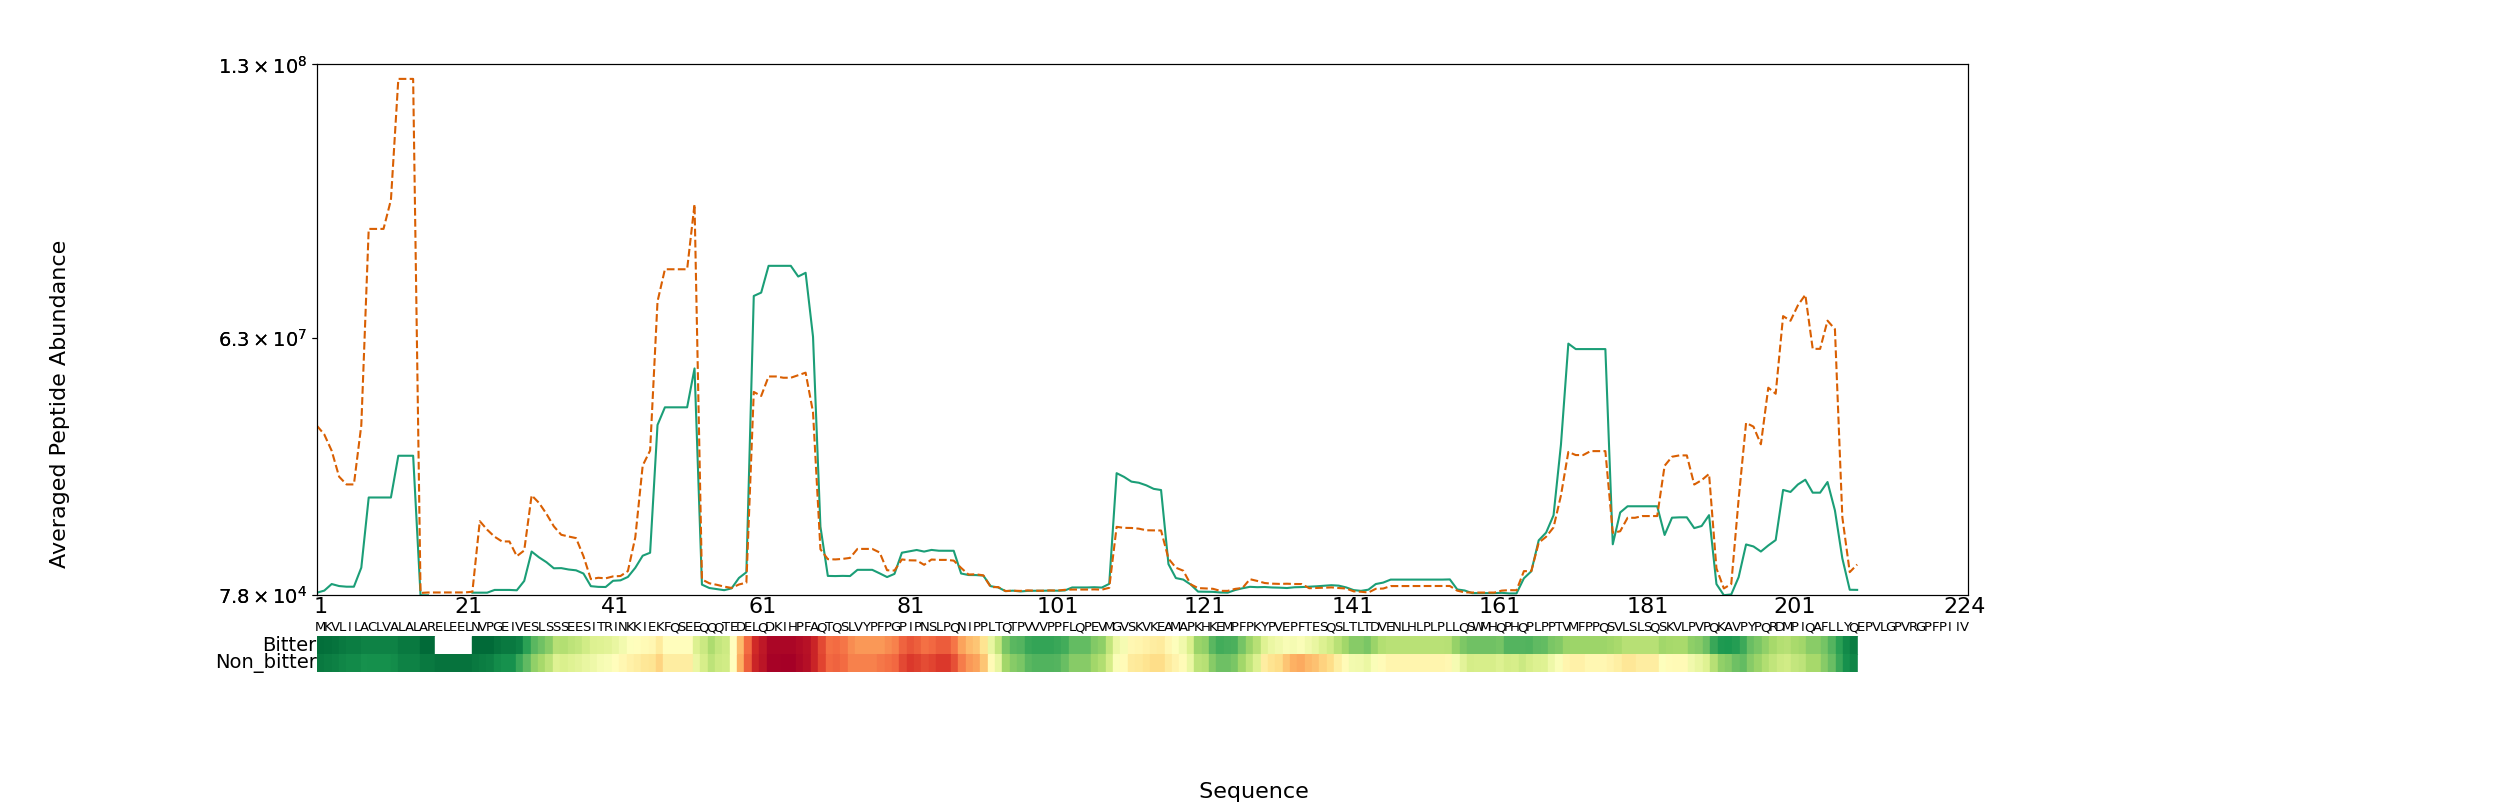

In [77]:
# Initialize the data transformer
data_transformer = DataTransformation()
heatmap_data_handler = HeatmapDataHandler(data_transformer)
plot_handler = HeatmapPlotHandler(data_transformer)

data_transformer.setup_data_loading_ui()

# Initialize and display the visualization handler
viz_handler = DynamicVisualizationHandler(data_transformer)
viz_handler.display()